# imports

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from functools import wraps
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS, to_rgb
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
import warnings
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr, ttest_ind, wilcoxon, sem
from scipy.spatial import distance
from scipy import ndimage, interpolate
from pathlib import Path
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
import config
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from calibration import CharucoEstimator
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle, put_text
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.predictors.tongue_out import TongueOutAnalyzer, TONGUE_CLASS
from analysis.strikes.strikes import Loader, StrikeAnalyzer

In [8]:
orm = ORM()
FIGURE_PATH = '../notebooks/figures'
BAD_ANIMALS = ['PV03', 'PV26', 'PV72', 'PV87', 'PV88', 'PV90', 'PV101', 'PV119', 'PV144']
SCREEN_Y_POS = {'reptilearn4': -4.3, 'msi-regev': 0.06}
COLORS = {
    'PV42': '#1f77b4',
    'PV43': '#17becf',
    'PV85': '#ff7f0e',
    'PV91': '#2ca02c',
    'PV80': '#d62728',
    'PV95': '#bcbd22',
    'PV97': '#9467bd',
    'PV88': '#8c564b',
    'PV99': '#e377c2',
    'PV148': '#90EE90',
    'PV163': '#7f7f7f',
}
SCREEN_PIX_CM = {'reptilearn4': 52.704/1920, 'msi-regev': 34.3/1920}
SCREEN_START_X = {'reptilearn4': 5.59, 'msi-regev': 3.2}

# Figure 3 - Animal Tracking

### trajectory example

In [ ]:
ld = Loader(725, 'front', is_debug=False, orm=orm, is_use_db=False, sec_before=4, sec_after=3.8)
af = ld.frames_df.dropna(subset=[('nose', 'cam_x')])['nose']
x = np.linspace(0, 1, len(af))
cmap = mpl.colormaps['viridis']
cmap_mat = (cmap(x)[:, :3] * 255).astype(int)
last_frame_id = af.index[-2]
_, frame = next(ld.gen_frames([last_frame_id]))
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
for i, row in af.iloc[:-3].reset_index(drop=True).iterrows():
    color = cmap_mat[i, :].tolist()
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 6, color, -1)

for bp in ['nose', 'left_ear', 'right_ear']:
    row = ld.frames_df[bp].loc[last_frame_id]
    if np.isnan(row.cam_x):
        continue
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 9, (255, 0, 0), -1)

frame = frame[100:, :]
fig, ax = plt.subplots(1, 1)
ax.imshow(frame)
ax.grid(False)
ax.axis('off')
secs = (af.index.values - af.index[0]) / 60
cbaxes = ax.inset_axes([0.15, 0.9, 0.25, 0.04])
mpl.colorbar.ColorbarBase(cbaxes, cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=secs.max()), orientation='horizontal', label='Time from\ntrajectory start [sec]')
fig.savefig('../notebooks/arena_figures/single_trajectory.pdf', dpi=250)

### Top trajectories

In [ ]:
idx = {}
dev_angs_speed, h = 1440, 1080
for p in Path(config.EXPERIMENTS_DIR).rglob('*/predictions_gd/*.csv'):
    rf = pd.read_csv(p, index_col=0)
    rf['vid_name'] = p.stem
    idx[p.stem] = rf
    
rdf = pd.concat(idx.values())
rdf['x'] = rdf.cam_x * dev_angs_speed
rdf['y'] = rdf.cam_y * h
rdf['time'] = rdf.vid_name.map(lambda x: datetime.strptime(x.split('_')[1], '%Y%m%dT%H%M%S'))

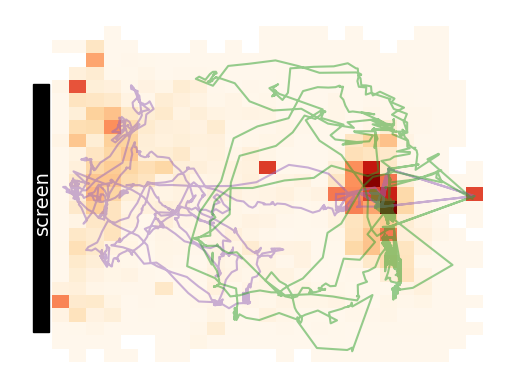

In [ ]:
# plot 
example_vids = [('top_20230625T093053', 'tab:purple'), ('top_20230624T090108', 'tab:green')]
fig, ax = plt.subplots(1,1)
max_hour = 16
rdf_ = rdf.loc[rdf.time.dt.hour <= max_hour].dropna()
# print(f'Number of sessions ')
h = sns.histplot(data=rdf_, x='x', y='y', bins=(25, 25), ax=ax, stat='probability', 
                 cmap=plt.cm.get_cmap('OrRd'),
                 cbar=False, cbar_kws=dict(shrink=.75, label='Probability'))
for vid_name, color in example_vids:
    rf = rdf.query(f'vid_name=="{vid_name}"').sort_values(by='frame_id')
    ax.plot(rf.x, rf.y, color=color, alpha=0.5)
ax.add_patch(Rectangle((0, 150), 50, 700, color='k'))
ax.text(0, (150+700)//2, 'screen', rotation=90, color='w', va='bottom', fontsize=14)
ax.axis('off')
fig.savefig('../notebooks/arena_figures/arena_top_trajectories.pdf', dpi=250)

In [ ]:
i = 1
h._children[0]._coordinates[0, i+1, 0] - h._children[0]._coordinates[0, i, 0] 

53.88787014484406

### Frog vs. Lizard

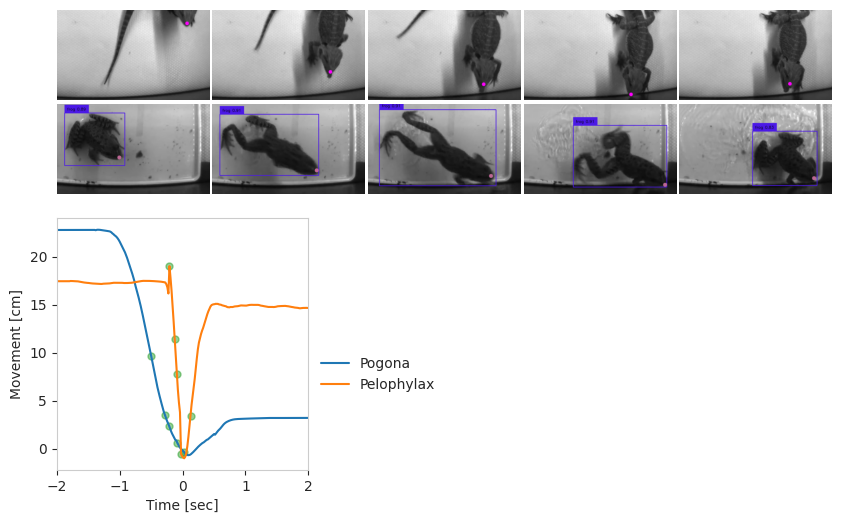

In [ ]:
fig = plt.figure(figsize=(10, 6))
grid = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[3, 4], hspace=0.1) 
upper_grid = grid[0, :].subgridspec(2, 5, wspace=0.02, hspace=0.001)
lower_grid = grid[1, :].subgridspec(1, 3, wspace=0.04)
upper_axes = upper_grid.subplots()
lower_axes = lower_grid.subplots()
# lower_axes[0].axis('equal')
# lower_axes[0].set_aspect('equal', adjustable='box')
for animal, frames_axes in [('pogona', upper_axes[0, :]), ('frog1', upper_axes[1, :])]:
    with open(f'/data/Pogona_Pursuit/notebooks/{animal}_strike_frames.pkl', 'rb') as f:
        data = pickle.load(f)
    
    if animal == 'frog1':
        animal = 'frog'
    frames, y_values = data['frames'], data['y_values']
    t = np.linspace(-2, 2, len(y_values))
    if animal == 'frog':
        y_values = -np.array(y_values)
        y_values = savgol_filter(y_values, 11, polyorder=0)
        y_values = 20 * (y_values - y_values.min()) / (y_values.max() - y_values.min()) - 1
        y_values = y_values.tolist()
        dy = 7
        y_values = dy * [y_values[0]] + y_values[:len(y_values)-dy]
        frames = [(i+dy, frame) for i, frame in frames]
    
    lower_axes[0].plot(t, y_values, label='Pogona' if animal == 'pogona' else 'Pelophylax')
    lower_axes[0].set_xlabel('Time [sec]')
    lower_axes[0].set_ylabel('Movement [cm]')
    lower_axes[0].scatter([t[k] for k, _ in frames], [y_values[k] for k, _ in frames], c='tab:green', s=25, alpha=0.5)
            
    for j, (_, annotated_frame) in enumerate(frames):
        frames_axes[j].imshow(annotated_frame[720:, 570:1180] if animal == 'frog' else annotated_frame[604:1000, 579:1250])
        frames_axes[j].axis('off')

lower_axes[0].legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 0.5))
lower_axes[0].margins(x=0)
lower_axes[0].set_box_aspect(1)
lower_axes[0].tick_params(bottom=True, left=True)
for i in [1, 2]:
    lower_axes[i].axis('off')
fig.savefig('../notebooks/arena_figures/frog_vs_lizard.pdf', dpi=250)

In [ ]:
# add deeplabcut to frog 

from analysis.predictors.deeplabcut import DLCPose

with open(f'/data/Pogona_Pursuit/notebooks/frog_strike_frames.pkl', 'rb') as f:
    data = pickle.load(f)
    
dlc = DLCPose('front')
dlc.init(data['frames'][0][1])

anno_frames = []
for frame_id, frame in data['frames']:
    pdf_ = dlc.predict(frame)
    annotated_frame = dlc.plot_predictions(frame.copy(), 0, pdf_, parts2plot=['nose'], colors=[(189,103,148)])
    anno_frames.append((frame_id, annotated_frame))
    # plt.figure()
    # plt.imshow(annotated_frame)
    
cap = cv2.VideoCapture('/media/sil2/Data/regev/frog_strike1.avi')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pdf = []
for i in range(n_frames):
    ret, frame = cap.read()
    pdf.append(dlc.predict(frame))

pdf = pd.concat(pdf)

data1 = data.copy()
data1['y_values'] = pdf['nose']['cam_y'].values.tolist()
data1['frames'] = anno_frames
with open(f'/data/Pogona_Pursuit/notebooks/frog1_strike_frames.pkl', 'wb') as f:
    pickle.dump(data1, f)

In [ ]:
# create lizard artifact

def create_lizard_artifact(strike_id, is_save=True):
    ld = Loader(strike_id, 'front', is_load_pose=True, is_use_db=False, sec_before=2, sec_after=2)
    sa = StrikeAnalyzer(ld)
    pf = sa.pose_df
    t = (pf.time - pf.time.iloc[0]).dt.total_seconds()
    y_values = pf['y'].values - SCREEN_Y_POS['reptilearn4']
    frames = []
    n_frames = len(y_values)
    frames2plot = [n_frames//2-30, n_frames//2-17, n_frames//2-13, n_frames//2-5, n_frames//2+1]
    
    fig, axes = plt.subplots(1, len(frames2plot), figsize=(20, 4))
    i, j = 0, 0
    for frame_id, frame in ld.gen_frames_around_strike():
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        cX = round(pf['cam_x'][frame_id])
        cY = round(pf['cam_y'][frame_id])
        cv2.circle(frame, (cX, cY), 8, (255, 0, 255), -1)
        if i in frames2plot:
            frames.append((i, frame))
            axes[j].imshow(frame[470:1000, 730:1250])
            j += 1
        i += 1
    fig.tight_layout()
    
    if is_save:
        with open('/data/Pogona_Pursuit/notebooks/pogona_strike_frames.pkl', 'wb') as f:
            pickle.dump({'frames': frames, 'y_values': y_values}, f)
            
create_lizard_artifact(strike_id=106, is_save=False)

# Figure 4 - Real-time strike detection

### Tongue Dataset

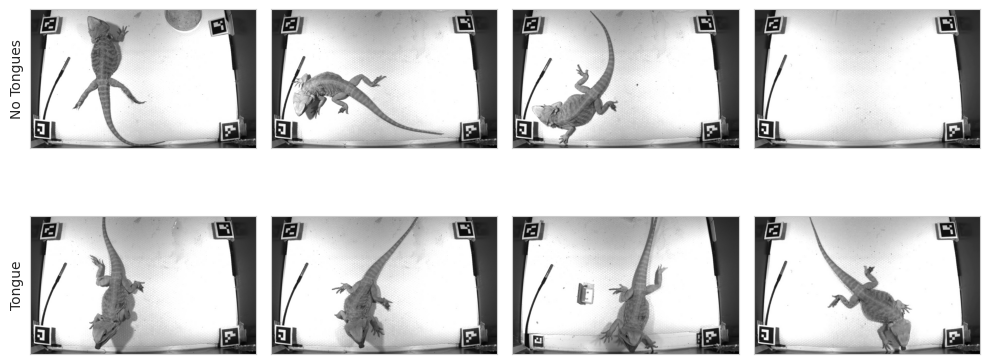

In [ ]:
data = {
    'No Tongues': [
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671363126.3047485.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671549030.4634392.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671551711.601417.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/front_20221213T101615_17006.jpg'
    ],
    'Tongue': [
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671545625.2763906.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671545655.1729114.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671707770.8067603.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/front_20221213T101615_14380.jpg'
    ]
}

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, (title, frames) in enumerate(data.items()):
    for j, p in enumerate(frames):
        frame = cv2.imread(p)
        axes[i, j].imshow(frame[400:950, 300:1200])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        if j == 0:
            axes[i, j].set_ylabel(title)
fig.tight_layout()
fig.savefig(f'../notebooks/arena_figures/tongue_dataset.pdf', dpi=250)

### model evaluation

model analysis.predictors.tongue_out load from: /data/Pogona_Pursuit/output/models/tongue_out/20231128_162618
Loaded tongue dataset with: {'no_tongues': 5073, 'tongues': 1895}


  0%|          | 0/1045 [00:00<?, ?it/s]

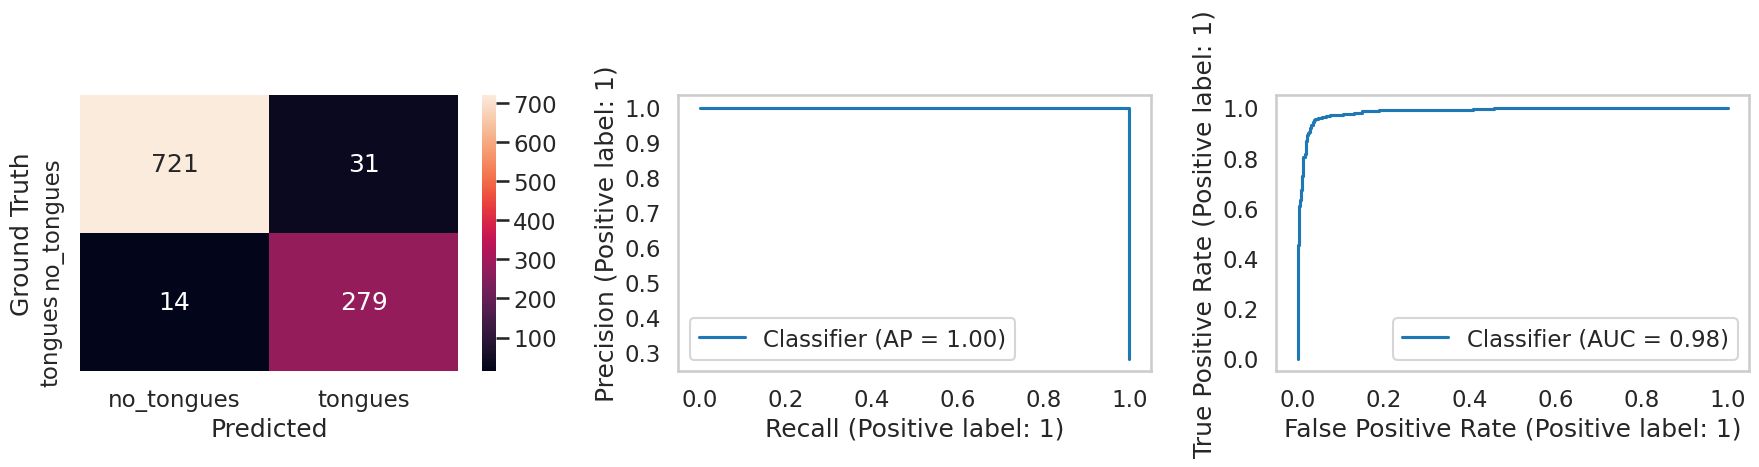

In [ ]:
%matplotlib inline
from analysis.predictors.tongue_out import TongueTrainer

tt = TongueTrainer(model_path='/data/Pogona_Pursuit/output/models/tongue_out/20231128_162618')
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    tt.all_data_evaluation(axes, is_equalize_dataset=False, is_test_set=True)
    fig.tight_layout()
    fig.savefig(f'../notebooks/arena_figures/tongue_model_evaluation.pdf', dpi=250, bbox_inches="tight")

In [ ]:
from torchviz import make_dot
import torch

x = torch.randn(1, 1, 224, 224).cuda()
yhat = tt.model(x)
make_dot(yhat.mean(), params=dict(list(tt.model.named_parameters()))).render("rnn_torchviz", format="pdf")

'rnn_torchviz.pdf'

### Example jump trial

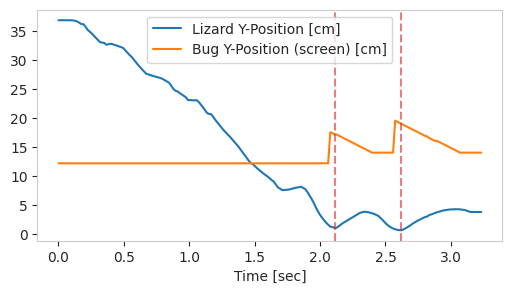

In [ ]:
def plot_jump_example(trial_id, start_id=None):
    with orm.session() as s:
        orm_res = s.query(Trial, Block).join(Block, Block.id == Trial.block_id).filter(Trial.id==trial_id).first()
        traj = pd.DataFrame(orm_res[0].bug_trajectory)
        traj['time'] = pd.to_datetime(traj.time).dt.tz_localize(None)
        vid = [vid for vid in orm_res[1].videos if vid.cam_name=='front'][0]
        pose = DLCArenaPose(cam_name='front').load(video_db_id=int(vid.id))
        pose['time'] = pd.to_datetime(pose.time, unit='s')
        pose = pd.concat([pose['time'], pose['nose']], axis=1)
        
        df = pd.merge_asof(left=traj, right=pose, left_on='time', right_on='time', 
                           direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_traj', '_pose'))
    
    if start_id is not None:
        df = df.iloc[start_id:]
    df['time'] = (df.time - df.time.iloc[0]).dt.total_seconds()
    df['y_traj'] = -(df.y_traj * (53/1440)) + 40
    df['y_pose'] = df.y_pose - df.y_pose.min()
    df['y_pose'] = savgol_filter(df.y_pose.values, window_length=11, polyorder=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    sns.lineplot(data=df, x='time', y='y_pose', ax=ax, label='Lizard Y-Position [cm]')
    sns.lineplot(data=df, x='time', y='y_traj', ax=ax, label='Bug Y-Position (screen) [cm]')
    peaks, _ = find_peaks(-df.y_pose, height=-2, distance=20, width=8)
    for t_ in df.time.iloc[peaks].values:
      plt.axvline(t_, linestyle='--', c='tab:red', alpha=0.6)
    # ax.set_ylim([0, 20])
    # ax.set_title(str(trial_id))
    ax.set_ylabel('')
    ax.set_xlabel('Time [sec]')
    ax.legend()
    ax.tick_params(bottom=True, left=True)
    fig.savefig(f'../notebooks/arena_figures/jump_example_{trial_id}.pdf', dpi=250, bbox_inches="tight")
    

# good trials: [5964, 1787, 2006, 1840]
plot_jump_example(5964, start_id=140)

### jump times before strikes

In [ ]:
with orm.session() as s:
    orm_res = s.query(Strike, Block, Experiment).join(
      Block, Block.id == Strike.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena == 'reptilearn4',
        Experiment.start_time > '2023-06-10',
        Block.movement_type == 'jump_up'
    ).all()
    
    idx = {}
    for strk, _, _ in tqdm(orm_res):
        try:
          ld = Loader(int(strk.id), 'front', sec_before=1.5, sec_after=0)
          traj_df = ld.get_bug_traj_around_strike()
          pose_df = ld.get_bodypart_pose('nose')
          df_ = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                             direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
          t = (df_.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds().values
          traj = df_.y_traj * (-1)
          traj = (traj - traj.min()) / (traj.max() - traj.min())
          # get the jumps using diff
          idx = np.where(np.diff(df_.y_traj.values) < -10)[0]
          # if len(idx) > 0:
          #     # in case there more than 1 jump cancel the previous jumps
          #     traj[np.arange(idx[-1])] = traj[idx[-1]]
          # res[strk.id] = (t, df.y_pose.values, traj)
          idx[strk.id] = t[idx[-1]]
        except Exception as exc:
            continue
                
idx = {k: v for k, v in idx.items() if v}

  0%|          | 0/275 [00:00<?, ?it/s]

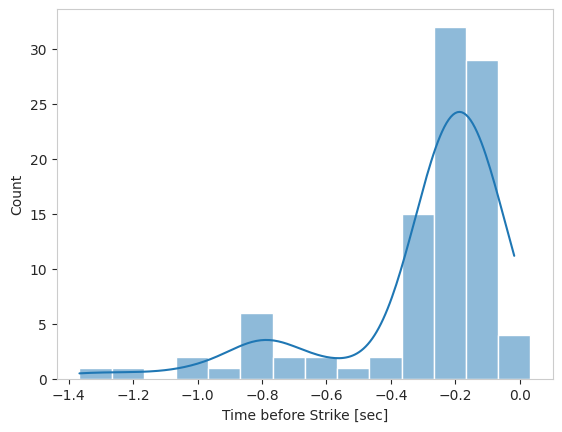

In [ ]:
# with sns.plotting_context("talk"):
fig, ax = plt.subplots(1,1)
sns.histplot(x=list(idx.values()), kde=True, ax=ax, binwidth=0.1)
ax.tick_params(bottom=True, left=True)
ax.set_xlabel('Time before Strike [sec]')
fig.savefig(f'../notebooks/arena_figures/jump_time_before_strikes.pdf', dpi=250, bbox_inches="tight")

# Figure 5 - prey preferences and engagement

In [3]:
def load_strikes_df():
  with orm.session() as s:
      orm_res = s.query(Strike, Trial, Block, Experiment).join(
        Trial, Trial.id == Strike.trial_id).join(
        Block, Block.id == Strike.block_id).join(
        Experiment, Experiment.id == Block.experiment_id).filter(
          Experiment.arena.in_(['reptilearn4', 'msi-regev']),
          Experiment.animal_id.not_in(BAD_ANIMALS),
          Experiment.animal_id.startswith('PV'),
          Experiment.start_time > '2023-04-18'
      ).all()
      
  df_ = []
  for strk, tr, blk, exp in orm_res:
    if tr.bug_trajectory:
      bug_traj = pd.DataFrame(tr.bug_trajectory)
      # exit_hole = 'right' if bug_traj.x.dropna().iloc[0] < 300 else 'left'
      bug_x = bug_traj.x.dropna()
      exit_hole = 'right' if np.sign(bug_x.iloc[10] - bug_x.iloc[0]) == 1 else 'left'
    else:
       exit_hole = None
    miss_distance = np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2)
    df_.append({'animal_id': exp.animal_id, 'movement_type': blk.movement_type,
              'bug_type': strk.bug_type, 'bug_size': strk.bug_size, 'strike_id': strk.id, 'exit_hole': exit_hole,
              'proj_strike': strk.projected_strike_coords, 'is_hit': strk.is_hit, 'miss_distance': miss_distance, 
              'proj_bug_x': strk.projected_leap_coords and strk.projected_leap_coords[0]})
    
  df_ = pd.DataFrame(df_)
  df_['proj_strike_x'] = df_.proj_strike.map(lambda x: x[0] if x and len(x)==2 else None)
  df_['proj_strike_y'] = df_.proj_strike.map(lambda x: x[1] if x and len(x)==2 else None)
  return df_


strk_df = load_strikes_df()

animal_id          movement_type      bug_type  bug_size  strike_id  \
0         PV91            jump_up_old  green_beetle       100        657   
1         PV91                 circle  green_beetle       100        346   
2         PV91            rect_tunnel           ant       100       1416   
3         PV91            rect_tunnel          worm       100       1249   
4         PV91  random_low_horizontal     cockroach       100        106   
...        ...                    ...           ...       ...        ...   
4520      PV91         accelerate_bad  green_beetle       100       4704   
4521      PV91                jump_up  green_beetle       100       4709   
4522      PV91                jump_up  green_beetle       100       4711   
4523      PV91                jump_up  green_beetle       100       4712   
4524      PV91                jump_up  green_beetle       100       4713   

     exit_hole                               proj_strike  is_hit  \
0         left  [-25.459858199959513, 6.065939369789021]    True   
1         left  [-83.70442977058792, -7.032550602425658]   False   
2        right                                      None    True   
3        right                [1505.4695389135766, 79.5]   False   
4        right                              [-51.0, 1.0]    True   
...        ...                                       ...     ...   
4520      left                                      None    True   
4521      left                                      None   False   
4522     right                                      None   False   
4523     right                                      None   False   
4524     right                                      None   False   

      miss_distance  proj_bug_x  proj_strike_x  proj_strike_y  
0         26.925824  -46.818800     -25.459858       6.065939  
1         83.999335 -101.318668     -83.704430      -7.032551  
2         58.574072         NaN            NaN            NaN  
3       1507.567173  -70.530461    1505.469539      79.500000  
4         51.009803 -136.000000     -51.000000       1.000000  
...             ...         ...            ...            ...  
4520      63.007936         NaN            NaN            NaN  
4521     143.000000         NaN            NaN            NaN  
4522     147.085009         NaN            NaN            NaN  
4523     141.173652         NaN            NaN            NaN  
4524      71.175839         NaN            NaN            NaN  

[4525 rows x 12 columns]

In [243]:
from scipy.stats import chi2_contingency


def foo():
    chosen_animals = ['PV80', 'PV91', 'PV95', 'PV163']
    df_ = strk_df.query(f'animal_id in {chosen_animals} and movement_type==["random_low_horizontal","low_horizontal"]')
    
    labels = ['left', 'right']
    ct = []
    for i, metric_name in enumerate(labels):
        g = df_.query(f'exit_hole=="{metric_name}"').groupby('animal_id').is_hit
        ct.append([g.sum().mean(), (g.count()-g.sum()).mean()])
    ct = np.array(ct)
    chi2, pval, dof, expected = chi2_contingency(ct)
    print(ct)
    print(f'chi2: {chi2:.2f}, p-value: {pval:.3f}')

foo()
        

[[49.5  49.25]
 [44.75 54.75]]
chi2: 0.34, p-value: 0.559


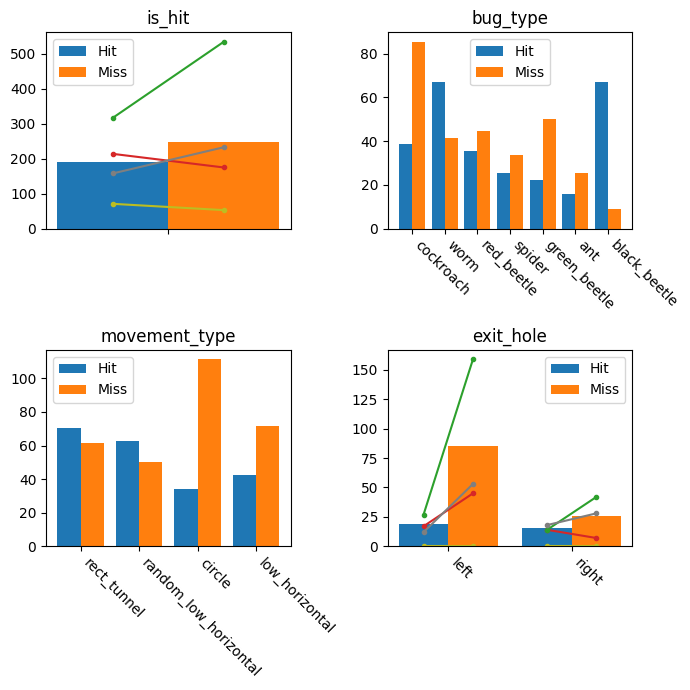

In [251]:
def plot_preferences(ax, metric, movement_types=None, bar_width=0.4):
    np.random.seed(0)
    chosen_animals = ['PV80', 'PV91', 'PV95', 'PV163']
    df_ = strk_df.query(f'animal_id in {chosen_animals}')
    if movement_types:
        df_ = df_.query(f'movement_type in {movement_types}')

    labels = df_[metric].value_counts().index.tolist() if metric != 'is_hit' else ['']
    for i, metric_name in enumerate(labels):
        g = df_
        if metric != 'is_hit':
            g = g.query(f'{metric}=="{metric_name}"')
        g = g.groupby('animal_id').is_hit
        ax.bar(i-(bar_width/2), g.sum().mean(), color='tab:blue', width=bar_width, label='Hit' if i==0 else None)
        ax.bar(i+(bar_width/2), (g.count()-g.sum()).mean(), color='tab:orange', width=bar_width, label='Miss' if i==0 else None)
        if metric in ['is_hit', 'exit_hole']:
            for h, animal_id in enumerate(chosen_animals):
                gf = df_.query(f'animal_id == "{animal_id}"')
                if metric != 'is_hit':
                    gf = gf.query(f'{metric}=="{metric_name}"')
                ax.plot([i-(bar_width/2), i+(bar_width/2)], [(gf.is_hit).sum(), (~gf.is_hit).sum()], '-o', color=COLORS[animal_id], markersize=3)
    
    ax.set_xticks(np.arange(len(labels)), labels, rotation=315, ha='left')
    ax.set_title(metric)
    ax.legend()

# plot_preferences('movement_type', ['random_low_horizontal', 'circle', 'jump_up', 'rect_tunnel', 'low_horizontal'])
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
plot_preferences(axes[0, 0], 'is_hit', ['random_low_horizontal', 'circle', 'rect_tunnel', 'low_horizontal'])
plot_preferences(axes[0, 1], 'bug_type', ['random_low_horizontal', 'circle', 'rect_tunnel', 'low_horizontal'])
plot_preferences(axes[1, 0], 'movement_type', ['random_low_horizontal', 'circle', 'rect_tunnel', 'low_horizontal'])
plot_preferences(axes[1, 1], 'exit_hole', ['circle'])
fig.tight_layout()

### Polar plot of bug preferences

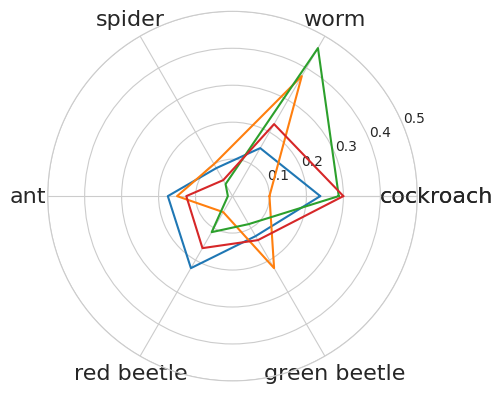

In [ ]:
bugs = ['cockroach', 'worm', 'spider', 'ant', 'red_beetle', 'green_beetle']
bugs = bugs + [bugs[0]]
angles = np.linspace(0, 2*np.pi, len(bugs))
animals = ['PV91', 'PV148', 'PV95', 'PV97']
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
n_samples = 80
for animal_id in animals: 
  vc = strk_df.query(f'animal_id=="{animal_id}"').sample(n_samples, random_state=42).bug_type.value_counts(normalize=True).to_dict()
  vals = [vc.get(bug, 0) for bug in bugs]
  ax.plot(angles, vals)

ax.set_rmax(0.5)
ax.set_rticks([0.1, 0.2, 0.3, 0.4, 0.5])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.set_xticklabels(bugs)
ax.set_xticks(angles, [b.replace('_', ' ') for b in bugs], fontsize=16)
ax.grid(True)
# ax.set_title("A line plot on a polar axis", va='bottom')
fig.savefig('../notebooks/arena_figures/bugs_preferences.pdf', dpi=250)
plt.show()

### Hits on cockroach example

is_hit=0 : 316
is_hit=1 : 129


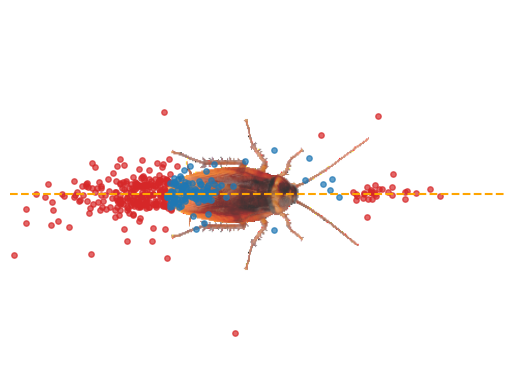

In [ ]:
max_proj_x, max_proj_y = 180, 210

def plot_projected(ax, af):
    ax.axhline(0, linestyle='--', color='orange')
    for state, color in {0: 'tab:red', 1: 'tab:blue'}.items():
      af_ = af.query(f'is_hit=={state}')
      print(f'is_hit={state} : {len(af_)}')
      ax.scatter(af_.proj_strike_x, af_.proj_strike_y, c=color, label='hit' if state else 'miss', s=15, alpha=0.7)
    ax.set_xlim([-max_proj_x, max_proj_x])
    ax.set_ylim([-max_proj_y, max_proj_y])
    
    im = cv2.imread((Path(config.OUTPUT_DIR).parent / 'pogona_hunter/src/assets/cockroach1.png').as_posix(), -1)
    im = ndimage.rotate(im, 270)
    im[np.where(im[:, :, 3] == 0)] = (255, 255, 255, 255)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # cax = ax.inset_axes([0.33, 0.4, 0.29, 0.2], zorder=-1)
    cax = ax.inset_axes([-70, -130, 150, 260], zorder=-1, transform=ax.transData)
    cax.imshow(im, aspect='auto', alpha=0.8)
    cax.axis('off')
    ax.axis('off')
    
fig, ax = plt.subplots(1, 1)
plot_projected(ax, strk_df.query('animal_id=="PV91" and bug_type=="cockroach"'))
fig.savefig('../notebooks/arena_figures/cockroach_with_hits.pdf', dpi=250)

### Miss Distance

In [ ]:
def get_engagement_performance_data():
    conditions = [
        Experiment.arena.in_(['reptilearn4', 'msi-regev']),
        Experiment.animal_id.not_in(BAD_ANIMALS),
        Experiment.animal_id.startswith('PV'),
        Experiment.start_time > '2023-04-18',
    ]
    with orm.session() as s:
        strikes_res = s.query(Strike, Block, Experiment).join(
          Block, Block.id == Strike.block_id).join(
          Experiment, Experiment.id == Block.experiment_id).filter(*conditions).all()
        strikes_df = []
        for strk, blk, exp in strikes_res:
          miss_distance = np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2)
          strikes_df.append({'strike_id': strk.id, 'animal_id': exp.animal_id, 'bug_type': strk.bug_type, 
                             'time': strk.time, 'movement_type': blk.movement_type,
                             'trial_id': strk.trial_id, 'block_id': blk.id, 'bug_speed': strk.calc_speed, 
                             'block_speed': blk.bug_speed, 'is_hit': strk.is_hit, 'miss_distance': miss_distance})
        strikes_df = pd.DataFrame(strikes_df)
        strikes_df['day'] = strikes_df.time.dt.floor('d').copy()
        
        trials_res = s.query(Trial, Block, Experiment).join(
          Block, Block.id == Trial.block_id).join(
          Experiment, Experiment.id == Block.experiment_id).filter(*conditions).all()
        eng_df = []
        for tr, blk, exp in trials_res:
            eng_df.append({'block_id': blk.id, 'trial_id': tr.id, 'animal_id': exp.animal_id, 
                           'is_strike': len(tr.strikes) > 0, 'time': tr.start_time})
        eng_df = pd.DataFrame(eng_df)
        eng_df['day'] = eng_df.time.dt.floor('d').copy()
        eng_df = eng_df.groupby(['animal_id', 'day']).trial_id.count().reset_index()
        # eng_df = eng_df.groupby(['animal_id', 'day']).is_strike.agg(['sum', 'count']).reset_index()
        # eng_df['engagement'] = (eng_df['sum'] / eng_df['count']) * 100
    
    return strikes_df, eng_df

sf, ef = get_engagement_performance_data()
ef

animal_id        day  trial_id
0       PV148 2023-07-07        60
1       PV148 2023-07-08       110
2       PV148 2023-07-09       110
3       PV148 2023-07-10       110
4       PV148 2023-07-11       109
..        ...        ...       ...
183      PV99 2023-07-29        55
184      PV99 2023-07-30        55
185      PV99 2023-07-31        50
186      PV99 2023-08-01        80
187      PV99 2023-08-02        20

[188 rows x 3 columns]

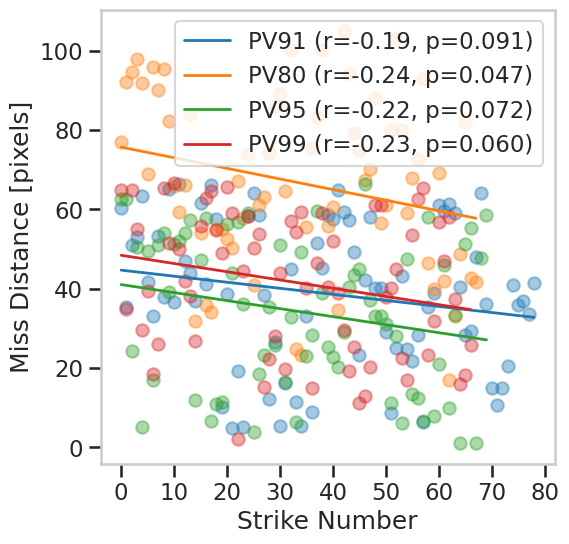

In [ ]:
ANIMALS = ['PV91', 'PV80', 'PV95', 'PV99']
EXAMPLE_ANIMAL = 'PV91'
COLORS = list(TABLEAU_COLORS.values())

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    for i, animal_id in enumerate(ANIMALS):
        # g1 = sf.query(f'animal_id=="{animal_id}" and bug_type=="spider"').groupby('day').strike_id.count().iloc[-10:]
        # g1 = pd.merge(g1, ef.query(f'animal_id=="{animal_id}"'), left_index=True, right_on='day')
        # g1 = g1.strike_id / g1.trial_id * 100
        # x = np.arange(len(g1))
        # y = g1.values
        # axes[0].scatter(x, y, color=COLORS[i], alpha=0.4)
        # plot_regression(axes[0], x, y, color=COLORS[i], prefix=animal_id)
        # axes[0].set_ylabel('Engagement [%]')
        # axes[0].set_xlabel('Days')
        
        g2 = sf.query(f'animal_id=="{animal_id}" and is_hit and movement_type=="random_low_horizontal"').sort_values(by='strike_id')
        x = np.arange(len(g2))
        res = g2.miss_distance.values
        # if animal_id == EXAMPLE_ANIMAL:
        ax.scatter(x, res, color=COLORS[i], alpha=0.4)
        plot_regression(ax, x, res, color=COLORS[i], prefix=animal_id)
        ax.set_ylabel('Miss Distance [pixels]')
        ax.set_xlabel('Strike Number')
        ax.tick_params(bottom=True, left=True)
        ax.set_box_aspect(1)                            
    fig.tight_layout()
    fig.savefig('../notebooks/arena_figures/miss_distance.pdf', dpi=250)

# Figure 6 - Head Movements

In [86]:
def calc_exit_hole(af):
    bug_x = af.bug_x.dropna()
    if len(bug_x) == 0:
        return 'unknown'
    return 'right' if np.sign(bug_x.iloc[10] - bug_x.iloc[0]) == 1 else 'left'


def calc_angle_between_lines(a1, b1, a2, b2):
    return np.arccos((a1*a2 + b1*b2) / (np.sqrt(a1**2 + b1**2) * np.sqrt(a2**2 + b2**2)))


def calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y):
    m_exp = (y - bug_y) / (x - bug_x)
    if ang == np.pi/2:
        x_obs = x
        dev_ang = np.math.degrees(calc_angle_between_lines(1, 0, m_exp, -1))
    else:
        m_obs = np.tan(np.pi-ang)
        n_obs = y - m_obs*x
        x_obs = (bug_y - n_obs)/m_obs
        a = distance.euclidean((bug_x, bug_y), (x, y))
        b = distance.euclidean((x_obs, bug_y), (x, y))
        c = np.abs(x_obs - bug_x)
        dev_ang = np.arccos((a**2 + b**2 - c**2) / (2*a*b))
        if ang > np.pi:
            dev_ang = np.pi - dev_ang
        dev_ang = np.math.degrees(dev_ang)

    sgn = np.sign(x_obs - bug_x) if ang < np.pi else -np.sign(x_obs - bug_x)
    return sgn * dev_ang, x_obs


def get_arena(animal_id):
    return 'msi-regev' if animal_id in ['PV80', 'PV42', 'PV85'] else 'reptilearn4'


def add_dev_angle_to_dataframe(af, animal_id):
    dev_angs, x_obss = [], []
    bug_y = SCREEN_Y_POS[get_arena(animal_id)]
    for j, row in af.iterrows():
        if np.isnan(row.bug_x_cm) or np.isnan(row.nose_x) or any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
            dev_ang, x_obs = np.nan, np.nan
        else:
            dev_ang, x_obs = calc_gaze_deviation_angle(row.angle, bug_y, row.bug_x_cm, row.nose_x, row.nose_y)
        dev_angs.append(dev_ang)
        x_obss.append(x_obs)
    af['dev_angle'] = dev_angs
    af['x_obs'] = x_obss
    return af


def calc_strike_frame(pose_df, orig_strike_frame, delta=20):
    y = pose_df.loc[orig_strike_frame-delta:orig_strike_frame+1, 'nose_y']
    peaks_idx, _ = find_peaks(-y.values, height=-2, distance=10)
    if len(peaks_idx) == 0:
        return orig_strike_frame
    min_peak_id = y[y.index[peaks_idx]].idxmin()
    return min_peak_id

    # for strike_time in strikes_times:
    #     orig_strike_frame = (pose_df.datetime - strike_time).dt.total_seconds().abs().idxmin()
    #     strike_id = pose_df.loc[orig_strike_frame, 'strike_id']
    #     y = pose_df.loc[orig_strike_frame-delta:orig_strike_frame+delta+1, 'nose_y']
    #     peaks_idx, _ = find_peaks(-y.values, height=0, distance=10)
    #     max_peak_id = y[y.index[peaks_idx]].idxmin()
    #     plt.plot([orig_strike_frame, max_peak_id], [y[orig_strike_frame], y[max_peak_id]], '-o', color='tab:orange')

    # plt.scatter(orig_strike_frame, y[orig_strike_frame], color='tab:cyan')
    # plt.scatter(y.index[peaks_idx], y[y.index[peaks_idx]], color='tab:orange')
    # plt.scatter(max_peak_id, y[max_peak_id], color='tab:red')
    # plt.title(f'Strike {strike_id}')
    # plt.show()

def get_pose_df(blk, animal_id):
    dlc = DLCArenaPose('front', orm=orm)
    pose_df = []
    for vid in blk.videos:
        try:
            pdf_ = dlc.load(video_db_id=vid.id)
            pose_df.append(pdf_)
        except Exception:
            pass
    if not pose_df:
        return
    pose_df = pd.concat(pose_df)
    pose_df.columns = ['_'.join(c) if c[1] else c[0] for c in pose_df.columns]
    if 'bug_x_cm' not in pose_df.columns:
        return
    # fix for bug_x
    arena = get_arena(animal_id)
    pose_df['bug_x_cm'] = (pose_df['bug_x'] * SCREEN_PIX_CM[arena]) + SCREEN_START_X[arena]
        
    pose_df['datetime'] = pd.to_datetime(pose_df['time'], unit='s')
    pose_df = add_dev_angle_to_dataframe(pose_df, animal_id)
    return pose_df

def angles_summary(animal_ids, movement_types=None, is_cache=True, is_trial_with_strikes=False):
    cache_path = Path(f'{FIGURE_PATH}/cache/angles_summary_{animal_ids}_{movement_types}_only_strikes_{is_trial_with_strikes}.pkl')
    if is_cache and cache_path.exists():
        with cache_path.open('rb') as f:
            d = pickle.load(f)
            pose_dict, strk_df = d['pose_dict'], d['strikes_df']
    else:
        with orm.session() as s:
            filters = [
                Experiment.arena.in_(['reptilearn4', 'msi-regev']),
                Experiment.animal_id.in_(animal_ids),
                Experiment.animal_id.startswith('PV'),
                Experiment.start_time > '2023-04-18'
            ]
            if movement_types is not None:
                filters.append(Block.movement_type.in_(movement_types))
            orm_res = s.query(Block, Experiment).join(Experiment, Experiment.id == Block.experiment_id).filter(*filters).all()
            pose_dict, strk_df, trials_valid = {}, [], {}
            for blk, exp in tqdm(orm_res):
                animal_id = exp.animal_id
                pose_df = get_pose_df(blk, animal_id)
                if pose_df is None:
                    continue
                bug_trajs = []
                for tr in blk.trials:
                    if is_trial_with_strikes and len(tr.strikes) < 1:
                        continue

                    if tr.bug_trajectory:
                        bug_trajs = pd.DataFrame(tr.bug_trajectory)
                        bug_trajs = bug_trajs.rename(columns={'x': 'bug_x', 'y': 'bug_y'})
                        bug_trajs['datetime'] = pd.to_datetime(bug_trajs['time']).dt.tz_localize(None)
                        bug_trajs = bug_trajs.sort_values(by='datetime')
                        exit_hole = calc_exit_hole(bug_trajs)

                        start_time = bug_trajs.iloc[0].datetime - timedelta(seconds=1)
                        end_time = bug_trajs.iloc[-1].datetime + timedelta(seconds=1)
                        trial_pose_df = pose_df[(pose_df.datetime > start_time) & (pose_df.datetime <= end_time)].copy()
                        trial_pose_df['strike_id'] = np.nan
                        trials_valid[int(tr.id)] = [(trial_pose_df.datetime-trial_pose_df.datetime.iloc[0]).dt.total_seconds(), trial_pose_df.nose_y]
                        
                        trial_strikes_cache = []
                        for strk in tr.strikes:
                            orig_strike_frame = (trial_pose_df.datetime - strk.time).dt.total_seconds().abs().idxmin()
                            strike_frame = calc_strike_frame(trial_pose_df, orig_strike_frame, delta=20)
                            if strike_frame in trial_strikes_cache:
                                continue
                            trial_strikes_cache.append(strike_frame)

                            trial_pose_df.loc[strike_frame, 'strike_id'] = strk.id
                            trials_valid[int(tr.id)].append((orig_strike_frame, strike_frame, strk.id))
                            strk_df.append({'animal_id': exp.animal_id, 'movement_type': blk.movement_type, 
                                            'bug_type': strk.bug_type, 'bug_size': strk.bug_size, 'strike_id': strk.id, 'trial_id': strk.trial_id,
                                            'is_hit': strk.is_hit, 'bug_speed': strk.calc_speed, 'exit_hole': exit_hole,
                                            'strike_x': strk.x, 'strike_y': strk.y, 
                                            'nose_x': trial_pose_df.loc[strike_frame, 'nose_x'], 'nose_y': trial_pose_df.loc[strike_frame, 'nose_y'],
                                            'orig_nose_x': trial_pose_df.loc[orig_strike_frame, 'nose_x'], 'orig_nose_y': trial_pose_df.loc[orig_strike_frame, 'nose_y']})

                        d_ = pose_dict.setdefault(animal_id, {})
                        d_[tr.id] = trial_pose_df
            strk_df = pd.DataFrame(strk_df).set_index('strike_id')

            # cols = 5
            # rows = int(np.ceil(len(trials_valid)/cols))
            # fig, axes = plt.subplots(rows, cols, figsize=(25, rows*3))
            # axes = axes.flatten()
            # colors = ['tab:orange', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan']
            # for i, trial_id in enumerate(sorted(list(trials_valid.keys()))):
            #     l = trials_valid[trial_id]
            #     t, y = l[:2]
            #     axes[i].plot(t, y, color='k')
            #     for j, (orig_strk_id, strk_id, db_strike_id) in enumerate(l[2:]):
            #         axes[i].scatter(t[orig_strk_id], y[orig_strk_id], color=colors[j], marker='v')
            #         axes[i].scatter(t[strk_id], y[strk_id], color=colors[j], marker='o', label=f'{db_strike_id} {(t[orig_strk_id]-t[strk_id])*1000:.0f}ms')
            #     axes[i].set_ylim([-5, 10])
            #     axes[i].legend()
            #     axes[i].set_title(f'Trial {trial_id}')  
            # fig.tight_layout()

            with cache_path.open('wb') as f:
                pickle.dump({'pose_dict': pose_dict, 'strikes_df': strk_df}, f)
    return pose_dict, strk_df


# all_angles_animals = ['PV91', 'PV163', 'PV80', 'PV42', 'PV85', 'PV99', 'PV95', 'PV52']
# all_angles_animals = ['PV91', 'PV163', 'PV99', 'PV95', 'PV52', 'PV97']
all_angles_animals = ['PV52', 'PV91', 'PV163', 'PV99', 'PV95']
chosen_animals = ['PV91', 'PV163', 'PV80', 'PV85']
ocf, strikes_df = angles_summary(all_angles_animals, ['random_low_horizontal', 'low_horizontal'], is_cache=False, is_trial_with_strikes=True)

  0%|          | 0/238 [00:00<?, ?it/s]

In [10]:
FIGURE6_PATH = '../notebooks/arena_figures/figure6'
ANGLES_TIMES = {'trials': [0, 3], 'strikes': [-3, 0.5]}

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


def load_strikes_or_trials(animal_id, trial_id=None, strike_id=None):
    assert bool(trial_id) ^ bool(strike_id)
    if strike_id:
        trial_id = strikes_df.loc[strike_id, 'trial_id']

    af = ocf[animal_id][trial_id].copy()
    first_x_id = af.bug_x_cm.dropna().index[0] if not strike_id else af.query(f'strike_id=={strike_id}').index[0]
    arena = 'msi-regev' if animal_id in ['PV80', 'PV42', 'PV85'] else 'reptilearn4'
    bug_y = SCREEN_Y_POS[arena]
    af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
    af['total_sec'] = af.total_sec - af.loc[first_x_id, 'total_sec']
    start, end = ANGLES_TIMES['trials'] if not strike_id else ANGLES_TIMES['strikes']
    af = af.query(f'{start}<=total_sec<={end}').reset_index(drop=False)
    af = af.rename(columns={'index': 'frame_id'})
    t_ = af.total_sec.values
    return af, t_, bug_y, arena


def get_video_path(af):
    block_id = int(af.block_id.iloc[0])
    with orm.session() as s:
        blk = s.query(Block).filter_by(id=block_id).first()
        video_path = None
        for vid in blk.videos:
            if vid.cam_name == 'front':
                video_path = vid.path
                break
        if video_path is None:
            raise ValueError(f'Could not find video for block {block_id}')
    video_path = video_path.replace('/data/Pogona_Pursuit/output/experiments', '/media/sil2/Data/regev/experiments/reptilearn4')
    return video_path


def plot_frame_with_dev(frames_df, cols=6):
    video_path = get_video_path(frames_df)
    rows = int(np.ceil(len(frames_df)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, rows*3))
    axes = axes.flatten()

    cap = cv2.VideoCapture(video_path)
    for j in range(len(axes)):
        if j < len(frames_df):
            row = frames_df.iloc[j]
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(row.frame_id))
            ret, frame = cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            text_color = (255, 0, 0) if not np.isnan(row.strike_id) else (0, 0, 255)
            put_text(f'Time={row.total_sec:.1f}sec', frame, 10, 100, font_scale=2, thickness=8, color=text_color)
            put_text(f'Angle={np.rad2deg(row.angle):.0f}', frame, 10, 180, font_scale=2, thickness=8, color=text_color)
            put_text(f'Dev.Angle={row.dev_ang:.0f}', frame, 10, 260, font_scale=2, thickness=8, color=text_color)
            put_text(f'BugX={row.bug_x_cm:.2f}', frame, 10, 340, font_scale=2, thickness=8, color=text_color)
            put_text(f'NoseY={row.nose_y-SCREEN_Y_POS["reptilearn4"]:.2f}', frame, 10, 420, font_scale=2, thickness=8, color=text_color)
            for bp in ['nose', 'right_ear', 'left_ear']:
                cv2.circle(frame, (int(row[f'{bp}_cam_x']), int(row[f'{bp}_cam_y'])), 10, (0, 255, 0), -1)
            axes[j].imshow(frame)
        axes[j].axis('off')

    cap.release()


def plot_traj_with_bug(animal_id, trial_id=None, strike_id=None, axes=None, fig=None, triangles_step=10, filename=None, is_plot_frames=True,
                       frames_step=10):
    af, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id, strike_id)
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    arrow_len = 0.5
    cmap = cm.get_cmap('jet')
    z = np.linspace(0, 1, len(t_))

    dev_angles = []
    frames_data = []
    for i, row in af.iterrows():
        if not strike_id and any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
            continue
        bug_y = SCREEN_Y_POS[arena]
        x, y, bug_x, ang = row.nose_x, row.nose_y, row.bug_x_cm, row.angle
        if np.isnan(x) or np.isnan(y) or np.isnan(bug_x):
            continue
        color = cmap(z[i])
        dev_ang, x_obs = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
        dev_angles.append((row.total_sec, dev_ang))
        axes[1].scatter(row.total_sec, dev_ang, color=color)
        if is_plot_frames and not (i % frames_step):
            row['dev_ang'] = dev_ang
            row['color'] = color
            frames_data.append(row)

        if i % triangles_step:
            continue

        axes[0].scatter(x, y, marker='o', s=20, color=color)
        axes[0].scatter(bug_x, bug_y, color=color, marker='o', s=20)
        if not np.isnan(bug_x):
            if ang < np.pi:
                axes[0].plot([x, x_obs], [y, bug_y], '--', color=color)
            axes[0].plot([x, bug_x], [y, bug_y], color=color)
        axes[0].annotate('', (x-arrow_len*np.cos(np.pi - ang), y-arrow_len*np.sin(np.pi - ang)), (x, y), 
                    arrowprops=dict(width=0.3, headwidth=10, headlength=14, shrink=.1, 
                                    facecolor=color, edgecolor='k'))

    if is_plot_frames:
        frames_data = pd.DataFrame(frames_data)
        plot_frame_with_dev(frames_data)

    exit_hole = calc_exit_hole(af)
    t = np.array([x[0] for x in dev_angles])
    a = np.array([x[1] for x in dev_angles])
    axes[1].plot(t, a, color='k', zorder=-1)
    
    axes[0].set_xlim([0, 70])
    title = f'Trial={trial_id}' if not strike_id else f'Strike={strike_id}'
    axes[0].set_title(f'{animal_id}, {title}, exit: {exit_hole}')
    axes[0].invert_yaxis()
    axes[0].add_patch(Rectangle((7, bug_y-1), 43, 2, linewidth=1, edgecolor='none', facecolor='grey', alpha=0.4))
    axes[0].axis('off')

    axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].set_ylabel('Θ [deg]')
    axes[1].set_xlabel('Post-bug-onset time [s]' if not strike_id else 'Pre-strike time [s]')
    axes[1].set_ylim([-180, 180])
    axes[1].margins(x=0)
    xticks = np.arange(ANGLES_TIMES['trials'][0], ANGLES_TIMES['trials'][1]+1, 1)
    axes[1].set_xticks(xticks)

    if fig is not None:
        fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(t_[0], t_[-1]), cmap=cmap), ax=axes[1], label='Time around strike [sec]')
        fig.tight_layout()
        if filename:
            fig.savefig(f'{FIGURE6_PATH}/{filename}.pdf', dpi=200, bbox_inches='tight')
 

# plot_traj_with_bug('PV91', trial_id=10789, frames_step=4, triangles_step=25, filename='example_left_exit')

Chosen start_x = 5.59 cm


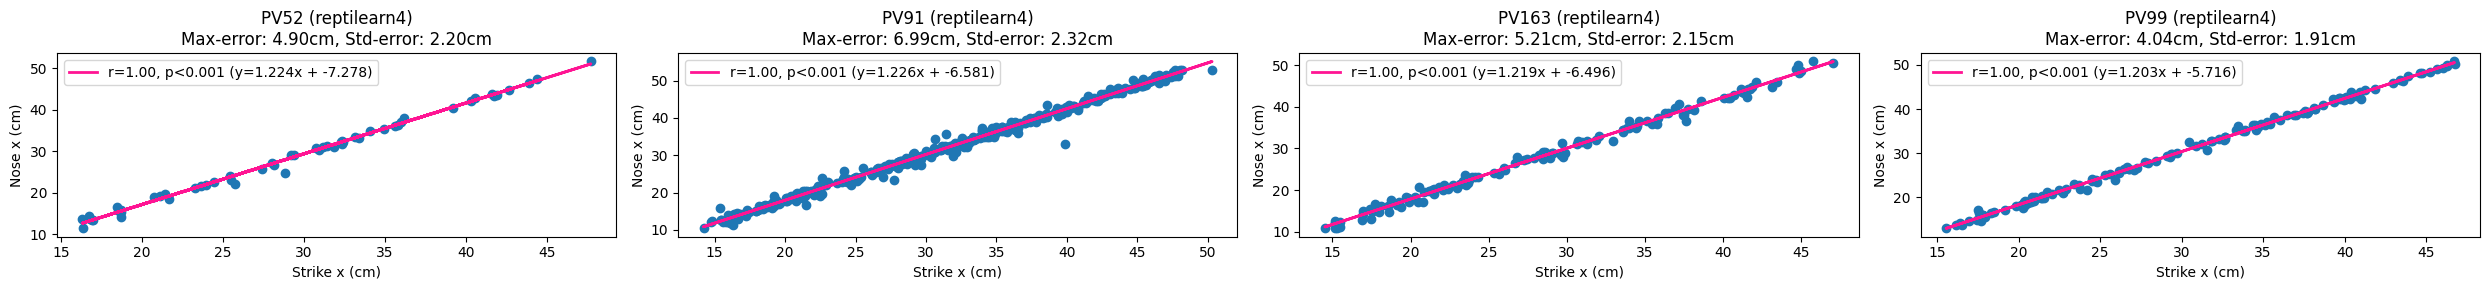

In [7]:
SCREEN_PIX_CM = {'reptilearn4': 52.704/1920, 'msi-regev': 34.3/1920}

def calc_screen_pose_alignment(animal_id, screen_start_x=0, ax=None):
    arena = get_arena(animal_id)
    xf = strikes_df.query(f'animal_id == "{animal_id}"')
    strike_x = SCREEN_PIX_CM[arena]*xf['strike_x'].values + screen_start_x
    nose_x = xf['nose_x'].values
    # print(animal_id, xf.index[np.where(np.abs(nose_x - strike_x) > 5)[0]].tolist())
    max_error = np.abs((nose_x - strike_x)).max()
    std_error = np.sqrt(((nose_x - strike_x)**2).sum() / (len(nose_x) - 1))

    if ax is not None:
        ax.scatter(strike_x, nose_x)
        plot_regression(ax, strike_x, nose_x, is_legend_outside=False, is_line_equation=True)
        ax.set_title(f'{animal_id} ({arena})\nMax-error: {max_error:.2f}cm, Std-error: {std_error:.2f}cm')
        ax.set_xlabel('Strike x (cm)')
        ax.set_ylabel('Nose x (cm)')

    return max_error, std_error


def find_optimal_start_x():
    start_x_array = np.arange(3, 7, 0.01)
    errors = []
    for start_x in start_x_array:
        errs_ = []
        for i, animal_id in enumerate(all_angles_animals):
            max_error, std_error = calc_screen_pose_alignment(animal_id, screen_start_x=start_x)
            errs_.append(std_error)
        errors.append(np.mean(errs_))
    
    start_x = start_x_array[np.argmin(errors)]
    print(f'Chosen start_x = {start_x:.2f} cm')
    cols = 4
    rows = int(np.ceil(len(all_angles_animals) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, 3*rows))
    axes = axes.flatten()
    for i, animal_id in enumerate(all_angles_animals):
        calc_screen_pose_alignment(animal_id, screen_start_x=start_x, ax=axes[i])
    fig.tight_layout()


find_optimal_start_x()

In [ ]:
def plot_strike(strike_id):
    row = strikes_df.loc[strike_id]
    af, t_, bug_y, arena = load_strikes_or_trials(row.animal_id, trial_id=row.trial_id)
    strike_time = af.query('strike_id==strike_id').total_sec.iloc[0]
    af_ = af.query(f'{strike_time-1} <= total_sec <= {strike_time+3}').copy()

    strike_screen_x = SCREEN_PIX_CM[arena]*row.strike_x + SCREEN_START_X[arena]

    plt.plot(af_.total_sec.values, af_.nose_y.values, color='tab:blue')
    plt.plot(af_.total_sec.values, af_.nose_x.values, color='tab:orange')
    plt.axvline(strike_time, color='k', linestyle='--')
    plt.axhline(strike_screen_x, color='tab:red', linestyle='--')

    af_ = add_dev_angle_to_dataframe(af_, row.animal_id)
    af_ = af_.rename(columns={'dev_angle': 'dev_ang'})
    plot_frame_with_dev(af_)


plot_strike(3032)

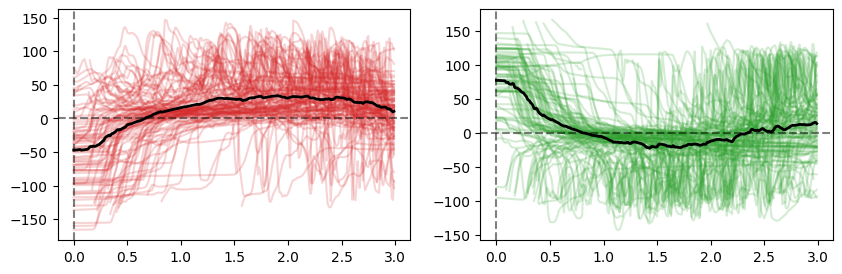

In [27]:
def _calc_avg_dev_angle(animal_id, trial_id, strike_id, t, is_dev_speed, is_abs, min_y=None, max_ang=None):
    af, t_, _, _ = load_strikes_or_trials(animal_id, trial_id, strike_id)
    # if not strike_id and not af.query('strike_id==strike_id').empty:
    #     return
    af.loc[af.angle>np.pi, 'dev_angle'] = np.nan
    if min_y is not None:
        af.loc[af.nose_y<min_y, 'dev_angle'] = np.nan
    if max_ang is not None:
        af.loc[af.angle>max_ang, 'angle'] = np.nan
    dev_angs = af.dev_angle.values
    # dev_angs = savgol_filter(dev_angs, 5, 1, mode='nearest')
    dev_angs_speed = savgol_filter(dev_angs, 5, 1, deriv=1, delta=1/60, mode='nearest')

    if is_dev_speed:
        dev_angs = dev_angs_speed
    if is_abs:
        dev_angs = np.abs(dev_angs)
    dx_ = np.interp(t, t_, dev_angs)
    return dx_


def calc_avg_dx(animal_id, ax=None, is_strike=False, is_dev_speed=False, is_abs=False, is_plot_all=False,
                exit_hole=None, line_color='tab:blue', label='', bug_speed=None, min_y=None, max_ang=None):
    res = []
    t = np.arange(*ANGLES_TIMES['trials'], 0.01) if not is_strike else np.arange(*ANGLES_TIMES['strikes'], 0.01)
    for trial_id in ocf[animal_id].keys():
        trial_exit_hole = calc_exit_hole(ocf[animal_id][trial_id])
        if exit_hole and trial_exit_hole != exit_hole:
            continue
        
        a = None
        if is_strike:
            for strike_id in ocf[animal_id][trial_id].strike_id.dropna().unique():
                if bug_speed:
                    v = strikes_df.loc[strike_id, 'bug_speed']
                    if np.isnan(v) or round(v) != bug_speed:
                        continue
                a = _calc_avg_dev_angle(animal_id, None, strike_id, t, is_dev_speed, is_abs, min_y=min_y, max_ang=max_ang)
                res.append(a)
        else:
            a = _calc_avg_dev_angle(animal_id, trial_id, None, t, is_dev_speed, is_abs, min_y=min_y, max_ang=max_ang)
            res.append(a)
        if is_plot_all and a is not None:
            ax.plot(t, a, color=line_color, alpha=0.2)
    
    res = np.vstack(res)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        avg_res = np.nanmean(res, axis=0)
    if ax is not None:
        ax.plot(t, avg_res, color=line_color if not is_plot_all else 'k', label=label, linewidth=2)
        ax.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    return avg_res, t, res


_, axes_ = plt.subplots(1, 2, figsize=(10, 3))
animal_id = 'PV91'
kwargs = dict(is_strike=False, is_dev_speed=False, max_ang=np.pi, min_y=None, is_plot_all=True)
calc_avg_dx(animal_id, exit_hole='left', ax=axes_[0], line_color='tab:red', **kwargs)
calc_avg_dx(animal_id, exit_hole='right', ax=axes_[1], line_color='tab:green', **kwargs);

In [29]:
with orm.session() as s:
    tr = s.query(Trial).filter_by(dwh_key=10796).first()
print(tr.id)

1118


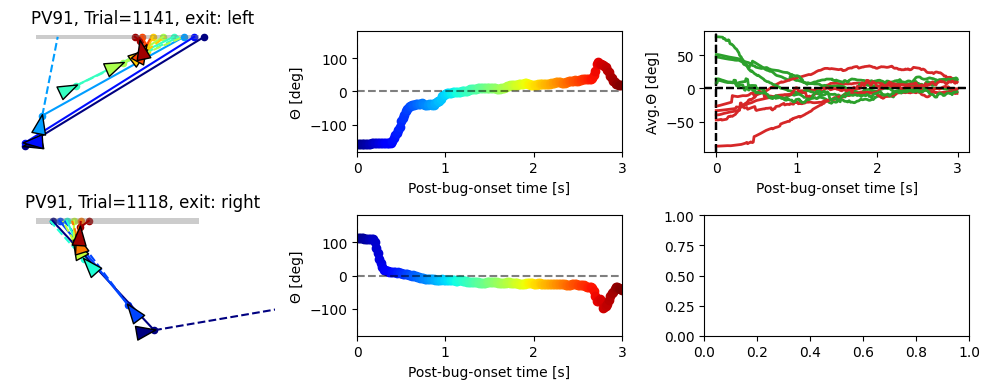

In [118]:
# Figure 6

def plot_figure6():
    fig, axes = plt.subplots(2, 3, figsize=(10, 4))
    plot_traj_with_bug('PV91', trial_id=1141, triangles_step=25, is_plot_frames=False, axes=axes[0, :2])  # dwh: 10930
    plot_traj_with_bug('PV91', trial_id=1118, triangles_step=35, is_plot_frames=False, axes=axes[1, :2])  # dwh: 10796
 
    kwargs = dict(is_strike=False, is_dev_speed=False, max_ang=np.pi, min_y=None, is_plot_all=False)
    for animal_id in all_angles_animals:
        calc_avg_dx(animal_id, exit_hole='left', ax=axes[0, 2], line_color='tab:red', **kwargs)
        calc_avg_dx(animal_id, exit_hole='right', ax=axes[0, 2], line_color='tab:green', **kwargs)
    axes[0, 2].set_ylabel('Avg.Θ [deg]')
    axes[0, 2].set_xlabel('Post-bug-onset time [s]')
    fig.tight_layout()


plot_figure6()

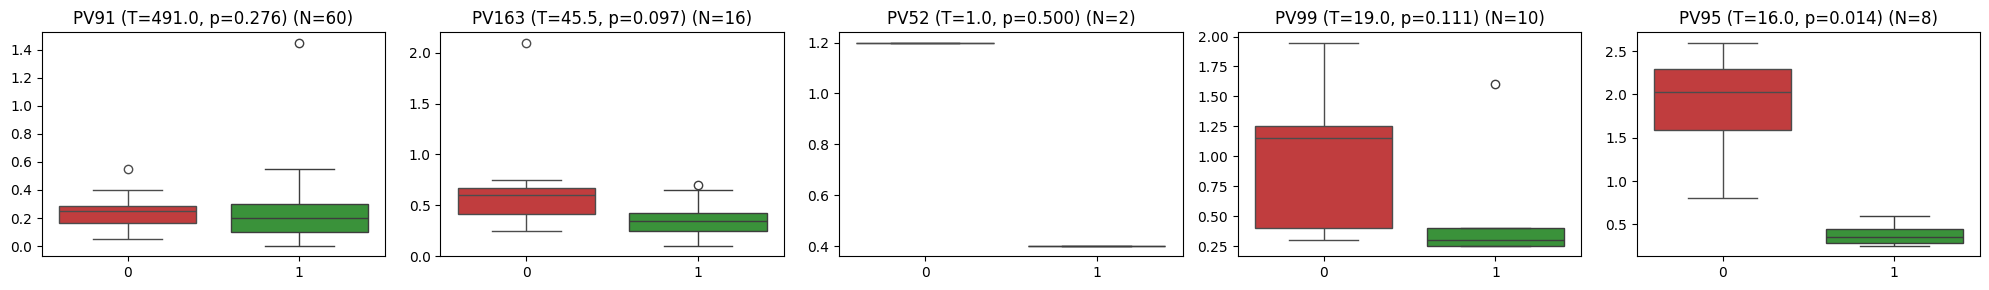

In [142]:
from scipy.stats import mannwhitneyu


def plot_y_after_bug_onset(dt=0.05, init_dev_angle=30, min_y=20, min_speed=10):
    np.random.seed(0)
    sides = ['left', 'right']
    sides_colors = {'left': 'tab:red', 'right': 'tab:green'}
    res = {k: [] for k in sides}
    global_t = np.arange(0, 3, dt)
    fig, axes = plt.subplots(1, len(all_angles_animals), figsize=(20, 3))
    for j, animal_id in enumerate(ocf.keys()):
        res_hists = {k: [] for k in sides}
        for trial_id in ocf[animal_id].keys():
            af, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id=trial_id)
            if af.nose_y.iloc[0] < min_y:
                continue
            if af.dev_angle.iloc[0] > init_dev_angle:
                init_eye = 'left'
            elif af.dev_angle.iloc[0] < -init_dev_angle:
                init_eye = 'right'
            else:
                continue
            
            x = np.interp(global_t, t_, af.nose_y.values)
            dev_ang = np.interp(global_t, t_, af.dev_angle.values)
            x = savgol_filter(x, window_length=5, polyorder=0, mode='nearest')
            dev_ang = savgol_filter(dev_ang, window_length=5, polyorder=0, mode='nearest')
            dx_ = savgol_filter(x, window_length=5, polyorder=1, mode='nearest', deriv=1, delta=dt)
            res[init_eye].append((x, dx_, dev_ang))
            
            ids = np.where(dx_ < -min_speed)[0]
            if len(ids) > 0:
                res_hists[init_eye].append(global_t[ids[0]])

        n = min([len(res_hists[side]) for side in sides])
        stats_data = {}
        for i, side in enumerate(sides):
            vals = res_hists[side]
            vals = np.random.choice(res_hists[side], size=n, replace=False)
            sns.boxplot(x=[i] * len(vals), y=vals, ax=axes[j], color=sides_colors[side])
            stats_data[side] = vals
            # sns.histplot(x=res_hists[side], kde=True, color=sides_colors[side], ax=axes[i], bins=np.arange(0, 3, 0.1))
            # axes[i].hist(res_hists[side], color=sides_colors[side], bins=np.arange(0, 3, 0.1))
            # axes[i].axvline(np.mean(res_hists[side]), color='k', linestyle='--', alpha=0.5)
        fig.tight_layout()

        # t_stat, p_val = ttest_ind(stats_data['left'], stats_data['right'], equal_var=False, alternative='greater')
        U1, p_val = mannwhitneyu(stats_data['left'], stats_data['right'], method="exact", alternative='greater')
        # print(f'T={t_stat:.1f}, p={p_val:.3f}')
        axes[j].set_title(f'{animal_id} (T={U1:.1f}, p={p_val:.3f}) (N={n*2})')

    # cols = 6
    # for side, l in res.items():
    #     rows = int(np.ceil(len(l) / cols))
    #     fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    #     axes = axes.flatten()
    #     for i, (x_, dx_, dev_ang) in enumerate(l):
    #         axes[i].plot(global_t, x_, color=sides_colors[side])
    #         axes[i].plot(global_t, dx_, color=sides_colors[side], linestyle=':')
    #         # axes[i].plot(global_t, dev_ang, color=sides_colors[side], linestyle='-.')

    #         ids = np.where(dx_ < -10)[0]
    #         if len(ids) > 0:
    #             axes[i].axvline(global_t[ids[0]], color='tab:blue', linestyle='--')
            
    #         axes[i].set_ylim([-80, 80])
    #         axes[i].axhline(0, color='k', linestyle='--', alpha=0.5)
    #     fig.tight_layout()


plot_y_after_bug_onset(init_dev_angle=30, min_y=20, min_speed=10)

In [57]:
x = np.arange(30)
len(savgol_filter(x, window_length=5, polyorder=1, mode='nearest', deriv=1, delta=0.1))

30

In [729]:
animal_id = 'PV85'
dates = {}
for trial_id, xf in ocf[animal_id].items():
    dt = pd.to_datetime(xf.time, unit="s").iloc[0].date()
    x = dates.setdefault(str(dt), 0)
    dates[str(dt)] = x + 1

print(dates)

{'2023-04-18': 2, '2023-04-20': 21, '2023-04-19': 14, '2023-04-21': 19, '2023-04-22': 17, '2023-04-23': 16, '2023-04-24': 14, '2023-04-25': 10, '2023-04-26': 14, '2023-04-27': 7, '2023-05-30': 2, '2023-06-12': 4}


In [ ]:
def print_calc_strike_frames(animal_id):
    for trial_id, af in ocf[animal_id].items():
        for frame_id, row in af.query('strike_id==strike_id').iterrows():
            ld = Loader(int(row.strike_id), cam_name='front', orm=orm)
            sa = StrikeAnalyzer(ld)
            print(f'strike_id: {frame_id} - {sa.calc_strike_frame}')

print_calc_strike_frames('PV91')

In [ ]:
def validate_strikes(animal_id, cols=6, is_close_fig=False):
    strike_frames = {}
    for trial_id, af in ocf[animal_id].items():
        af_ = af.query('strike_id==strike_id')
        if af_.empty:
            continue
        
        video_path = get_video_path(af)
        cap = cv2.VideoCapture(video_path)
        for frame_id, row in af_.iterrows():
            strike_id = int(row.strike_id)
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_id))
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                strike_frames[strike_id] = frame
        cap.release()
    
    rows = int(np.ceil(len(strike_frames) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, rows*3))
    axes = axes.flatten()
    for i, (strike_id, frame) in enumerate(strike_frames.items()):
        axes[i].imshow(frame, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Strike {strike_id}')
    fig.tight_layout()
    fig.savefig(f'/media/sil2/Data/regev/tmp/strikes_validation/{animal_id}_calc_strikes.pdf', dpi=200, bbox_inches='tight')
    if is_close_fig:
        plt.close(fig)


for animal_id in tqdm(all_angles_animals):
    validate_strikes(animal_id, is_close_fig=True)

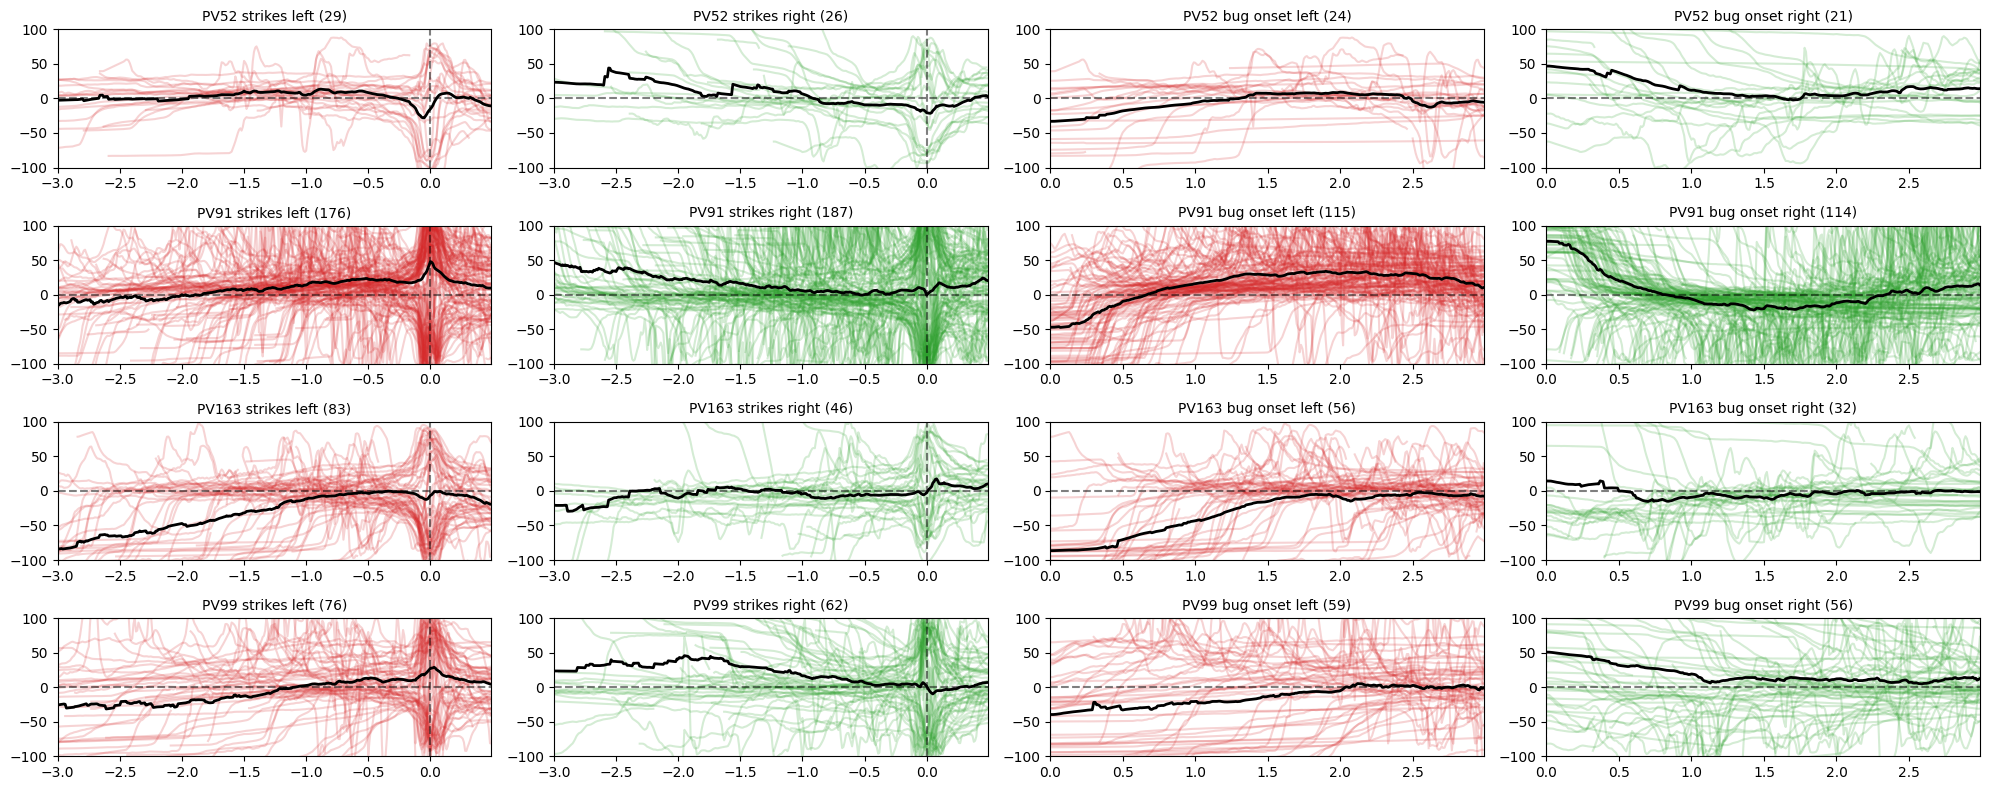

In [17]:
fig, axes = plt.subplots(len(all_angles_animals), 4, figsize=(20, 2*len(all_angles_animals)))
for i, animal_id in enumerate(all_angles_animals):
    arena = get_arena(animal_id)
    for j, (is_strike) in enumerate([True, False]):
        kwargs = dict(is_strike=is_strike, is_dev_speed=False, is_abs=False, max_ang=np.pi, is_plot_all=True)
        for k, side, line_color in zip([2*j, 2*j+1], ['left', 'right'], ['tab:red', 'tab:green']):
            _, _, r = calc_avg_dx(animal_id,  exit_hole=side, ax=axes[i, k], line_color=line_color, label=f'{side} exit', **kwargs)
            axes[i, k].set_title(f'{animal_id} {"strikes" if is_strike else "bug onset"} {side} ({r.shape[0]})', fontsize=10)
            axes[i, k].set_ylim([-100, 100])
            axes[i, k].margins(x=0)

fig.tight_layout()
# fig.savefig('/media/sil2/Data/regev/tmp/strikes_trials_onsets.pdf', dpi=200, bbox_inches='tight')

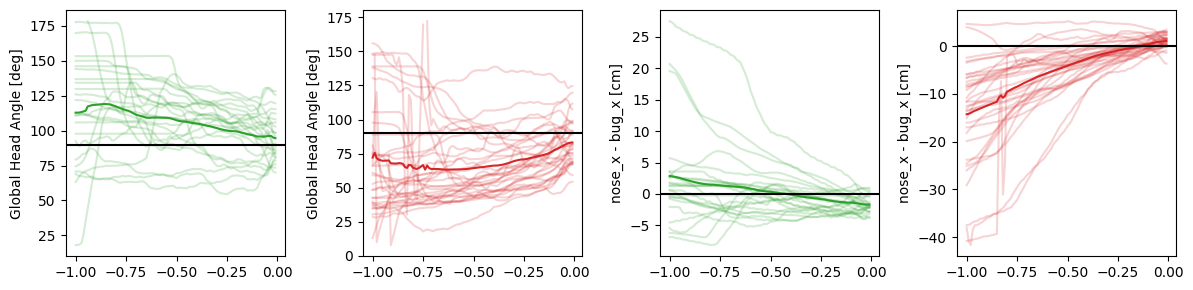

In [14]:
def plot_ang_before_strike(animal_id, time_before=1):
    angs = {}
    dxs = {}
    colors = {'left': 'tab:red', 'right': 'tab:green'}
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for trial_id, af in ocf[animal_id].items():
        af, _, bug_y, arena = load_strikes_or_trials(animal_id, trial_id=trial_id)
        exit_hole = calc_exit_hole(af)
        af_ = af.query('strike_id==strike_id')
        if af_.empty:
            continue
        t = np.arange(-1, 0, 0.01)
        for i in af_.index:
            strike_time = af_.loc[i, 'total_sec']
            t0 = strike_time - time_before
            sf = af.query(f'{t0} < total_sec < {strike_time}').copy()
            sf['total_sec'] = sf.total_sec - strike_time
            # remove if there is a strike before
            if not sf.query('strike_id==strike_id').empty:
                continue

            ang = np.interp(t, sf.total_sec.values, sf.angle.map(np.rad2deg).values)
            ang[ang>180] = np.nan
            angs.setdefault(exit_hole, []).append(ang)
            axes[0 if exit_hole == 'right' else 1].plot(t, ang, color=colors[exit_hole], alpha=0.2)

            dx = np.interp(t, sf.total_sec.values, (sf.nose_x - sf.bug_x_cm).values)
            dxs.setdefault(exit_hole, []).append(dx)
            axes[2 if exit_hole == 'right' else 3].plot(t, dx, color=colors[exit_hole], alpha=0.2)
            
    
    for i, side in enumerate(['right', 'left']):
        angs_ = np.nanmean(np.vstack(angs[side]), axis=0)
        axes[i].plot(t, angs_, color=colors[side])
        dxs_ = np.nanmean(np.vstack(dxs[side]), axis=0)
        axes[i+2].plot(t, dxs_, color=colors[side])
        axes[i].set_ylabel('Global Head Angle [deg]')
        axes[i].axhline(90, color='k')
        axes[i+2].set_ylabel('nose_x - bug_x [cm]')
        axes[i+2].axhline(0, color='k')
    fig.tight_layout()


plot_ang_before_strike('PV163', time_before=1)

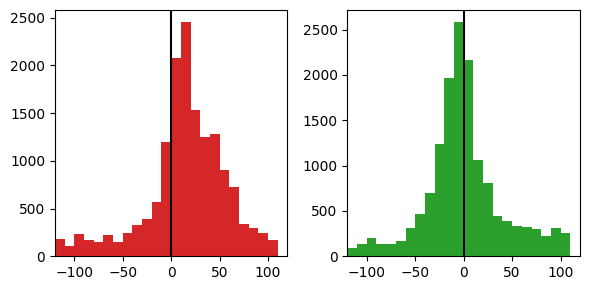

In [16]:
def plot_dev_ang_hist_at_rest(animal_id):
    res = {}
    colors = {'left': 'tab:red', 'right': 'tab:green'}
    for i, trial_id in enumerate(ocf[animal_id].keys()):
        af, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id=trial_id)
        exit_hole = calc_exit_hole(af)
        head_angle = af.angle.values
        y = af.nose_y.values - SCREEN_Y_POS[arena]
        dy = savgol_filter(y, 3, 1, deriv=1, delta=1/60)
        idx = np.where(((np.abs(dy) < 20) & (head_angle<np.pi) & (y>(SCREEN_Y_POS[arena]+3))))[0]
        if len(idx) > 0:
            angs = af.dev_angle.values[idx]
            angs = angs[~np.isnan(angs)]
            res.setdefault(exit_hole, []).extend(angs)
    
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for i, side in enumerate(['left', 'right']):
        axes[i].hist(res[side], bins=np.arange(-120, 120, 10), color=colors[side])
        axes[i].set_xlim(-120, 120)
        axes[i].axvline(0, color='black')
    fig.tight_layout()


plot_dev_ang_hist_at_rest('PV91')

In [ ]:
def plot_before_run_to_screen(animal_id):
    res = []
    colors = {'left': 'tab:red', 'right': 'tab:green'}
    for i, trial_id in enumerate(ocf[animal_id].keys()):
        af, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id=trial_id)
        st_res = []
        dev_ang_hist = []
        for strike_index, row in af.query('strike_id==strike_id').iterrows():
            if row.total_sec < 1:
                st_res.append((strike_index, np.nan))
                continue

            t0 = row.total_sec - 2
            sf = af.query(f'{t0} < total_sec <= {row.total_sec}').copy()
            sf['total_sec'] = sf.total_sec - row.total_sec
            y = sf.nose_y.values - SCREEN_Y_POS[arena]
            dy = savgol_filter(y, 3, 1, deriv=1, delta=1/60)
            idx = np.where(dy>-10)[0]
            idx = idx[idx<(len(y)-10)]
            if len(idx) < 1:
                st_res.append((strike_index, np.nan))
                continue
            hold_id = idx[-1]
            t_hist0 = sf.iloc[hold_id].total_sec - 0.5
            l = sf.query(f'{t_hist0} < total_sec <= {sf.iloc[hold_id].total_sec}').dev_angle.dropna().values.tolist()
            dev_ang_hist.extend(l)
            st_res.append((strike_index, sf.iloc[hold_id].name))

        if not st_res:
            continue
        y = af.nose_y.values - SCREEN_Y_POS[arena]
        dy = savgol_filter(y, 3, 1, deriv=1, delta=1/60)
        exit_hole = calc_exit_hole(af)
        res.append((t_, y, dy, af.angle.map(np.rad2deg).values, st_res, dev_ang_hist, exit_hole, trial_id))
    
    cols=4
    rows = int(np.ceil(len(res) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, rows*3))
    axes = axes.flatten()
    for i, (t, y, dy, dev_ang, st_res, dev_ang_hist, exit_hole, trial_id) in enumerate(res):
        axes[i].plot(t, y, color='tab:blue')
        axes[i].tick_params(axis='y', labelcolor='tab:blue')
        axes[i].set_title(f'Trial {trial_id} ({exit_hole} exit)')
        axes[i].set_ylim([0, 40])

        ax2 = axes[i].twinx()
        ax2.plot(t, dev_ang, color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
        ax2.axhline(90, color='tab:orange', linestyle='--')
        ax2.set_ylim([0, 180])
        
        for strike_id, hold_id in st_res:
            axes[i].axvline(t[strike_id], color='tab:red', linestyle='--')  #  if np.isnan(hold_id) else '-'
            # if not np.isnan(hold_id):
            #     axes[i].axvline(t[hold_id], color='tab:green')
        # axes[2*i+1].hist(dev_ang_hist, bins=np.arange(-120, 120, 10))
        # axes[2*i+1].set_xlim([-120, 120])
    fig.tight_layout()

plot_before_run_to_screen('PV91')

In [ ]:
def plot_around_focus(animal_id, focus_angle=10, sec_after_focus=1, cols=5):
    res = []
    colors = {'left': 'tab:red', 'right': 'tab:green'}
    for i, trial_id in enumerate(ocf[animal_id].keys()):
        af, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id=trial_id)
        exit_hole = calc_exit_hole(af)
        idx = np.where(np.abs(af.dev_angle.values) < focus_angle)[0]
        if len(idx) > 0:
            focus_id = idx[0]
            if focus_id > 0 and np.isnan(af.iloc[focus_id - 1].dev_angle):
                continue
            
            t_start = t_[focus_id] 
            t_last = t_start + sec_after_focus
            af_ = af.query(f'{t_[focus_id]} <= total_sec < {t_last}')
            if not af_.query('strike_id==strike_id').empty:
                continue
            
            res.append((af_.total_sec.values - t_start, af_.dev_angle, af_.nose_y, exit_hole))
    
    rows = int(np.ceil(len(res) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(25, rows*3))
    axes = axes.flatten()
    arena = get_arena(animal_id)
    for i, (t, dev_ang, y, exit_hole) in enumerate(res):
        axes[i].plot(t, y-SCREEN_Y_POS[arena], color=colors[exit_hole])
        axes[i].set_ylim([0, 30])
        axes[i].margins(x=0)
        # axes[i].set_ylim([-150, 150])
        # axes[i].axhline(0, color='k')
        # axes[i].set_title(f'{trial_id} {exit_hole}')
    fig.tight_layout()


plot_around_focus('PV91')

103: (1070.0, 754.0) time: 2023-05-13 17:31:01.429000
strikes according to af: 0


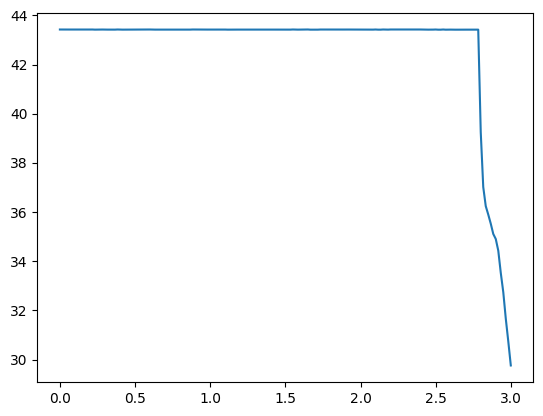

In [99]:
def plot_trial_strikes(animal_id, trial_id):
    with orm.session() as s:
        tr = s.query(Trial).filter_by(id=trial_id).first()
        for strk in sorted(tr.strikes, key=lambda x: x.time):
            print(f'{strk.id}: ({strk.x}, {strk.y}) time: {strk.time}')

    af, t_, bug_y, arena = load_strikes_or_trials(animal_id, trial_id=trial_id)
    sf = af.query('strike_id==strike_id')
    print(f'strikes according to af: {len(sf)}')

    plt.plot(af.total_sec, af.nose_y)
    for i, row in sf.iterrows():
        plt.axvline(row.total_sec, color='tab:red', linestyle='--')

plot_trial_strikes('PV91', 1091)

PV91: right_exit: W=167.00, p = 2.6e-16 | left_exit: W=5050.00, p = 1.0e+00
PV163: right_exit: W=0.00, p = 1.9e-18 | left_exit: W=0.00, p = 1.9e-18
PV99: right_exit: W=0.00, p = 1.9e-18 | left_exit: W=0.00, p = 1.9e-18
PV95: right_exit: W=0.00, p = 1.9e-18 | left_exit: W=0.00, p = 1.9e-18


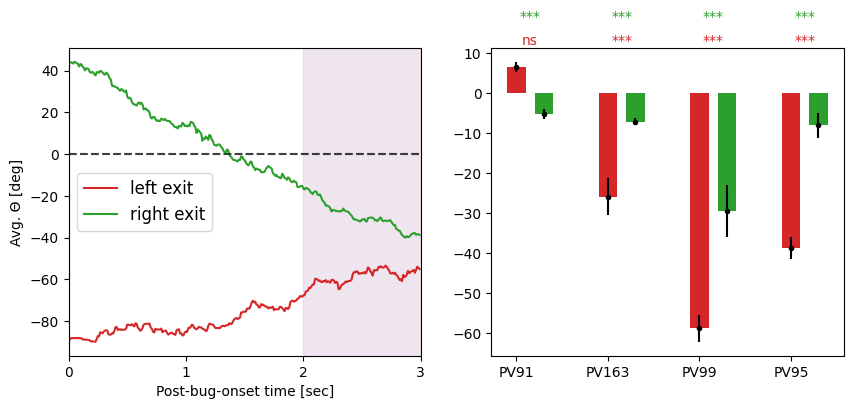

In [ ]:
def plot_dev_before_strike(axes=None, fig=None, example_animal='PV91', right_color='tab:green', left_color='tab:red', bar_width=0.2, bar_space=0.1, 
                           t0=-1.5, t1=-0.5, n_samples=60, is_strike=True, min_y=None, is_plot_all=False, max_ang=None):
    np.random.seed(0)
    assert t1 > t0
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    samples = {}
    for i, animal_id in enumerate(chosen_animals):
        ax = axes[0] if animal_id == example_animal else None
        r_left, t, all_data_left = calc_avg_dx(animal_id, is_strike=is_strike, is_dev_speed=False, is_abs=False, exit_hole='left', 
                                               ax=ax, line_color=left_color, label='left exit', min_y=min_y, max_ang=max_ang)
        r_left, all_data_left = r_left[(t >= t0) & (t < t1)], all_data_left[:,(t >= t0) & (t < t1)]
        m_left, s_left = np.nanmean(r_left), np.nanstd(r_left)
        r_right, t, all_data_right = calc_avg_dx(animal_id, is_strike=is_strike, is_dev_speed=False, is_abs=False, exit_hole='right', 
                                                 ax=ax, line_color=right_color, label='right exit', min_y=min_y, max_ang=max_ang)
        r_right, all_data_right = r_right[(t >= t0) & (t < t1)], all_data_right[:,(t >= t0) & (t < t1)]
        m_right, s_right = np.nanmean(r_right), np.nanstd(r_right)
        axes[1].bar(i, m_left, width=bar_width, label='left exit' if i==0 else None, color=left_color)
        axes[1].errorbar(i, m_left, s_left, fmt='.', color='Black')
        axes[1].bar(i+bar_width+bar_space, m_right, width=bar_width, label='right exit' if i==0 else None, color=right_color)
        axes[1].errorbar(i+bar_width+bar_space, m_right, s_right, fmt='.', color='Black')
        for side, data in [('right', all_data_right), ('left', all_data_left)]:
            n = data.shape[0]
            samples.setdefault(animal_id, {})[side] = np.nanmean(data[np.random.choice(np.arange(n), size=min(n_samples, n)), :], axis=0)

    _, ymax = axes[1].get_ylim()
    for j, animal_id in enumerate(chosen_animals):
        animal_stats = {}
        for side in ['right', 'left']:
            alternative = 'less'
            # alternative = 'greater' if side == 'right' and not is_strike else 'less'
            stat, p = wilcoxon(samples[animal_id][side] - 0, alternative=alternative)
            animal_stats[side] = f'{side}_exit: W={stat:.2f}, p = {p:.1e}'
            p_label = convert_pvalue_to_asterisks(p)
            y = ymax if side == 'left' else ymax+(2 if is_strike else 6)
            axes[1].text(j+(bar_width/2)+(bar_space/2), y, p_label, ha='center', va='bottom', fontsize=10, color=left_color if side=='left' else right_color)
        print(f'{animal_id}: {animal_stats["right"]} | {animal_stats["left"]}')

    axes[0].legend(fontsize=12)
    axes[0].set_xlabel('Pre-strike time [sec]' if is_strike else 'Post-bug-onset time [sec]')
    axes[0].set_ylabel('Avg. Θ [deg]')
    ymin, ymax = axes[0].get_ylim()
    axes[0].add_patch(plt.Rectangle((t0, ymin), t1-t0, ymax-ymin, color='thistle', alpha=0.4))
    axes[0].margins(x=0)
    times = ANGLES_TIMES['trials' if not is_strike else 'strikes']
    xticks = np.arange(times[0], times[1]+1, 1)
    axes[0].set_xticks(xticks)

    axes[1].set_xticks(np.arange(len(chosen_animals)), chosen_animals)
    # axes[1].legend(fontsize=12)
    if fig is not None:
        filename = 'dev_before_strike' if is_strike else 'dev_after_bug_onset'
        fig.savefig(f'{FIGURE6_PATH}/{filename}.pdf', dpi=200, bbox_inches='tight')


plot_dev_before_strike(is_strike=False, t0=2, t1=3, min_y=-2, is_plot_all=False, example_animal='PV99', max_ang=np.pi)

PV91: right_exit: W=26.00, p = 4.3e-18 | left_exit: W=5050.00, p = 1.0e+00
PV163: right_exit: W=0.00, p = 1.9e-18 | left_exit: W=550.00, p = 5.6e-12
PV99: right_exit: W=0.00, p = 1.9e-18 | left_exit: W=0.00, p = 1.9e-18
PV95: right_exit: W=0.00, p = 1.9e-18 | left_exit: W=2441.00, p = 3.9e-01


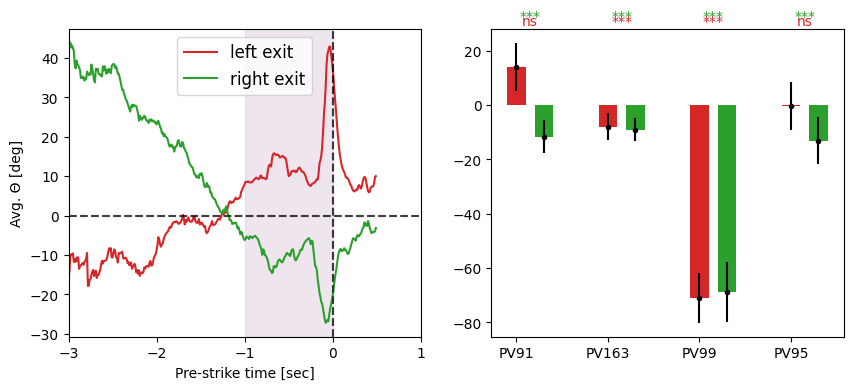

In [ ]:
plot_dev_before_strike(example_animal='PV91', is_strike=True, t0=-1, t1=0)

In [ ]:
def plot_lateralized_hist(animal_id, min_dev_ang=30, max_dev_ang=120, max_ang=np.pi, axes=None):
    hists = {'left': [], 'right': []}
    for trial_id in ocf[animal_id].keys():
        af = ocf[animal_id][trial_id].copy()
        trial_exit_hole = calc_exit_hole(af)
        if trial_exit_hole not in ['left', 'right']:
            continue
        af['dev_ang_abs'] = af.dev_angle.abs()
        af = af.query(f'dev_ang_abs>{min_dev_ang} and dev_ang_abs<{max_dev_ang} and angle<={max_ang}')
        hists[trial_exit_hole].extend(af.dev_angle.dropna().values.tolist())
    
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, side in enumerate(['left', 'right']):
        n ,bins, _ = axes[i].hist(hists[side], np.arange(-max_dev_ang, max_dev_ang+1, 10))
        txt = f'right_eye: {n[bins[:-1]<0].sum():.0f}, left_eye: {n[bins[:-1]>0].sum():.0f}'  
        axes[i].set_title(f'{animal_id} {side}\n{txt}')


fig, axes_ = plt.subplots(len(all_angles_animals), 2, figsize=(10, 3*len(all_angles_animals)))
for i, animal_id in enumerate(all_angles_animals):
    plot_lateralized_hist(animal_id, axes=axes_[i, :])
fig.tight_layout()

In [ ]:
def get_strikes_trials(animal_id, is_hit=None, exit_hole=None, is_print=False):
    df_ = strikes_df.query(f'animal_id=="{animal_id}"')
    if is_hit is not None:
        df_ = df_.query(f'is_hit=={is_hit}')
    if exit_hole:
        df_ = df_.query(f'exit_hole=="{exit_hole}"')
    strikes = sorted(df_.index.tolist())
    trials = sorted(df_.trial_id.values.tolist())
    if is_print:
        print(f'{animal_id}\nStrikes: {strikes}\nTrials: {trials}')
    return strikes, trials


def plot_dev_examples(animal_id, exit_hole=None, n=20):
    strikes_, _ = get_strikes_trials(animal_id, exit_hole=exit_hole)
    strikes_ = np.random.choice(strikes_, size=n, replace=False)
    fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
    for i, strike_id in enumerate(strikes_):
        plot_traj_with_bug(animal_id, strike_id=strike_id, axes=axes[i, :], triangles_step=20)
    fig.tight_layout()


# plot_dev_examples('PV91', 'right')
get_strikes_trials('PV163', is_hit=True, exit_hole='left', is_print=True);

PV163
Strikes: [6694, 6699, 6701, 6728, 6733, 6735, 6736, 6737, 6738, 6739, 6741, 6743, 6761, 6838, 7183, 7185, 7189, 7190, 7192, 7198, 7199, 7200, 7201, 7203, 7211, 7212, 7223, 7425, 7427, 7428, 7429, 7432, 7435, 7436, 7437, 7721, 8218, 8220]
Trials: [26251, 26260, 26265, 26277, 26292, 26294, 26296, 26297, 26299, 26300, 26307, 26315, 26330, 26339, 26898, 26899, 26902, 26903, 26908, 26909, 26924, 26925, 26926, 26927, 26943, 26944, 26956, 27241, 27244, 27245, 27258, 27265, 27341, 27342, 27343, 27593, 29654, 29661]


In [ ]:
n = 30
fig, axes = plt.subplots(n, 3, figsize=(12, 3*n))
animal_id = 'PV91'
strikes_, trials_ = get_strikes_trials(animal_id, exit_hole='right', is_print=False)
for i, strike_id in enumerate(np.random.choice(strikes_, size=min(n, len(strikes_)), replace=False)):
    try:
        plot_traj_with_bug(animal_id, strike_id=strike_id, triangles_step=25, axes=axes[i, :], is_plot_frames=False)
    except Exception as e:
        print(e)
fig.tight_layout()

In [ ]:
def extract_frames(strike_id, cam_name='front'):
    exp_folder = '/media/sil2/Data/regev/experiments/reptilearn4'
    with orm.session() as s:
        strk = s.query(Strike).filter_by(id=strike_id).first()
        trial_id = strk.trial_id
        print(f'Trial ID: {trial_id}')
        blk = s.query(Block).filter_by(id=strk.block_id).first()
        for vid in blk.videos:
            if cam_name == vid.cam_name:
                video_path = Path(f"{exp_folder}/{'/'.join(Path(vid.path).parts[-5:])}")
                print(video_path)
                frames_ts_path = video_path.parent / 'frames_timestamps' / video_path.with_suffix('.csv').name
                frames_ts = pd.read_csv(frames_ts_path, index_col=0)
                frames_ts['datetime'] = pd.to_datetime(frames_ts['0'], unit='s', utc=True).dt.tz_convert('Asia/Jerusalem').dt.tz_localize(None)
                print(frames_ts)
                assert video_path.exists()


extract_frames(2533)

Trial ID: 10710
/media/sil2/Data/regev/experiments/reptilearn4/PV91/20230513/block1/videos/front_20230513T173027.mp4
                  0                      datetime
0      1.683988e+09 2023-05-13 17:30:27.164332032
1      1.683988e+09 2023-05-13 17:30:27.180998656
2      1.683988e+09 2023-05-13 17:30:27.197664512
3      1.683988e+09 2023-05-13 17:30:27.214331136
4      1.683988e+09 2023-05-13 17:30:27.230996992
...             ...                           ...
15837  1.683988e+09 2023-05-13 17:34:51.110207744
15838  1.683988e+09 2023-05-13 17:34:51.126873856
15839  1.683988e+09 2023-05-13 17:34:51.143540736
15840  1.683988e+09 2023-05-13 17:34:51.160206848
15841  1.683988e+09 2023-05-13 17:34:51.176873728

[15842 rows x 2 columns]


In [ ]:
ocf['PV91'][10710].query(f'strike_id=={2533}').index[0]

6925

In [ ]:
strikes_df.loc[2533]

animal_id                         PV91
movement_type    random_low_horizontal
bug_type                        spider
bug_size                           100
trial_id                         10710
is_hit                            True
bug_speed                     4.043911
exit_hole                         left
Name: 2533, dtype: object

In [ ]:
def _calc_avg_dev_angle(animal_id, trial_id, strike_id, t, is_dev_speed, is_abs):
    af, t_, _, _ = load_strikes_or_trials(animal_id, trial_id, strike_id)
    af.loc[af.angle>np.pi, 'dev_angle'] = np.nan
    dev_angs = af.dev_angle.values
    # dev_angs = savgol_filter(dev_angs, 5, 1, mode='nearest')
    dev_angs_speed = savgol_filter(dev_angs, 5, 1, deriv=1, delta=1/60, mode='nearest')

    if is_dev_speed:
        dev_angs = dev_angs_speed
    if is_abs:
        dev_angs = np.abs(dev_angs)
    dx_ = np.interp(t, t_, dev_angs)
    return dx_


def calc_avg_dx(animal_id, ax=None, is_strike=False, is_dev_speed=False, is_abs=False,
                exit_hole=None, line_color='tab:blue', label='', bug_speed=None):
    res = []
    t = np.arange(*ANGLES_TIMES['trials'], 0.01) if not is_strike else np.arange(*ANGLES_TIMES['strikes'], 0.01)
    for trial_id in ocf[animal_id].keys():
        trial_exit_hole = calc_exit_hole(ocf[animal_id][trial_id])
        if exit_hole and trial_exit_hole != exit_hole:
            continue

        if is_strike:
            for strike_id in ocf[animal_id][trial_id].strike_id.dropna().unique():
                if strikes_df.loc[strike_id, 'movement_type'] == 'accelerate':
                    continue
                if bug_speed:
                    v = strikes_df.loc[strike_id, 'bug_speed']
                    if np.isnan(v) or round(v) != bug_speed:
                        continue
                a = _calc_avg_dev_angle(animal_id, None, strike_id, t, is_dev_speed, is_abs)
                # ax.plot(t, a, color='tab:orange', alpha=0.4)
                res.append(a)
        else:
            a = _calc_avg_dev_angle(animal_id, trial_id, None, t, is_dev_speed, is_abs)
            res.append(a)
    
    res = np.vstack(res)
    avg_res = np.nanmean(res, axis=0)
    if ax is not None:
        ax.plot(t, avg_res, color=line_color, label=label)
        ax.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    return avg_res, t, res

ax_ = plt.subplot()
calc_avg_dx('PV91', is_strike=True, is_dev_speed=False, is_abs=False, exit_hole='left', ax=ax_);

In [ ]:
def strikes_angles_summary(animals_ids, movement_types, is_cache=True):
    cache_path = Path(f'{FIGURE_PATH}/cache/strikes_angles_summary_{animals_ids}_{movement_types}.pkl')
    if is_cache and cache_path.exists():
        with cache_path.open('rb') as f:
            d = pickle.load(f)
            res, strikes_df = d['res'], d['strikes_df']
    else:
        with orm.session() as s:
            orm_res = s.query(Strike, Block, Experiment).join(
            Block, Block.id == Strike.block_id).join(
            Experiment, Experiment.id == Block.experiment_id).filter(
                Experiment.arena.in_(['reptilearn4', 'msi-regev']),
                Experiment.animal_id.in_(animals_ids),
                Experiment.start_time > '2023-04-18',
                Block.movement_type.in_(movement_types)
            ).all()
            
            strikes_df = []
            for strk, blk, exp in orm_res:
                strikes_df.append({'animal_id': exp.animal_id, 'movement_type': blk.movement_type, 
                        'bug_type': strk.bug_type, 'bug_size': strk.bug_size, 'strike_id': strk.id, 'trial_id': strk.trial_id,
                        'is_hit': strk.is_hit, 'bug_speed': strk.calc_speed})
            strikes_df = pd.DataFrame(strikes_df)
            res = {}
            for i, row in tqdm(strikes_df.iterrows(), total=len(strikes_df)):
                try:
                    ld = Loader(row.strike_id, 'front', sec_before=4, sec_after=0, orm=orm)
                    pose_df = ld.frames_df[['time', 'x', 'y', 'angle']].copy()
                    pose_df.columns = [x[0] for x in pose_df.columns]
                    pose_df['datetime'] = pd.to_datetime(pose_df['time'], unit='s')

                    tr = s.query(Trial).filter_by(id=row.trial_id).first()
                    if tr.bug_trajectory:
                        bug_trajs = pd.DataFrame(tr.bug_trajectory)
                        bug_trajs = bug_trajs.rename(columns={'x': 'bug_x', 'y': 'bug_y'})
                        bug_trajs['datetime'] = pd.to_datetime(bug_trajs['time']).dt.tz_localize(None)
                        bug_trajs = bug_trajs.sort_values(by='datetime')

                        start_time = bug_trajs.iloc[0].datetime - timedelta(seconds=3)
                        end_time = bug_trajs.iloc[-1].datetime + timedelta(seconds=3)
                        pose_df_ = pose_df[(pose_df.datetime > start_time) & (pose_df.datetime <= end_time)].copy()

                        pose_df_ = pd.merge_asof(left=pose_df_, right=bug_trajs, right_on='datetime', left_on='datetime', 
                                                    direction='nearest', tolerance=pd.Timedelta('20 ms'))
                        d = res.setdefault(row.animal_id, {})
                        d[row.strike_id] = pose_df_
                except Exception as exp:
                    continue
            with cache_path.open('wb') as f:
                    pickle.dump({'res': res, 'strikes_df': strikes_df}, f)

    return res, strikes_df


sadf, strikes_info = strikes_angles_summary(['PV91', 'PV163', 'PV80', 'PV42', 'PV85', 'PV95', 'PV99'], ['random_low_horizontal', 'low_horizontal'], is_cache=False)

  0%|          | 0/1286 [00:00<?, ?it/s]

In [ ]:
def get_trials_bug_speeds():
    bug_speeds_ = {}
    with orm.session() as s:
        for animal_id, d in ocf.items():
            for trial_id, af in d.items():
                if af.empty or af.bug_x.isna().all():
                    continue
                block_id = int(af.block_id.iloc[0])
                blk = s.query(Block).filter_by(id=block_id).first()
                bug_speeds_[trial_id] = blk.bug_speed
    return bug_speeds_
        
bug_speeds = get_trials_bug_speeds()

In [ ]:
def load_angle_trial(animal_id, trial_id):
    af = ocf[animal_id][trial_id].copy()
    first_x_id = af.bug_x.dropna().index[0]
    arena = 'msi-regev' if animal_id in ['PV80', 'PV42'] else 'reptilearn4'
    bug_y = SCREEN_Y_POS[arena]
    exit_hole = 'right' if af.bug_x.loc[first_x_id] < 300 else 'left'
    af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
    af['total_sec'] = af.total_sec - af.loc[first_x_id, 'total_sec']
    af = af.query(f'-1<=total_sec<=2').reset_index(drop=True)
    t_ = af.total_sec.values
    return af, t_, bug_y, arena, exit_hole


def load_angle_strike(animal_id, strike_id):
    af = sadf[animal_id][strike_id].copy()
    arena = 'msi-regev' if animal_id in ['PV80', 'PV42'] else 'reptilearn4'
    bug_y = SCREEN_Y_POS[arena]
    bug_x = af.bug_x.dropna()
    exit_hole = 'right' if np.sign(bug_x.iloc[10] - bug_x.iloc[0]) == 1 else 'left'
    af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
    af['total_sec'] = af.total_sec - af.total_sec.iloc[-1]
    af = af.query(f'-4<=total_sec<=0').reset_index(drop=True)
    t_ = af.total_sec.values
    return af, t_, bug_y, arena, exit_hole


def load_relevant_trials_or_strikes(animal_id, threhsold=0.8, is_strikes=False):
    res = []
    df_ = ocf if not is_strikes else sadf
    f = load_angle_trial if not is_strikes else load_angle_strike
    counts = {'right': 0, 'left': 0}
    for ind, af in df_[animal_id].items():
        af, _, _, _, exit_hole = f(animal_id, ind)
        counts[exit_hole] += 1
        if not is_strikes:
            af = af.query(' and '.join([f'{bp}_prob>={threhsold}' for bp in ['nose', 'right_ear', 'left_ear']]))
            if af.empty:
                continue
        else:
            if af.x.isna().all():
                continue
        # if exit_hole == 'right':
        #     trials_.append(trial_id)
        res.append(ind)
    return res


animal_id_ = 'PV91'
chosen_animals = ['PV42', 'PV80', 'PV85', 'PV91', 'PV95', 'PV163']
trials_ = load_relevant_trials_or_strikes(animal_id_)
strikes_ = load_relevant_trials_or_strikes(animal_id_, is_strikes=True)

In [ ]:
FIGURE6_PATH = '../notebooks/arena_figures/figure6'

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


def calc_angle_between_lines(a1, b1, a2, b2):
    return np.arccos((a1*a2 + b1*b2) / (np.sqrt(a1**2 + b1**2) * np.sqrt(a2**2 + b2**2)))


def calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y):
    m_exp = (y - bug_y) / (x - bug_x)
    if ang == np.pi/2:
        x_obs = x
        dev_ang = np.math.degrees(calc_angle_between_lines(1, 0, m_exp, -1))
    else:
        m_obs = np.tan(np.pi-ang)
        # m_obs = coefficients[0]
        n_obs = y - m_obs*x
        x_obs = (bug_y - n_obs)/m_obs
        # dev_ang = np.math.degrees(np.arctan2(m_exp-m_obs, 1 + m_obs*m_exp))
        # dev_ang = np.math.degrees(calc_angle_between_lines(m_obs, -1, m_exp, -1))
        a = distance.euclidean((bug_x, bug_y), (x, y))
        b = distance.euclidean((x_obs, bug_y), (x, y))
        c = np.abs(x_obs - bug_x)
        dev_ang = np.arccos((a**2 + b**2 - c**2) / (2*a*b))
        if ang > np.pi:
            dev_ang = np.pi - dev_ang
        dev_ang = np.math.degrees(dev_ang)

    sgn = np.sign(x_obs - bug_x) if ang < np.pi else -np.sign(x_obs - bug_x)
    return sgn * dev_ang, x_obs


def plot_traj_with_bug(animal_id, trial_id, axes=None, fig=None, is_strike=False, speed_lim=30):
    if axes is None:
        fig, axes = plt.subplots(1,3, figsize=(15, 4))
    
    f = load_angle_trial if not is_strike else load_angle_strike
    af, t_, bug_y, arena, _ = f(animal_id, trial_id)
    first_bug_x = af.bug_x.dropna().iloc[0]
    arrow_len = 0.5
    cmap = cm.get_cmap('jet')
    z = np.linspace(0, 1, len(t_))
    dev_angles = []
    for i, row in af.iterrows():
        if not is_strike and any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
            continue
        ang = row.angle
        x, y = (row.nose_x, row.nose_y) if not is_strike else (row.x, row.y)
        if np.isnan(x) or np.isnan(y):
            continue
        color = cmap(z[i])
        bug_x = (row.bug_x if not np.isnan(row.bug_x) else first_bug_x) * SCREEN_PIX_CM[arena]
        dev_ang, x_obs = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
        dev_angles.append((row.total_sec, dev_ang))
        axes[1].scatter(row.total_sec, dev_ang, color=color)

        if i % 10:
            continue

        axes[0].scatter(x, y, marker='o', s=20, color=color)
        axes[0].scatter(bug_x, bug_y, color=color, marker='o', s=20)
        # axes[0].text(x+5, y, f'{np.math.degrees(ang):.0f},{dev_ang:.0f}')
        if not np.isnan(row.bug_x):
            if ang < np.pi:
                axes[0].plot([x, x_obs], [y, bug_y], '--', color=color)
            axes[0].plot([x, bug_x], [y, bug_y], color=color)
        axes[0].annotate('', (x-arrow_len*np.cos(np.pi - ang), y-arrow_len*np.sin(np.pi - ang)), (x, y), 
                    arrowprops=dict(width=0.3, headwidth=10, headlength=14, shrink=.1, 
                                    facecolor=color, edgecolor='k'))

    t = np.array([x[0] for x in dev_angles])
    a = np.array([x[1] for x in dev_angles])
    w = savgol_filter(a, 11, 1, deriv=1, delta=1/60)
    axes[1].plot(t, a, color='k', zorder=-1)
    axes[2].plot(t, w, color='k', zorder=-1)
    for i, (t0, w0) in enumerate(zip(t, w)):
        axes[2].scatter(t0, w0, color=cmap(z[i]))
    
    if not is_strike:
        idx = np.where((t > 0) & (np.abs(w) > speed_lim))[0]
        if len(idx) > 0:
            move_start_id = idx[0]
            # axes[2].scatter(t[move_start_id], w[move_start_id], marker='o', s=20, color='k')
            # axes[1].scatter(t[move_start_id], a[move_start_id], marker='o', s=20, color='k')
            ang_sum = np.nansum(a[move_start_id:])
            axes[1].set_title(f'Ang sum = {ang_sum:.1f}')
    # speed_sum = w[t>0].sum() if not is_strike else w.sum()
    # axes[2].set_title(f'Speed sum = {speed_sum:.1f}')

    # ax.plot(af.x, af.y, color='tab:pink', linewidth=2)
    axes[0].set_xlim([0, 70])
    axes[0].set_title(f'{animal_id}, trial={trial_id}')
    # axes[0].set_ylim([-5, 60])
    axes[0].invert_yaxis()
    axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].set_ylabel('Deviation angle [deg]')
    axes[1].set_ylim([-180, 180])

    axes[2].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[2].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[2].set_ylabel('Deviation speed [deg/s]')
    if fig is not None:
        fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(t_[0], t_[-1]), cmap=cmap), ax=axes[2], label='Time around strike [sec]')
        fig.tight_layout()
        fig.savefig(f'{FIGURE6_PATH}/dev_example.pdf', dpi=200, bbox_inches='tight')
 

plot_traj_with_bug(animal_id_, trials_[3], speed_lim=50)
# plot_traj_with_bug(animal_id_, strikes_[4], is_strike=True)

In [ ]:
def foo(animal_id):
    data = load_relevant_trials_or_strikes(animal_id, is_strikes=True)
    counts = {}
    for ind in data:
        af, t_, bug_y, arena, exit_hole_ = load_angle_strike(animal_id, ind)
        counts.setdefault(exit_hole_, 0)
        counts[exit_hole_] += 1
    print(counts)

foo('PV91')

{'left': 366, 'right': 6}


In [ ]:
def calc_avg_dx(animal_id, ax=None, is_strike=False, is_dev_speed=False, is_abs=False, speed_sum_limit=None, 
                exit_hole=None, line_color='tab:blue', label='', bug_speed=None):
    res = []
    t = np.arange(-1, 2, 0.01) if not is_strike else np.arange(-4, 0, 0.01)
    f = load_angle_trial if not is_strike else load_angle_strike
    data = load_relevant_trials_or_strikes(animal_id, is_strikes=is_strike)
    for ind in data:
        if is_strike and bug_speed:
            v = strikes_info.query(f'strike_id=={ind}').bug_speed.iloc[0]
            if np.isnan(v) or round(v) != bug_speed:
                continue
        af, t_, bug_y, arena, exit_hole_ = f(animal_id, ind)
        if exit_hole and exit_hole_ != exit_hole:
            continue
        first_bug_x = af.bug_x.dropna().iloc[0]
        angs = []
        for i, row in af.iterrows():
            ang = row.angle
            x, y = (row.nose_x, row.nose_y) if not is_strike else (row.x, row.y)
            if (not is_strike and any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear'])) or np.isnan(x) or np.isnan(y):
                angs.append(np.nan)
                continue

            bug_x = (row.bug_x if not np.isnan(row.bug_x) else first_bug_x) * SCREEN_PIX_CM[arena]
            a, _ = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
            angs.append(a)

        angs = savgol_filter(angs, 5, 1, mode='nearest')
        w = savgol_filter(angs, 11, 1, deriv=1, delta=1/60, mode='nearest')
        idx = (t_ > 0) if not is_strike else (t_ > -4)
        if speed_sum_limit and np.nansum(np.abs(w[idx])) < speed_sum_limit:
            continue

        if is_dev_speed:
            angs = w
        if is_abs:
            angs = np.abs(angs)
        dx_ = np.interp(t, t_, angs)
        res.append(dx_)
    
    res = np.vstack(res)
    avg_res = np.nanmean(res, axis=0)
    if ax is not None:
        ax.plot(t, avg_res, color=line_color, label=label)
        ax.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    return avg_res, t, res

# ax_ = plt.subplot()
# calc_avg_dx('PV163', is_strike=False, is_dev_speed=False, is_abs=False, exit_hole='right', ax=ax_);

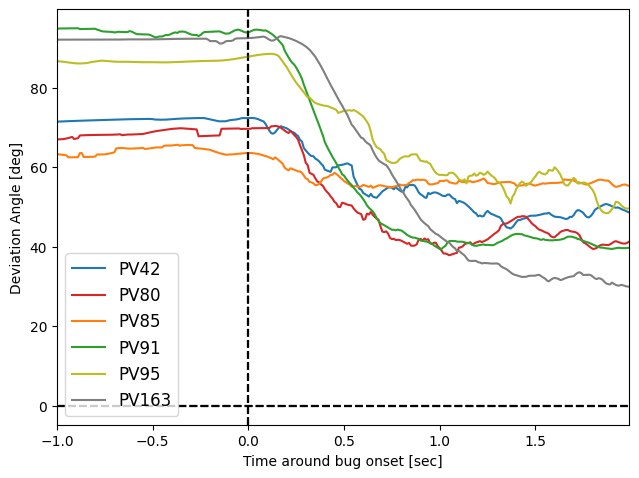

In [ ]:
def plot_focus_after_bug_onset(ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    for animal_id in chosen_animals:
        calc_avg_dx(animal_id, is_dev_speed=False, is_abs=True, speed_sum_limit=3000, ax=ax, line_color=COLORS[animal_id], label=animal_id)
    ax.legend(fontsize=12)
    ax.set_xlabel('Time around bug onset [sec]')
    ax.set_ylabel('Deviation Angle [deg]')
    ax.margins(x=0)
    if fig is not None:
        fig.savefig(f'{FIGURE6_PATH}/dev_angle_bug_onset.pdf', dpi=200, bbox_inches='tight')
        fig.tight_layout()


plot_focus_after_bug_onset()

PV42: right W=0.00, p = 2.8e-18
PV42: left W=0.00, p = 2.8e-18
PV80: right W=0.00, p = 2.8e-18
PV80: left W=0.00, p = 2.8e-18
PV85: right W=0.00, p = 2.8e-18
PV85: left W=0.00, p = 2.8e-18
PV91: right W=0.00, p = 2.8e-18
PV91: left W=0.00, p = 2.8e-18
PV95: right W=0.00, p = 2.8e-18
PV95: left W=0.00, p = 2.8e-18
PV163: right W=21.00, p = 5.4e-18
PV163: left W=0.00, p = 2.8e-18


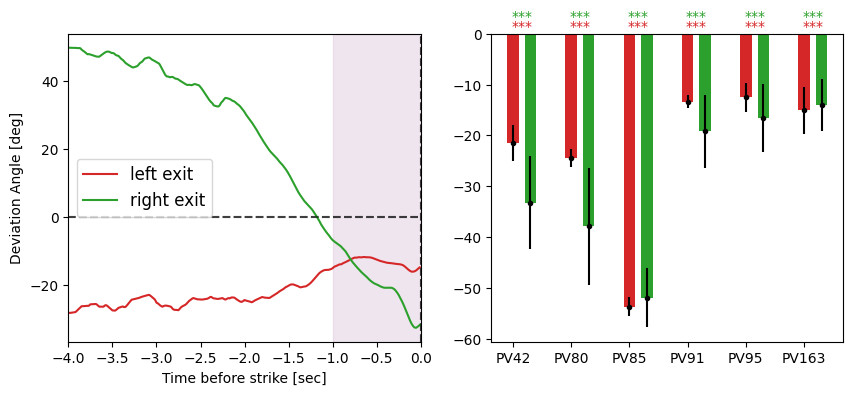

In [ ]:
def plot_dev_before_strike(axes=None, fig=None, example_animal='PV91', right_color='tab:green', left_color='tab:red', bar_width=0.2, bar_space=0.1, 
                           t0=-1, t1=0, n_samples=60):
    np.random.seed(0)
    assert t1 > t0
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    samples = {}
    for i, animal_id in enumerate(chosen_animals):
        ax = axes[0] if animal_id == example_animal else None
        r_left, t, all_data_left = calc_avg_dx(animal_id, is_strike=True, is_dev_speed=False, is_abs=False, exit_hole='left', ax=ax, line_color=left_color, label='left exit')
        r_left, all_data_left = r_left[(t >= t0) & (t < t1)], all_data_left[:,(t >= t0) & (t < t1)]
        m_left, s_left = np.nanmean(r_left), np.nanstd(r_left)
        r_right, t, all_data_right = calc_avg_dx(animal_id, is_strike=True, is_dev_speed=False, is_abs=False, exit_hole='right', ax=ax, line_color=right_color, label='right exit')
        r_right, all_data_right = r_right[(t >= t0) & (t < t1)], all_data_right[:,(t >= t0) & (t < t1)]
        m_right, s_right = np.nanmean(r_right), np.nanstd(r_right)
        axes[1].bar(i, m_left, width=bar_width, label='left exit' if i==0 else None, color=left_color)
        axes[1].errorbar(i, m_left, s_left, fmt='.', color='Black')
        axes[1].bar(i+bar_width+bar_space, m_right, width=bar_width, label='right exit' if i==0 else None, color=right_color)
        axes[1].errorbar(i+bar_width+bar_space, m_right, s_right, fmt='.', color='Black')
        for side, data in [('right', all_data_right), ('left', all_data_left)]:
            n = data.shape[0]
            samples.setdefault(animal_id, {})[side] = data[np.random.choice(np.arange(n), size=min(n_samples, n)), :].mean(axis=0)

    _, ymax = axes[1].get_ylim()
    for j, animal_id in enumerate(chosen_animals):
        for side in ['right', 'left']:
            stat, p = wilcoxon(samples[animal_id][side] - 0, alternative='less')
            print(f'{animal_id}: {side} W={stat:.2f}, p = {p:.1e}')
            p_label = convert_pvalue_to_asterisks(p)
            y = ymax if side == 'left' else ymax+2
            axes[1].text(j+(bar_width/2)+(bar_space/2), y, p_label, ha='center', va='bottom', fontsize=10, color=left_color if side=='left' else right_color)

    axes[0].legend(fontsize=12)
    axes[0].set_xlabel('Time before strike [sec]')
    axes[0].set_ylabel('Deviation Angle [deg]')
    ymin, ymax = axes[0].get_ylim()
    axes[0].add_patch(plt.Rectangle((t0, ymin), t1-t0, ymax-ymin, color='thistle', alpha=0.4))
    axes[0].margins(x=0)

    axes[1].set_xticks(np.arange(len(chosen_animals)), chosen_animals)
    # axes[1].legend(fontsize=12)
    if fig is not None:
        fig.savefig(f'{FIGURE6_PATH}/dev_before_strike.pdf', dpi=200, bbox_inches='tight')


plot_dev_before_strike()

PV42: right (110) W=73.00, p = 3.6e-07
PV42: left (67) W=32.00, p = 2.5e-09
PV80: right (110) W=454.00, p = 7.2e-01
PV80: left (67) W=29.00, p = 1.6e-09
PV85: right (110) W=3.00, p = 4.5e-12
PV85: left (67) W=39.00, p = 6.9e-09
PV91: right (110) W=168.00, p = 4.0e-04
PV91: left (67) W=142.00, p = 8.5e-05
PV95: right (110) W=170.00, p = 1.5e-03
PV95: left (67) W=67.00, p = 1.2e-05
PV163: right (110) W=313.00, p = 9.8e-02
PV163: left (67) W=92.00, p = 2.1e-06


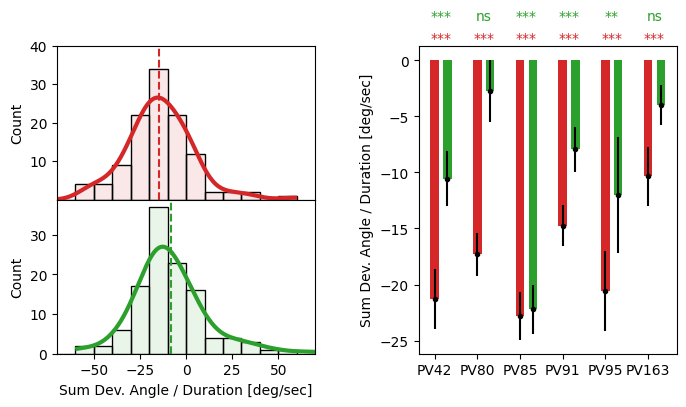

In [ ]:
def plot_dev_sum_histogram(chosen_animal_id='PV91', speed_lim=30, speed_sum_limit=None, right_color='tab:green', left_color='tab:red', 
                           bar_width=0.2, bar_space=0.1, n_samples=40):
    np.random.seed(0)
    fig = plt.figure(figsize=(8, 4))
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (1,0), sharex=ax1)
    ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
    
    samples = {}
    for j, animal_id in enumerate(chosen_animals):
        res = {'left': [], 'right': []}
        data = load_relevant_trials_or_strikes(animal_id, is_strikes=False)
        for ind in data:
            af, t_, bug_y, arena, exit_hole_ = load_angle_trial(animal_id, ind)
            first_bug_x = af.bug_x.dropna().iloc[0]
            angs = []
            for i, row in af.iterrows():
                ang = row.angle
                x, y = (row.nose_x, row.nose_y)
                if any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']) or np.isnan(x) or np.isnan(y):
                    angs.append(np.nan)
                    continue

                bug_x = (row.bug_x if not np.isnan(row.bug_x) else first_bug_x) * SCREEN_PIX_CM[arena]
                a, _ = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
                angs.append(a)

            angs = savgol_filter(angs, 5, 1, mode='nearest')
            w = savgol_filter(angs, 5, 1, deriv=1, delta=1/60, mode='nearest')
            if speed_sum_limit and np.nansum(np.abs(w[t_ > 0])) < speed_sum_limit:
                continue
                
            idx = np.where((t_ > 0) & (np.abs(w) > speed_lim))[0]
            if len(idx) > 0:
                move_start_id = idx[0]
                duration = t_[-1] - t_[move_start_id]
                if duration == 0:
                    continue
                ang_sum = np.nansum(angs[move_start_id:]) / (angs.shape[0])
                res[exit_hole_].append(ang_sum)
        
        if animal_id == chosen_animal_id:
            bins = np.arange(-70, 70, 10)
            sns.histplot(res['left'], bins=bins, color=left_color, label='left exit', kde=True, ax=ax1, alpha=0.1, line_kws=dict(linewidth=3))
            sns.histplot(res['right'], bins=bins, color=right_color, label='right exit', kde=True, ax=ax2, alpha=0.1, line_kws=dict(linewidth=3))
            ax1.axvline(np.nanmean(res['left']), color=left_color, linestyle='--')
            ax2.axvline(np.nanmean(res['right']), color=right_color, linestyle='--')
            ax1.set_xlim([-70, 70])
            ax2.set_xlim([-70, 70])

        ax3.bar(j, np.nanmean(res['left']), width=bar_width, label='left exit' if j==0 else None, color=left_color)
        ax3.errorbar(j, np.nanmean(res['left']), sem(res['left']), fmt='.', color='Black')
        ax3.bar(j+bar_width+bar_space, np.nanmean(res['right']), width=bar_width, label='right exit' if j==0 else None, color=right_color)
        ax3.errorbar(j+bar_width+bar_space, np.nanmean(res['right']), sem(res['right']), fmt='.', color='Black')
        for side in ['right', 'left']:
            samples.setdefault(animal_id, {})[side] = np.random.choice(np.array(res[side]), size=min(n_samples, len(res[side])))

    _, ymax = ax3.get_ylim()
    for j, animal_id in enumerate(chosen_animals):
        for side in ['right', 'left']:
            stat, p = wilcoxon(samples[animal_id][side] - 0, alternative='less')
            print(f'{animal_id}: {side} ({len(res[side])}) W={stat:.2f}, p = {p:.1e}')
            p_label = convert_pvalue_to_asterisks(p)
            y = ymax if side == 'left' else ymax+2
            ax3.text(j+(bar_width/2)+(bar_space/2), y, p_label, ha='center', va='bottom', fontsize=10, color=left_color if side=='left' else right_color)
    
    ax2.set_xlabel('Sum Dev. Angle / Duration [deg/sec]')
    ax3.set_ylabel('Sum Dev. Angle / Duration [deg/sec]')
    ax3.set_xticks(np.arange(len(chosen_animals)), chosen_animals)
    fig.subplots_adjust(hspace=0, wspace=0.4)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.set_yticks(ax1.get_yticks()[1:])
    if fig is not None:
        fig.savefig(f'{FIGURE6_PATH}/sum_dev_angle.pdf', dpi=200, bbox_inches='tight')
        

plot_dev_sum_histogram(speed_lim=50)

In [ ]:
# animals2plot = ['PV80', 'PV91', 'PV95', 'PV163']
animals2plot = ['PV91', 'PV163', 'PV80', 'PV42', 'PV85', 'PV95', 'PV99']
fig, axes = plt.subplots(len(animals2plot), 2, figsize=(8, 2*len(animals2plot)))
for i, animal_id in enumerate(animals2plot):
    for j, (is_strike) in enumerate([True, False]):
        counts = {}
        for side, side_color in zip(['right', 'left'], ['tab:green', 'tab:red']):
            _, _, r = calc_avg_dx(animal_id, is_strike=is_strike, is_dev_speed=False, is_abs=False, exit_hole=side, ax=axes[i, j], 
                                  line_color=side_color, label=f'{side} exit')
            counts[side] = r.shape[0]
        axes[i, j].set_title(f'{animal_id} {"strikes" if is_strike else "bug onset"} {counts}')
        axes[i, j].margins(x=0)
fig.tight_layout()
fig.savefig('/media/sil2/Data/regev/tmp/strikes_trials_onsets.pdf', dpi=200, bbox_inches='tight')

# Head Movement Examples

In [ ]:
with orm.session() as s:
    r = s.query(Video).filter_by(animal_id='PV91', cam_name='front').all()
    for vid in r:
        print(vid.id)

495
1071
1077
1082
501
498
499
912
916
885
900
890
904
908
504
505
1318
1323
238
240
247
242
244
246
657
649
641
625
617
633
263
260
257
252
256
254
250
261
266
280
270
273
278
276
271
267
286
287
284
307
310
291
296
293
300
297
289
301
304
346
342
343
352
354
356
358
348
350
318
329
333
316
319
324
321
311
314
328
326
332
339
336
338
1102
1087
1097
1092
386
395
362
370
368
374
372
364
360
378
365
382
390
380
400
397
384
392
394
403
402
416
412
409
407
414
405
664
672
680
755
748
744
752
764
760
420
439
446
423
436
418
438
429
433
428
432
425
444
450
448
442
451
454
465
460
463
456
462
458
517
519
521
524
514
516
512
979
990
984
526
469
468
475
472
473
1223
1107
1112
1122
1117
956
940
945
935
1006
1012
1001
996
1340
1332
1343
1336
1352
1359
1327
1348
478
1255
1247
1251
1234
1239
1259
1230
1242
1226
479
481
510
963
507
974
1466
1469
1482
1477
1462
1458
1473
968
780
776
788
1265
1362
484
531
533
535
1176
1173
541
539
547
542
536
545
550
548
486
487
797
809
801
805
711
703
553
490
555
138

In [ ]:
n_strikes, n_frames, sec_before = 2, 6, 1

dims = {'x': [370,1000], 'y': [100, 600]}
heights = [dims['y'][1]-dims['y'][0]] * n_strikes
widths = [dims['x'][1]-dims['x'][0]] * n_frames
fig_width = 25.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

fig, axes = plt.subplots(n_strikes, n_frames, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios':heights})
# fig, axes = plt.subplots(n_strikes, n_frames)

for i, strike_id in enumerate(df.query('animal_id in ["PV91", "PV99", "PV163"] and movement_type=="random_low_horizontal" and bug_type!=""').strike_id.sample(n_strikes).values):
    ld = Loader(int(strike_id), is_use_db=False, cam_name='front', sec_before=sec_before, sec_after=0)
    pf = ld.frames_df.copy()
    pf['total_sec'] = (pf.time - pf.time.loc[ld.strike_frame_id]).dt.total_seconds()

    j = 0
    for frame_id, frame in ld.gen_frames_around_strike(cam_name='back'):
        if frame_id % round(30*sec_before/n_frames):
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame[dims['y'][0]:dims['y'][1], dims['x'][0]:dims['x'][1]]

        row = pf.loc[frame_id]
        angle = row[('angle', '')]
        t = row[("total_sec", "")]
        animal_id = ld.video_path.parts[-5]

        dev_ang, _ = calc_gaze_deviation_angle(angle, bug_y, bug_x, row[('nose', 'x')], row[('nose', 'y')])

        frame = put_text(f'Time: {t:.2f}sec', frame, 10, 30)
        frame = put_text(f'Head angle: {np.math.degrees(angle):.0f}', frame, 10, 60)
        frame = put_text(f'Deviation angle: {np.math.degrees(dev_ang):.0f}', frame, 10, 90)
        axes[i, j].imshow(frame)
        plt.setp(axes[i, j].get_xticklabels(), visible=False)
        plt.setp(axes[i, j].get_yticklabels(), visible=False)
        axes[i, j].tick_params(axis='both', which='both', length=0)
        if j == 0:
            axes[i, j].set_ylabel(f'{animal_id} {strike_id}')
        j += 1
        if j >= n_frames:
            break
# fig.tight_layout()
# fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplots_adjust(wspace=0.02, hspace=0, left=0, right=1, bottom=0, top=1)

In [ ]:
strikes_info.groupby('animal_id').animal_id.count()

animal_id
PV163    129
PV52      56
PV80     169
PV91     372
PV95     123
Name: animal_id, dtype: int64

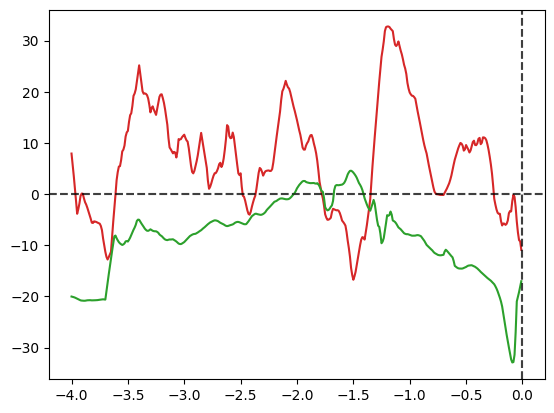

In [ ]:
ax = plt.subplot()
calc_avg_dx('PV95', is_strike=True, is_dev_speed=False, is_abs=False, exit_hole='left', ax=ax, line_color='tab:red', label='left exit', bug_speed=2);
calc_avg_dx('PV95', is_strike=True, is_dev_speed=False, is_abs=False, exit_hole='right', ax=ax, line_color='tab:green', label='right exit', bug_speed=2);

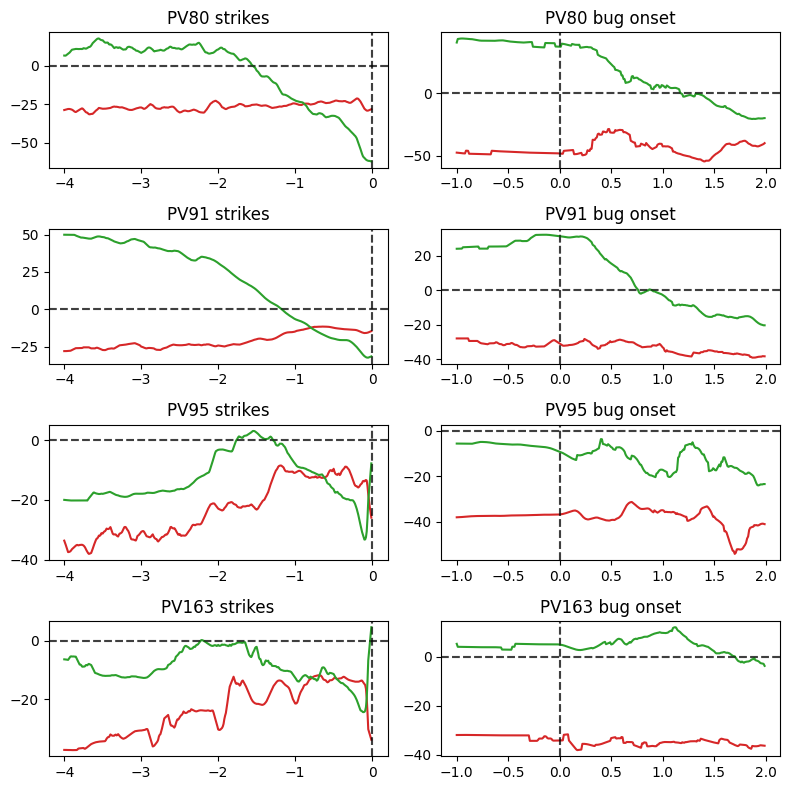

In [ ]:
animals2plot = ['PV80', 'PV91', 'PV95', 'PV163']
fig, axes = plt.subplots(len(animals2plot), 2, figsize=(8, 2*len(animals2plot)))
for i, animal_id in enumerate(animals2plot):
    calc_avg_dx(animal_id, is_strike=True, is_dev_speed=False, is_abs=False, exit_hole='left', ax=axes[i, 0], line_color='tab:red', label='left exit')
    calc_avg_dx(animal_id, is_strike=True, is_dev_speed=False, is_abs=False, exit_hole='right', ax=axes[i, 0], line_color='tab:green', label='right exit')
    axes[i, 0].set_title(f'{animal_id} strikes')
    calc_avg_dx(animal_id, is_strike=False, is_dev_speed=False, is_abs=False, exit_hole='left', ax=axes[i, 1], line_color='tab:red', label='left exit')
    calc_avg_dx(animal_id, is_strike=False, is_dev_speed=False, is_abs=False, exit_hole='right', ax=axes[i, 1], line_color='tab:green', label='right exit')
    axes[i, 1].set_title(f'{animal_id} bug onset')
    axes[i, 0].margins(x=0)
    axes[i, 1].margins(x=0)
fig.tight_layout()

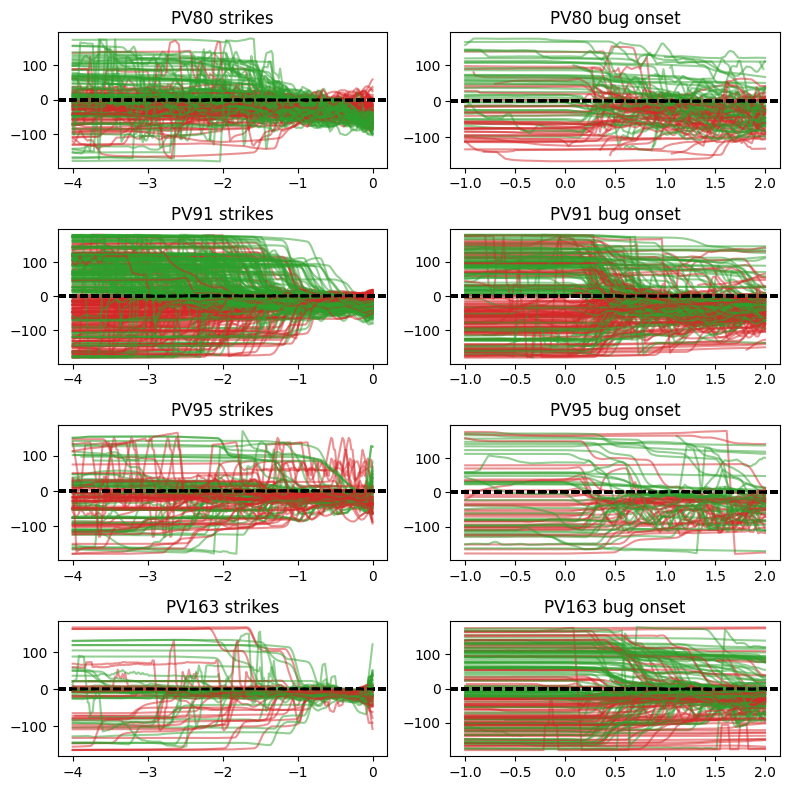

In [ ]:
np.random.seed(0)
animals2plot = ['PV80', 'PV91', 'PV95', 'PV163']
fig, axes = plt.subplots(len(animals2plot), 2, figsize=(8, 2*len(animals2plot)))
for i, animal_id in enumerate(animals2plot):
    for j, f in enumerate([load_angle_strike, load_angle_trial]):
        is_strike = j == 0
        indices = load_relevant_trials_or_strikes(animal_id, is_strikes=is_strike)
        # for ind in np.random.choice(indices, 20):
        for ind in indices:
            af, t_, bug_y, arena, exit_hole = f(animal_id, ind)
            first_bug_x = af.bug_x.dropna().iloc[0]
            times, dev_angles = [], []
            for k, row in af.iterrows():
                if not is_strike and any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
                    continue
                dev_ang = row.angle
                x, res = (row.nose_x, row.nose_y) if not is_strike else (row.x, row.y)
                if np.isnan(x) or np.isnan(res):
                    continue
                bug_x = (row.bug_x if not np.isnan(row.bug_x) else first_bug_x) * SCREEN_PIX_CM[arena]
                dev_ang, x_obs = calc_gaze_deviation_angle(dev_ang, bug_y, bug_x, x, res)
                times.append(row.total_sec) 
                dev_angles.append(dev_ang)
            dev_angles = savgol_filter(dev_angles, 5, 1, mode='nearest')
            axes[i, j].plot(times, dev_angles, alpha=0.5, color='tab:red' if exit_hole == 'left' else 'tab:green')
            axes[i, j].axhline(0, color='k', linestyle='--')
            axes[i, j].set_title(f"{animal_id} {'strikes' if is_strike else 'bug onset'}")

fig.tight_layout()

In [ ]:
from scipy.stats import friedmanchisquare, mannwhitneyu, wilcoxon
import scikit_posthocs as sp


dt = 1/60
t = np.arange(-1, 1+dt, dt)


def perm_test(x, y):
    def statistic_mean_diff(x, y, axis):
        return np.mean(x, axis=axis) - np.mean(y, axis=axis)

    res = permutation_test((x, y), statistic_mean_diff, vectorized=True)
    # plt.hist(res.null_distribution)
    return res.statistic, res.pvalue


def get_groups(first_x_id):
    return [(first_x_id-50, first_x_id-10, 'before prey onset', 'tab:cyan'), 
            (first_x_id+10, first_x_id+50, 'prey onset', 'tab:green'),]
            # (first_x_id+120, first_x_id+170, '2s-after prey onset', 'tab:gray')]


def get_angle_and_deriv(animal_id, trial_id, kernel=31, order=0):
    af = ocf[animal_id][trial_id].copy()
    first_x_id = af.bug_x.dropna().index[0]
    exit_hole = 'right' if af.bug_x.loc[first_x_id] < 300 else 'left'
    af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
    af['total_sec'] = af.total_sec - af.loc[first_x_id, 'total_sec']
    af = af.query(f'-1<=total_sec<=1').reset_index(drop=True)
    t_ = af.total_sec.values
    ang = af.angle.map(np.math.degrees)
    a = savgol_filter(ang.values, kernel, order, mode='nearest')
    w = savgol_filter(ang.values, kernel, order+1, deriv=1, delta=dt, mode='nearest')
    return t_, a, w, exit_hole


def plot_averaged_head_angle(animal_id, ax, is_legend=False, bug_speed=None, min_angle_diff=30):
    np.random.seed(0)
    delta = {'right': [], 'left': []}
    da_c, sm180 = 0, 0
    das = set()
    for trial_id, af in ocf[animal_id].items():
        if bug_speed and bug_speeds.get(trial_id) != bug_speed:
            continue
        if af.empty or af.bug_x.isna().all():
            continue

        t_, a, v, exit_hole = get_angle_and_deriv(animal_id, trial_id)
        da = a.max() - a.min()
        if (a<180).sum() == 0 or len(t_) != len(t): #da < min_angle_diff or
            if da < min_angle_diff:
                da_c += 1
                das.add(int(da))
            elif (a<180).sum() == 0:
                sm180 += 1
            else:
                len_t += 1
            continue
        
        delta[exit_hole].append(v)

    # print(f'da: {da_c}, sm180: {sm180}')
    min_side_counts = min([len(d) for d in delta.values()])
    curves = {}
    for side, color in [('left', 'tab:blue'), ('right', 'tab:orange')]:
        r = delta[side]
        n_orig = len(r)
        idx = np.random.choice(n_orig, min_side_counts, replace=False)
        r = np.vstack(r)[idx, :]
        r = np.nanmean(r, axis=0)
        entrance = 'left' if side == 'right' else 'right'
        ax.plot(t, r, label=f'enter {entrance}', color=color, linewidth=2)
        curves[side] = r

    first_x_id = np.argmin(np.abs(t))
    for i, j, group, color in get_groups(first_x_id):
        y0 = min([curves[side][i:j].min() for side in ['left', 'right']])
        y1 = max([curves[side][i:j].max() for side in ['left', 'right']])
        ax.add_patch(plt.Rectangle((t[i], y0), t[j]-t[i], y1-y0, color=color, alpha=0.4))

        g0 = np.hstack([np.nanmean(c[i:j]) for c in delta['left']])
        g1 = np.hstack([np.nanmean(c[i:j]) for c in delta['right']])
        s, pvalue = mannwhitneyu(g0, g1)
        # s, pvalue = ttest_ind(g0, g1, equal_var=False)
        print(f'Group={group}: U={s:.2f}, p={pvalue:.2f}')
        ax.text((t[i] + t[j])/2 + 0.09, y0-0.01, group.replace(' ', '\n'), va='top', ha='center')
        ax.text((t[i] + t[j])/2, y1+0.01, convert_pvalue_to_asterisks(pvalue), ha='center')

    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Angular Velocity [°/sec]')
    ax.axhline(0, color='k', linestyle='--')
    ax.axvline(0, color='k', linestyle='--')
    if is_legend:
        ax.legend()
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin*1.2, ymax*1.2)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax*1.05)
    ax.legend(prop={'size': 10})


def calc_head_angle_stats():
    df = []
    for animal_id, trials in ocf.items():
        for trial_id, af in trials.items():
            if af.empty or af.bug_x.isna().all():
                continue

            t_, a, v, exit_hole = get_angle_and_deriv(animal_id, trial_id)
            da = a.max() - a.min()
            if da < 30 or (a<180).sum() == 0 or len(t_) != len(t):
                continue
            first_x_id = np.argmin(np.abs(t))
            interest_groups = [(np.arange(i, j), group) for i,j,group,color in get_groups(first_x_id)]
            for idx, group in interest_groups:
                vf = pd.DataFrame(v[idx], columns=['angle'])
                vf['animal_id'] = animal_id
                vf['group'] = group
                vf['side'] = exit_hole
                df.append(vf)
    
    return pd.concat(df, ignore_index=True)


def plot_head_angle_stats(ax, zf=None):
    chosen_animals = ["PV91","PV163","PV80","PV95","PV52"]
    grp_colors = {t[2]: t[3] for t in get_groups(170)}
    groups = [c[2] for c in get_groups(170)]
    
    if zf is None:
        zf = calc_head_angle_stats()
    df = zf.query(f'animal_id in {chosen_animals}')
    sns.barplot(data=df, x="group", y="angle", hue="group", order=groups, estimator=np.nanmean, errorbar='se', ax=ax, legend=False, 
                palette=[grp_colors[g] for g in groups], alpha=0.5)
    ax.set_xlabel('')
    labels = [item.replace(' ', '\n') for item in groups]

    ax.set_xticks(np.arange(len(groups)), labels)

    # N = min([len(df.query(f'group=="{g}"').angle.dropna()) for g in groups])
    N = 10000
    data = [df.query(f'group=="{g}"').angle.dropna().sample(N, random_state=42).values for g in groups]
    s, pvalue = mannwhitneyu(data[0], data[1], alternative='greater')
    print(f'Mann-Whitney U: {s:.2f}, p-value: {pvalue:.3f}')

    # stat, p = friedmanchisquare(*data)
    # print(f'Friedman test: {stat:.2f}, p-value: {p:.3f}')
    # p_values = sp.posthoc_nemenyi_friedman(np.array(data).T)

    # for i, j, y in [(0, 1, 0.03), (0, 2, 0.08), (1, 2, 0.03)]:
    h_, y = 1, 10
    bar1 = ax.patches[0]
    bar2 = ax.patches[1]
    x1 = bar1._x0 + (bar1._width / 2)
    x2 = bar2._x0 + (bar1._width / 2)
    # pval = p_values.loc[i, j]
    ax.plot([x1, x1, x2, x2], [y, y + h_, y + h_, y], lw=1, c='k', alpha=0.5)
    ax.text((x1 + x2)/2, y + 1.4*h_, convert_pvalue_to_asterisks(pvalue), ha='center')

    mean_data = [[], []]
    for animal_id in chosen_animals:
        z = df.query(f'animal_id=="{animal_id}"').groupby('group').angle.mean().reindex(groups)
        ax.plot(np.arange(len(groups)), z.values, '.-', color='k', label=animal_id, alpha=0.5)
        for i in range(len(groups)):
            mean_data[i].append(z.values[i])
    statistic, pval = wilcoxon(*mean_data, alternative='greater')
    print(f"Wilcoxon signed-rank statistic: {statistic}, p-value: {pval:.3f}")

    ax.set_ylabel('Angular Velocity [°/sec]')
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax*1.1)


def calc_animals_stats_head_angle(zf):
    chosen_animals = ["PV91","PV163","PV80","PV95"]
    groups = [c[2] for c in get_groups(170)]

    N = 10000
    for animal_id in chosen_animals:
        print(animal_id)
        df = zf.query(f'animal_id == "{animal_id}"')
        data = [df.query(f'group=="{g}"').angle.dropna().sample(N, random_state=42).values for g in groups]
        # stat, p = friedmanchisquare(*data)
        # print(f'Friedman test: {stat:.2f}, p-value: {p:.3f}')
        # p_values = sp.posthoc_nemenyi_friedman(np.array(data).T)
        # for i, j in [(0, 1), (0, 2), (1, 2)]:
        #     print(f'p_value {groups[i]} - {groups[j]}: {p_values.loc[i, j]:.3f}')
        # print()


def plot_angle_histogram_before_bug(animal_id, ax):
    res = []
    for trial_id, af in ocf[animal_id].items():
        if af.empty or af.bug_x.isna().all():
            continue
        af = af.copy()
        first_x_id = af.bug_x.dropna().index[0]

        a = af.angle.map(lambda x: np.math.degrees(x)).copy()
        a = savgol_filter(a, 41, 0, mode='wrap')
        da = a.max() - a.min()
        if da < 30 or af.query(f'0<=angle<={np.pi}').empty:
            continue

        # v = af.angle.copy()
        m = a[first_x_id-10:first_x_id-1].mean()
        res.append(m)

    ax.hist(res, color='tab:cyan', bins=30)
    ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax.axvline(180, color='k', linestyle='--', alpha=0.5)
    ymin, ymax = ax.get_ylim()
    right_arrow, left_arrow = u'$\u2190$', u'$\u2192$'
    ax.text(90, ymax, f"Towards Screen", ha='center', va='top', fontsize=11)
    ax.set_xlabel('Head Angle [°]')


# plot_angle_histogram_before_bug('PV163', plt.subplot())
plot_averaged_head_angle('PV52', plt.subplot())
# plot_head_angle_stats(plt.subplot(), zf)

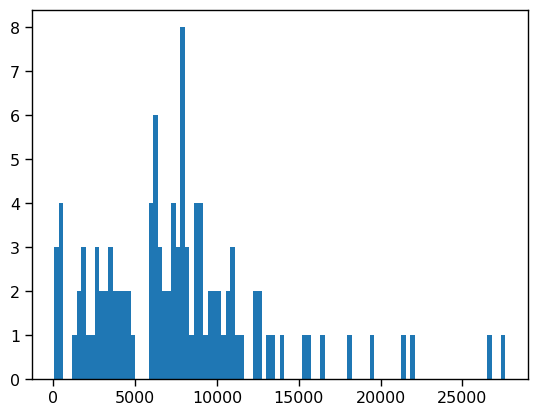

In [ ]:
def plot_sum_histogram(animal_id, threhsold=0.8):
    sums = []
    trials = load_relevant_trials_or_strikes(animal_id)
    for trial_id in trials:
        af, _, bug_y, arena, exit_hole = load_angle_trial(animal_id, trial_id)
        af = af.query('total_sec > 0')
        af = af.query(' and '.join([f'{bp}_prob>={threhsold}' for bp in ['nose', 'right_ear', 'left_ear']]))

        dev_angles = []
        for i, row in af.iterrows():
            ang = row.angle
            x, y = (row.nose_x, row.nose_y)
            bug_x = row.bug_x * SCREEN_PIX_CM[arena]
            if np.isnan(x) or np.isnan(y) or np.isnan(bug_x):
                continue

            dev_ang, x_obs = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
            dev_angles.append(dev_ang)

        w = savgol_filter(dev_angles, 11, 1, deriv=1, delta=1/60, mode='nearest')
        sums.append(np.abs(w).sum())
    plt.hist(sums, bins=100)

plot_sum_histogram('PV91')

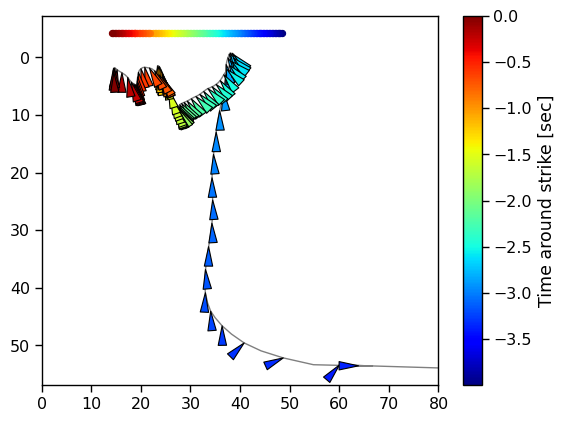

In [ ]:

def plot_traj_with_angles(animal_id, trial_id, ax=None, fig=None, threshold=0.8, is_strike=False):
    if ax is None:
        fig, ax = plt.subplots()
    
    f = load_angle_trial if not is_strike else load_angle_strike
    af, t_, bug_y, arena, _ = f(animal_id, trial_id)
    d = 0.1
    cmap = cm.get_cmap('jet')
    z = np.linspace(0, 1, len(t_))
    for i, row in af.iterrows():
        if i % 2:
            continue
        
        bug_x = row.bug_x * SCREEN_PIX_CM[arena]
        color = cmap(z[i])
        ax.scatter(bug_x, bug_y, color=color, marker='o', s=20)
        
        if not is_strike and any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
            continue
    
        ang = row.angle
        x, y = (row.nose_x, row.nose_y) if not is_strike else (row.x, row.y)
        ax.annotate('', (x, y), (x-d*np.cos(ang), y+d*np.sin(ang)), 
                    arrowprops=dict(width=0.3, headwidth=6, headlength=14, shrink=.1, facecolor=color, edgecolor='k'))
    
    if not is_strike:
        af = af.query(' and '.join([f'{bp}_prob>={threshold}' for bp in ['nose', 'right_ear', 'left_ear']]))
    x, y = (af.nose_x, af.nose_y) if not is_strike else (af.x, af.y)
    ax.plot(x, y, color='k', linewidth=1, alpha=0.5)
    ax.set_xlim([0, 80])
    ax.invert_yaxis()
    if fig is not None:
        fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(t_[0], t_[-1]), cmap=cmap), ax=ax, label='Time around strike [sec]')


# plot_traj_with_angles(animal_id_, trials_[0])
plot_traj_with_angles(animal_id_, strikes_[0], is_strike=True)

In [ ]:
cols = 4
n = min(cols * 25, len(trials_))
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, 4*rows))
axes = axes.flatten()
chosen_trials = np.random.choice(trials_, size=n, replace=False)
for i, (ax, ind) in enumerate(zip(axes, chosen_trials)):
    plot_traj_with_angles(animal_id_, ind, ax=ax, fig=fig if i==cols-1 else None)
    ax.set_title(ind)
fig.tight_layout()
fig.savefig(f'{FIGURE_PATH}/cache/head_angles_trials_onset.pdf', dpi=200, bbox_inches='tight')

In [ ]:
# trials 
n = 20
chosen_trials = np.random.choice(trials_, size=n, replace=False)
fig, axes = plt.subplots(n, 3, figsize=(16, n*4))
for i, ind in enumerate(chosen_trials):
    plot_traj_with_bug(animal_id_, ind, axes=axes[i, :], fig=fig)

In [ ]:
# strikes
n = 15
chosen_trials = np.random.choice(strikes_, size=n, replace=False)
fig, axes = plt.subplots(n, 3, figsize=(16, n*4))
for i, ind in enumerate(chosen_trials):
    plot_traj_with_bug(animal_id_, ind, axes=axes[i, :], fig=fig, is_strike=True)

ang=1.66
tan=11.43005230276132
coef:[  11.4300523  -104.30052303]


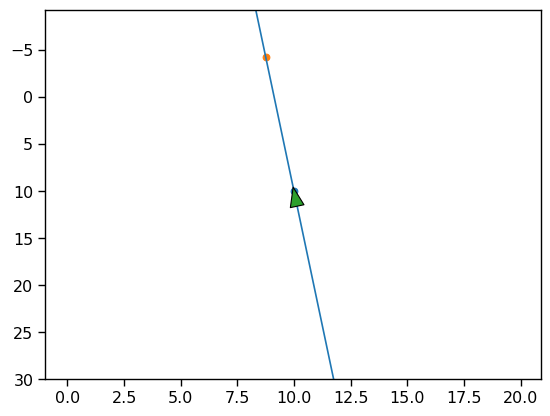

In [ ]:
dev_ang = np.radians(95)
print(f'ang={dev_ang:.2f}')
print(f'tan={np.tan(np.pi-dev_ang)}')
x, res = 10, 10
x1, y1 = x-np.cos(np.pi - dev_ang), res-np.sin(np.pi - dev_ang)
coefficients = np.polyfit([x, x1], [res, y1], 1)
print(f'coef:{coefficients}')
m_obs = np.tan(np.pi-dev_ang)
# m_obs = coefficients[0]

n_obs = res - m_obs*x
bug_y = SCREEN_Y_POS['reptilearn4']
x_obs = (bug_y - n_obs)/m_obs

x0 = np.arange(0, 20, 0.1)
plt.plot(x0, m_obs*x0+n_obs)

plt.annotate('', (x-0.5*np.cos(np.pi - dev_ang), res-0.5*np.sin(np.pi - dev_ang)), (x, res), 
                    arrowprops=dict(width=0.3, headwidth=10, headlength=14, shrink=.1, 
                                    facecolor='tab:green', edgecolor='k'))

plt.scatter(x, res, color='tab:blue')
plt.scatter(x_obs, bug_y, color='tab:orange')
plt.ylim([bug_y-5, 30])
# plt.xlim([0, 30])
plt.gca().invert_yaxis()

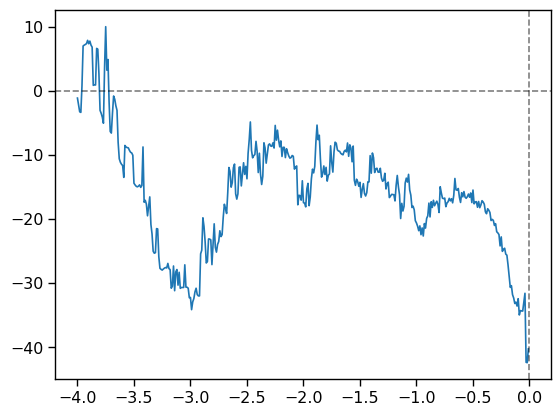

In [ ]:
def calc_avg_dx(animal_id, ax=None):
    res = []
    t = np.arange(-1, 1, 0.01)
    arena = 'msi-regev' if animal_id in ['PV80', 'PV42'] else 'reptilearn4'
    bug_y = SCREEN_Y_POS[arena]
    for trial_id, af in ocf[animal_id].items():
        first_x_id = af.bug_x.dropna().index[0]
        first_bug_x = af.loc[first_x_id, 'bug_x']
        exit_hole = 'right' if af.bug_x.loc[first_x_id] < 300 else 'left'
        af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
        af['total_sec'] = af.total_sec - af.loc[first_x_id, 'total_sec']
        af = af.query(f'-1<=total_sec<=1').reset_index(drop=True)
        t_ = af.total_sec.values
        dx = []
        for i, row in af.iterrows():
            ang = row.angle
            x, y = row.x, row.y
            bug_x = (row.bug_x if not np.isnan(row.bug_x) else first_bug_x) * SCREEN_PIX_CM[arena]
            a, _ = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
            dx.append(a)

        dx_ = np.interp(t, t_, dx)
        res.append(dx_)
    
    res = np.vstack(res)
    # res[np.abs(res) > 90] = np.nan
    res = np.nanmean(res, axis=0)
    # res = savgol_filter(res, 7, 0, mode='nearest')
    plt.plot(t, res)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)

def calc_avg_strike_dx(animal_id, ax=None):
    res = []
    t = np.arange(-4, 0, 0.01)
    arena = 'msi-regev' if animal_id in ['PV80', 'PV42'] else 'reptilearn4'
    bug_y = SCREEN_Y_POS[arena]
    for trial_id, af in sadf[animal_id].items():
        # first_x_id = af.bug_x.dropna().index[0]
        # first_bug_x = af.loc[first_x_id, 'bug_x']
        # exit_hole = 'right' if af.bug_x.loc[first_x_id] < 300 else 'left'
        af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
        af['total_sec'] = af.total_sec - af.total_sec.iloc[-1]
        af = af.query(f'-4<=total_sec<=0').reset_index(drop=True)
        t_ = af.total_sec.values
        dx = []
        for i, row in af.iterrows():
            ang = row.angle
            x, y = row.x, row.y
            bug_x = row.bug_x * SCREEN_PIX_CM[arena]
            # bug_x = (row.bug_x if not np.isnan(row.bug_x) else first_bug_x) * SCREEN_PIX_CM[arena]
            a, _ = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
            dx.append(a)

        dx_ = np.interp(t, t_, dx)
        res.append(dx_)
    
    res = np.vstack(res)
    res[np.abs(res) > 90] = np.nan
    res = np.nanmean(res, axis=0)
    # res = savgol_filter(res, 7, 0, mode='nearest')
    plt.plot(t, res)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)


# calc_avg_dx('PV91')
calc_avg_strike_dx('PV163')


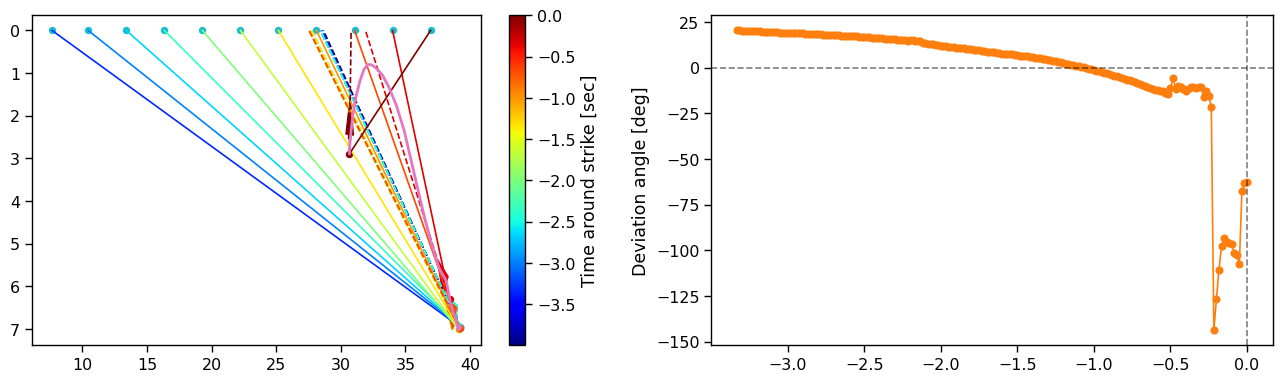

In [ ]:
def plot_strike_traj_with_bug(animal_id, trial_id, ax=None, kernel=31, order=0):
    if ax is None:
        fig, axes = plt.subplots(1,2, figsize=(13, 4))
        ax = axes[0]
    
    arena = 'msi-regev' if animal_id in ['PV80', 'PV42'] else 'reptilearn4'
    bug_y = SCREEN_Y_POS[arena]
    af = sadf[animal_id][trial_id].copy()
    af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
    af['total_sec'] = af.total_sec - af.total_sec.iloc[-1]
    af = af.query(f'-4<=total_sec<=0').reset_index(drop=True)
    t_ = af.total_sec.values
    d = 0.1
    cmap = cm.get_cmap('jet')
    z = np.linspace(0, 1, len(t_))
    dev_angs = []
    
    for i, row in af.iterrows():
        ang = row.angle
        x, y = row.x, row.y
        bug_x = row.bug_x * SCREEN_PIX_CM[arena]
        a, x_obs = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
        dev_angs.append((row.total_sec, a))

        if i % 20:  # np.abs(row.total_sec) > 0.1 and 
            continue

        color = cmap(z[i])
        ax.scatter(x, y, marker='o', s=20, color=color)
        ax.scatter(bug_x, 0, c='tab:cyan', marker='o', s=20)
        if ang < np.pi:
            ax.plot([x, x_obs], [y, 0], '--', color=color)
        ax.plot([x, bug_x], [y, 0], color=color)
        ax.arrow(x-d*np.cos(ang), y+d*np.sin(ang), d*np.cos(ang), -d*np.sin(ang), head_starts_at_zero=True, length_includes_head=False, width=0.2, 
                 color=color)
        
    ax.plot(af.x, af.y, color='tab:pink', linewidth=2)
    # ax.set_xlim([0, 60])
    # ax.set_ylim([-2, 30])
    ax.invert_yaxis()
    fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(t_[0], t_[-1]), cmap=cmap), ax=ax, label='Time around strike [sec]')

    dev_angs = np.vstack(dev_angs)
    axes[1].plot(dev_angs[:, 0], dev_angs[:, 1], '-o', color='tab:orange')
    axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].set_ylabel('Deviation angle [deg]')
    fig.tight_layout()


plot_strike_traj_with_bug('PV91', 2530, ax=None, kernel=31, order=0)

In [ ]:
sorted(sadf['PV91'].keys())

[2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 2641,
 2642,
 2643,
 2644,
 2645,
 2646,
 2647,
 2648,
 2649,
 2650,
 2651,
 2652,
 2653,
 2654,
 2655,
 2656,
 2657,
 2658,
 2659,
 4475,
 4476,
 4477,
 4478,
 4479,
 4480,
 4481,
 4482,
 4512,
 4513,
 4514,
 4568,
 4569,
 4570,
 4571,
 4572,

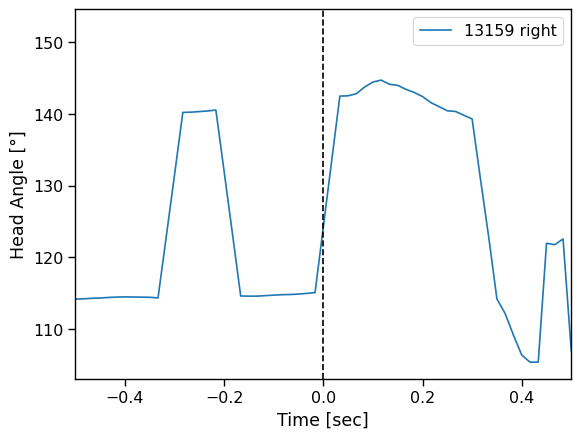

In [ ]:
plot_head_angle_examples(animal_id_, [13159], plt.subplot(), is_deriv=False, kernel=3)

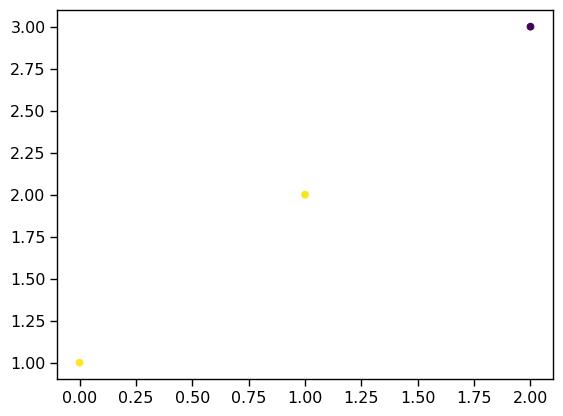

In [ ]:
cmap = cm.get_cmap('terrain')
color = [int(c*255) for c in to_rgb(cmap(0.5))]
plt.scatter([0,1,2], [1,2,3], c=color)

In [ ]:
def plot_head_angle_examples(animal_id, trials, ax, is_deriv=False, color='tab:blue', kernel=11):
    for trial_id in trials:
        t, a, v, exit_hole = get_angle_and_deriv(animal_id, trial_id, kernel=kernel)
        y = a if not is_deriv else v
        ax.plot(t, y, color=color, label=f'{trial_id} {exit_hole}')

    # ylims = ax.get_ylim()
    # ax.set_ylim([ylims[0], -ylims[0]])
    # plot_background_for_bug_onset(af, ax, t)
    # ax.axhline(0, linestyle='--', color='k', alpha=0.5)
    ax.axvline(0, color='k', linestyle='--')
    ax.set_ylabel('Angular Velocity [°/sec]' if is_deriv else 'Head Angle [°]')
    ax.set_xlabel('Time [sec]')
    ax.set_xlim(-0.5, 0.5)
    ax.legend()
    # if is_deriv:
    #     ax.set_xlim(-0.2, 0.5)
    # ax.text(-3, 0.1, 'Head Left', rotation=90, va='bottom', color='tab:blue')
    # ax.text(-3, -0.05, 'Head Right', rotation=90, va='top', color='tab:blue')




cols = 5
rows = int(np.ceil(len(trials_) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, 4*rows))
axes = axes.flatten()
for ax, ind in zip(axes, trials_):
    plot_head_angle_examples(animal_id_, [ind], ax, is_deriv=True, kernel=5)
    # ax.set_ylim([0, 180])
fig.tight_layout()

In [ ]:
zf = calc_head_angle_stats()

Group=before prey onset: U=24295.00, p=0.92
Group=prey onset: U=25734.00, p=0.24
Mann-Whitney U: 60425970.00, p-value: 0.000
Wilcoxon signed-rank statistic: 15.0, p-value: 0.031


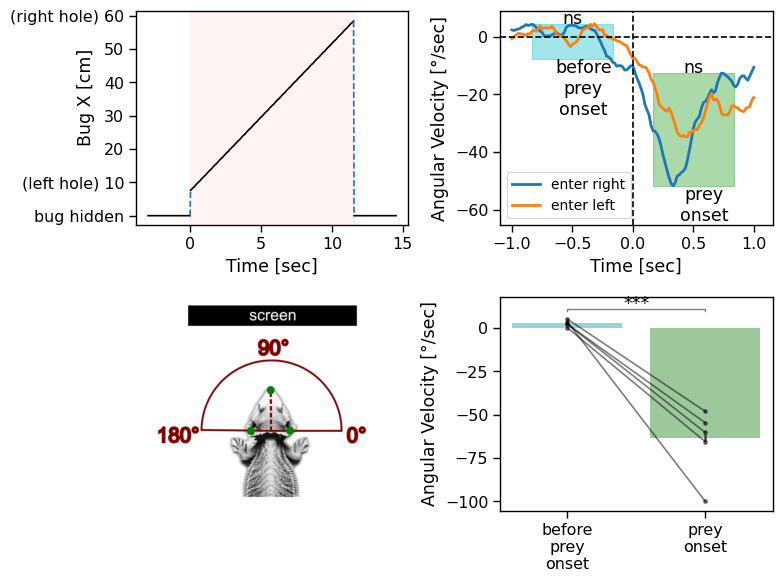

In [ ]:
bug_onset_color = 'mistyrose'
examples = {
    'right': [10993, 10740, 14061, 15041, 15064],
    'left': [10782, 10783, 10786, 10788, 10795]
}


def plot_background_for_bug_onset(af, ax, t):
    bug_appear_id = af.dropna(subset='bug_x').index[0]
    bug_disappear_id = af.dropna(subset='bug_x').index[-1]
    ylims = ax.get_ylim()
    ax.add_patch(plt.Rectangle((t[bug_appear_id], ylims[0]), 
                                t[bug_disappear_id] - t[bug_appear_id], 
                                ylims[1]-ylims[0], color=bug_onset_color, alpha=0.4))
    


def plot_figure6():
    example_animal = 'PV80'

    sns.set_context('paper', font_scale=1.3)
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    
    af = ocf['PV91'][10993].copy()
    af['bug_x'] = af.bug_x * SCREEN_PIX_CM['reptilearn4']
    af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
    bug_appear_id = af.dropna(subset='bug_x').index[0]
    bug_disappear_id = af.dropna(subset='bug_x').index[-1]
    af.loc[(af.bug_x.isna()) & (af.total_sec < af.loc[bug_appear_id, 'total_sec']), 'bug_x'] = 0
    af.loc[(af.bug_x.isna()) & (af.total_sec > af.loc[bug_disappear_id, 'total_sec']), 'bug_x'] = 0
    af.loc[bug_appear_id, 'bug_x'] = np.nan
    af.loc[bug_disappear_id, 'bug_x'] = np.nan
    t = af.total_sec - af.loc[bug_appear_id, 'total_sec']
    axes[0, 0].plot(t, af.bug_x, color='k')
    axes[0, 0].plot(t.loc[[(bug_appear_id-1),(bug_appear_id+1)]], af.loc[[(bug_appear_id-1),(bug_appear_id+1)], 'bug_x'], '--', color='tab:blue')
    axes[0, 0].plot(t.loc[[(bug_disappear_id-1),(bug_disappear_id+1)]], af.loc[[(bug_disappear_id-1),(bug_disappear_id+1)], 'bug_x'], '--', color='tab:blue')

    # axes[0, 0].plot(af.loc[[(bug_appear_id-1),(bug_appear_id+1)], 'total_sec'], af.loc[[(bug_appear_id-1),(bug_appear_id+1)], 'bug_x'], '--', color='tab:blue')
    # axes[0, 0].plot(af.loc[[(bug_disappear_id-1),(bug_disappear_id+1)], 'total_sec'], af.loc[[(bug_disappear_id-1),(bug_disappear_id+1)], 'bug_x'], '--', color='tab:blue')
    axes[0, 0].set_yticks(np.arange(0, 70, 10), ['bug hidden', '(left hole) 10', '20', '30', '40', '50', '(right hole) 60'])
    ylims = axes[0, 0].get_ylim()
    axes[0, 0].add_patch(plt.Rectangle((t.loc[bug_appear_id], ylims[0]), 
                                    t.loc[bug_disappear_id] - t.loc[bug_appear_id], 
                                    ylims[1]-ylims[0], color=bug_onset_color, alpha=0.4))
    axes[0, 0].set_ylabel('Bug X [cm]')
    axes[0, 0].set_xlabel('Time [sec]')
    axes[0, 0].yaxis.set_label_coords(-0.15, 0.6)

    plot_averaged_head_angle(example_animal, axes[0, 1])
    plot_head_angle_stats(axes[1, 1], zf)

    img = cv2.imread('../notebooks/figures/assets/head_angle_demonstration.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, 0].imshow(img, aspect='equal')
    axes[1, 0].axis('off')

    fig.tight_layout()
    fig.savefig('../notebooks/arena_figures/head_angles.pdf', dpi=250)


plot_figure6()

In [ ]:
# af = ocf[animal_id][trial_id].copy()
#     first_x_id = af.bug_x.dropna().index[0]
#     exit_hole = 'right' if af.bug_x.loc[first_x_id] < 300 else 'left'

cnts = {'left': 0, 'right': 0}
vals = {'left': set(), 'right': set()}
for ind, af in ocf['PV91'].items():
    if af.empty or af.bug_x.isna().all():
        continue
    first_x_id = af.bug_x.dropna().index[0]
    exit_hole = 'right' if af.bug_x.loc[first_x_id] < 300 else 'left'
    cnts[exit_hole] += 1
    vals[exit_hole].add(int(af.bug_x.loc[first_x_id]))

cnts
# vals

{'left': 897, 'right': 156}

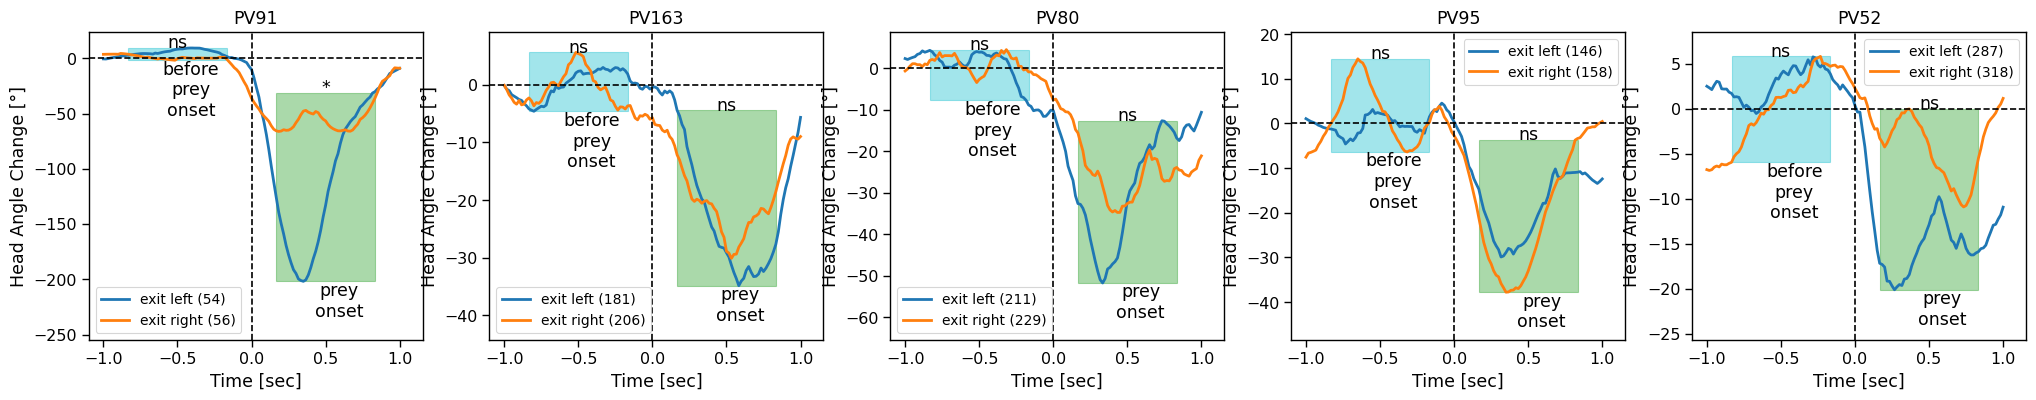

In [ ]:
chosen_animals = ["PV91","PV163","PV80","PV95","PV52"]
fig, axes = plt.subplots(1, len(chosen_animals), figsize=(25, 4))
for i, animal_id in enumerate(chosen_animals):
    plot_averaged_head_angle(animal_id, axes[i])
    axes[i].set_title(animal_id)

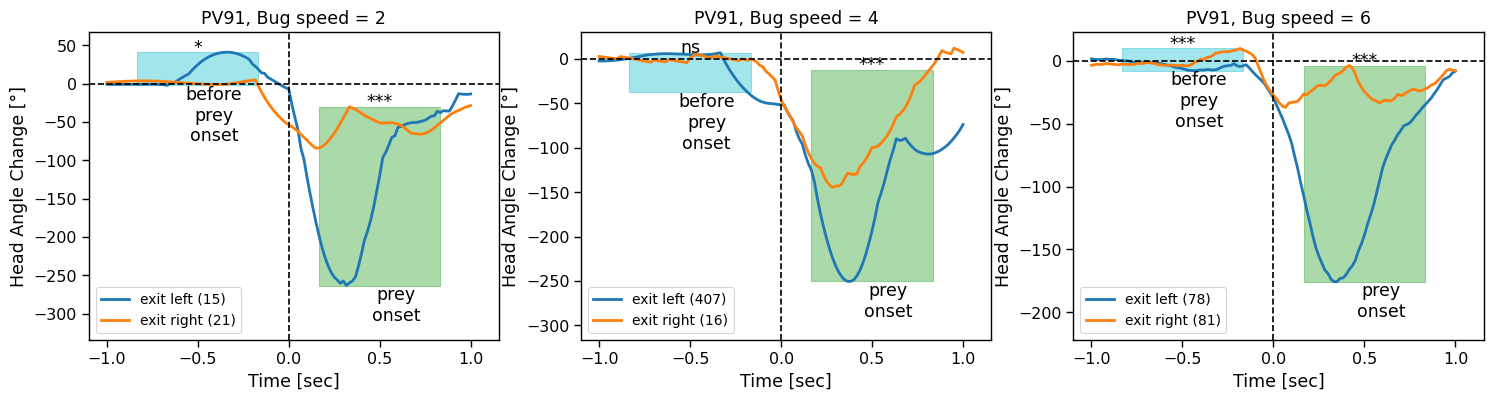

In [ ]:
speeds = [2, 4, 6]
animal_id = 'PV91'
fig, axes = plt.subplots(1, len(speeds), figsize=(18, 4))
for i, bs in enumerate(speeds):
    plot_averaged_head_angle(animal_id, axes[i], bug_speed=bs)
    axes[i].set_title(f'{animal_id}, Bug speed = {bs}')

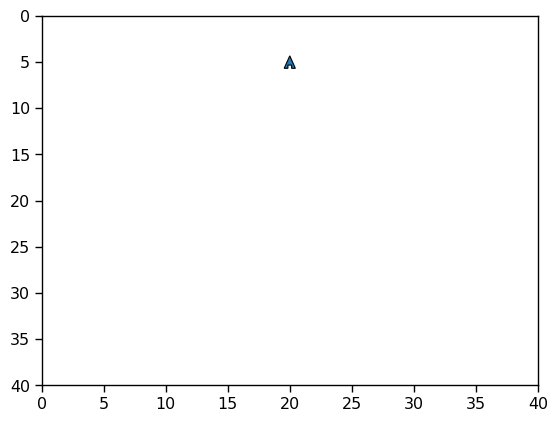

In [ ]:
dev_ang = np.radians(90)
x, res = 20, 5
arrow_len = 1
plt.arrow(x-arrow_len*np.cos(dev_ang), res+arrow_len*np.sin(dev_ang), arrow_len*np.cos(dev_ang), -arrow_len*np.sin(dev_ang), head_starts_at_zero=True, length_includes_head=True, width=0.3)
plt.xlim([0, 40])
plt.ylim([0, 40])
# plt.axvline(x, color='k', linestyle='--')
# plt.axhline(y, color='k', linestyle='--')
plt.gca().invert_yaxis()

In [ ]:
np.radians(180)

3.141592653589793

In [ ]:
calc_animals_stats_head_angle(zf)

PV91
Friedman test: 835.06, p-value: 0.000
p_value before bug approach - bug approach: 0.001
p_value before bug approach - 2s-after bug approach: 0.001
p_value bug approach - 2s-after bug approach: 0.001

PV163
Friedman test: 120.79, p-value: 0.000
p_value before bug approach - bug approach: 0.001
p_value before bug approach - 2s-after bug approach: 0.001
p_value bug approach - 2s-after bug approach: 0.001

PV80
Friedman test: 53.39, p-value: 0.000
p_value before bug approach - bug approach: 0.001
p_value before bug approach - 2s-after bug approach: 0.001
p_value bug approach - 2s-after bug approach: 0.166

PV95
Friedman test: 32.13, p-value: 0.000
p_value before bug approach - bug approach: 0.001
p_value before bug approach - 2s-after bug approach: 0.788
p_value bug approach - 2s-after bug approach: 0.001



In [ ]:
dev_ang = af.angle.map(np.math.degrees)
    dev_angs_speed = dev_ang.diff()
    dev_angs_speed = savgol_filter(dev_angs_speed, 51, 0)
    axes[0, 1].plot(t, dev_angs_speed, color='k')
    ylims = axes[0, 1].get_ylim()
    axes[0, 1].set_ylim([ylims[0], -ylims[0]])
    ylims = axes[0, 1].get_ylim()
    axes[0, 1].add_patch(plt.Rectangle((t.loc[bug_appear_id], ylims[0]), 
                                    t.loc[bug_disappear_id] - t.loc[bug_appear_id], 
                                    ylims[1]-ylims[0], color=bug_onset_color, alpha=0.4))
    axes[0, 1].axhline(0, linestyle='--', color='k', alpha=0.5)
    axes[0, 1].set_ylabel('Head Angle Change [°]')
    axes[0, 1].set_xlabel('Time [sec]')
    axes[0, 1].text(-3, 0.1, 'Head Left', rotation=90, va='bottom', color='tab:blue')
    axes[0, 1].text(-3, -0.05, 'Head Right', rotation=90, va='top', color='tab:blue')

    ax2 = axes[0, 1].twinx()
    ax2_color = 'tab:orange'
    ax2.plot(t, dev_ang, color=ax2_color)
    yticks = ax2.get_yticks()
    ax2.set_yticks(yticks, [f'{t:.0f}°' if i not in [0, 3, len(yticks)-1] else '' for i, t in enumerate(yticks)])
    ax2.tick_params(axis='y', labelcolor=ax2_color, direction="in", pad=-22)

1.7561137698444444

In [ ]:
af.query(f'0<=angle<={np.pi}').empty

False

In [ ]:
n = 100
cols = 6
kernel = 11
order = 1
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, rows*4))
axes = axes.flatten()
i = 0
for ind, af in ocf['PV91'].items():
    try:
        first_x_id = af.bug_x.dropna().index[0]
        exit_hole = 'right' if af.bug_x.loc[first_x_id] < 300 else 'left'
        af['total_sec'] = (af.datetime - af.datetime.iloc[0]).dt.total_seconds()
        dev_ang = af.angle.map(np.math.degrees)
        dev_ang = savgol_filter(dev_ang.values, kernel, order)
        if exit_hole != 'right' or dev_ang[first_x_id] > 180 or dev_ang[first_x_id] < 90:
            continue
        da = dev_ang.max() - dev_ang.min()
        if da < 45 or af.query(f'0<=angle<={np.pi}').empty:
            continue
        # w = np.diff(a)
        dev_angs_speed = savgol_filter(dev_ang.values, kernel, order, deriv=1, delta=0.016)
        
        axes[i].plot(af.total_sec, dev_angs_speed, color='k')
        axes[i].axvline(af.loc[first_x_id, 'total_sec'], linestyle='--', color='k', alpha=0.5)
        axes[i].set_title(f'{ind} - {exit_hole} - {da:.1f}')
        ax2 = axes[i].twinx()
        ax2.plot(af.total_sec, dev_ang, color='tab:orange')
        i += 1
        if i >= n:
            break
    except Exception:
        continue
fig.tight_layout()

In [ ]:
dev_ang.diff()

0           NaN
1      0.029049
2      0.000792
3      0.021981
4      0.010643
         ...   
788   -0.009673
789   -0.024648
790    0.120636
791    0.040052
792    0.067149
Name: angle, Length: 793, dtype: float64

In [ ]:
len(dev_angs_speed)

793

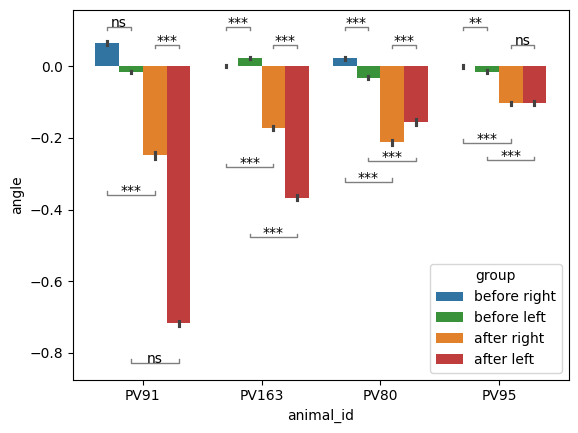

In [ ]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


ax = plt.subplot()
chosen_animals = ["PV91", "PV163", "PV80", "PV95"]
groups = ['before bug approach', 'bug approach', '2s after bug approach']
df_ = zf.query(f'animal_id in {chosen_animals}')
sns.barplot(data=df_, x="animal_id", y="angle", hue="group", estimator=np.nanmean, errorbar='se', order=chosen_animals,
            hue_order=groups, palette=['tab:blue','tab:green','tab:orange', 'tab:red'], ax=ax)

h = 0.01
for animal_id in chosen_animals:
    prev_y = []
    for group1, group2, res in [('before right', 'before left', 0.1), ('after right', 'after left', 0.1), ('before right', 'after right', -0.6), ('before left', 'after left', -0.8)]:
        g1 = df_.query(f'animal_id=="{animal_id}" and group=="{group1}"').angle.values
        g2 = df_.query(f'animal_id=="{animal_id}" and group=="{group2}"').angle.values
        t, pval = ttest_ind(g1, g2, equal_var=False)
        bar1 = ax.containers[groups.index(group1)].patches[chosen_animals.index(animal_id)]
        bar2 = ax.containers[groups.index(group2)].patches[chosen_animals.index(animal_id)]
        j = bar1._x0 + (bar1._width / 2)
        x2 = bar2._x0 + (bar2._width / 2)
        h_ = (-1) * h if res < 0 else h
        if res < 0:
            res = max(abs(bar1._height), abs(bar2._height)) * (-1) - 0.1
        if any([abs(res - y_) < 0.01 for y_ in prev_y]):
            res -= 0.05
        prev_y.append(res)
        ax.plot([j, j, x2, x2], [res, res + h_, res + h_, res], lw=1, c='k', alpha=0.5)
        ax.text((j + x2)/2, res + h_, convert_pvalue_to_asterisks(pval), ha='center')

# for group, cont in zip(groups, ax.containers):
#     for animal_id, bar in zip(chosen_animals, cont.patches):
#         v = df.query(f'animal_id=="{animal_id}" and group=="{group}"').angle.values
#         y0 = np.nanmean(v)
#         ax.text(bar._x0, bar._height, animal_id, fontsize=6)
#         i +=1 

In [ ]:
N 

355320

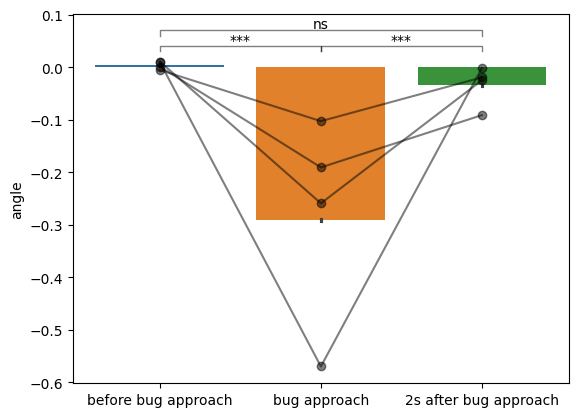

In [ ]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp


def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


ax = plt.subplot()
chosen_animals = ["PV91","PV163","PV80","PV95"]
groups = ['before bug approach', 'bug approach', '2s after bug approach']
df_ = zf.query(f'animal_id in {chosen_animals}')
sns.barplot(data=df_, x="group", y="angle", hue="group", order=groups, estimator=np.nanmean, errorbar='se', ax=ax, legend=False)
ax.set_xlabel('')

# N = min([len(df.query(f'group=="{g}"').angle.dropna()) for g in groups])
N = 10000
data = [df_.query(f'group=="{g}"').angle.dropna().sample(N, random_state=42).values for g in groups]
stat, p = friedmanchisquare(*data)
p_values = sp.posthoc_nemenyi_friedman(np.array(data).T)

h_ = 0.01
for i, j, res in [(0, 1, 0.03), (0, 2, 0.06), (1, 2, 0.03)]:
    bar1 = ax.patches[i]
    bar2 = ax.patches[j]
    j = bar1._x0 + (bar1._width / 2)
    x2 = bar2._x0 + (bar2._width / 2)
    pval = p_values.loc[i, j]
    ax.plot([j, j, x2, x2], [res, res + h_, res + h_, res], lw=1, c='k', alpha=0.5)
    ax.text((j + x2)/2, res + 1.4*h_, convert_pvalue_to_asterisks(pval), ha='center')

for animal_id in chosen_animals:
    z = df_.query(f'animal_id=="{animal_id}"').groupby('group').angle.mean().reindex(groups)
    ax.plot(np.arange(len(groups)), z.values, '-o', color='k', label=animal_id, alpha=0.5)

ax.set_ylabel('Angle Change [deg]')

In [ ]:
z

group
before bug approach     -0.005234
bug approach            -0.102656
2s after bug approach   -0.019308
Name: angle, dtype: float64

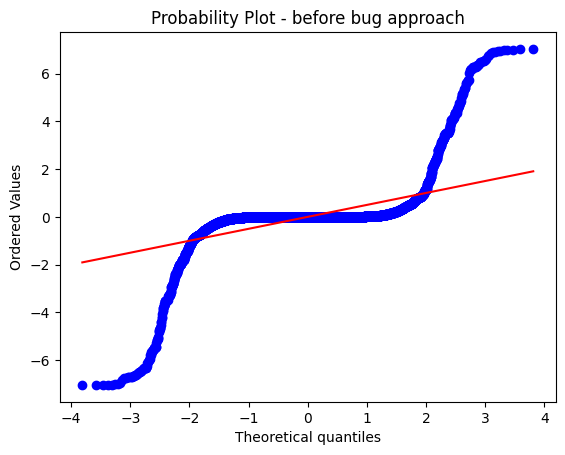

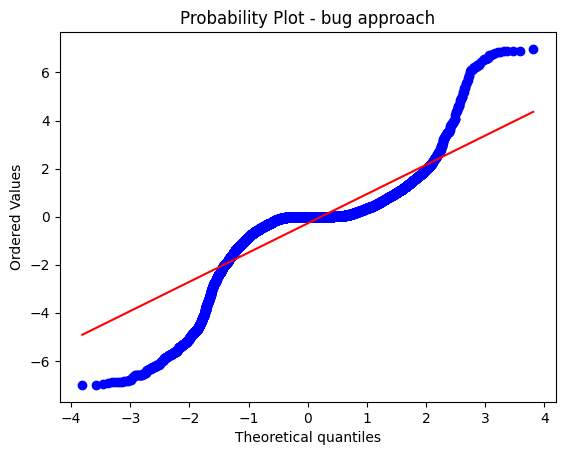

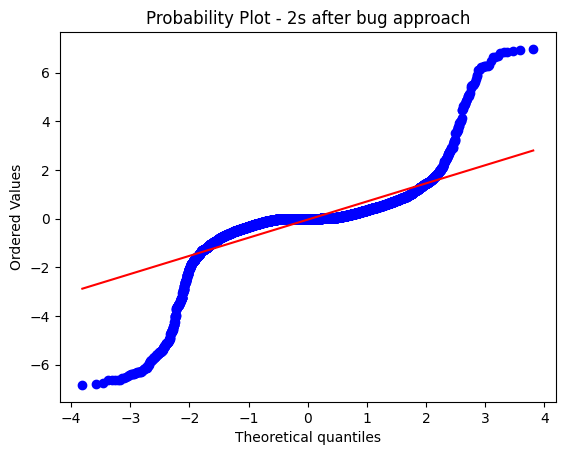

In [ ]:
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt

# unique_majors = df['group'].unique()
N = 10000
data = [df_.query(f'group=="{g}"').angle.dropna().sample(N).values for g in groups]
for major, group in zip(data, groups):
    stats.probplot(major, dist="norm", plot=plt)
    plt.title("Probability Plot - " +  group)
    plt.show()

In [ ]:
from scipy import stats

stats.ttest_ind(zf.query('animal_id=="PV80" and group=="before"').angle.dropna().values, zf.query('animal_id=="PV80" and group=="after"').angle.dropna().values, alternative='greater')

Ttest_indResult(statistic=29.121323759532363, pvalue=2.5885614412085232e-186)

In [ ]:
first_x_id + 60 > len(v)

SyntaxError: illegal target for annotation (2132402646.py, line 1)

In [ ]:
af.loc[[(bug_appear_id-1),(bug_appear_id+1)], 'bug_x']

178       NaN
180    1702.0
Name: bug_x, dtype: float64

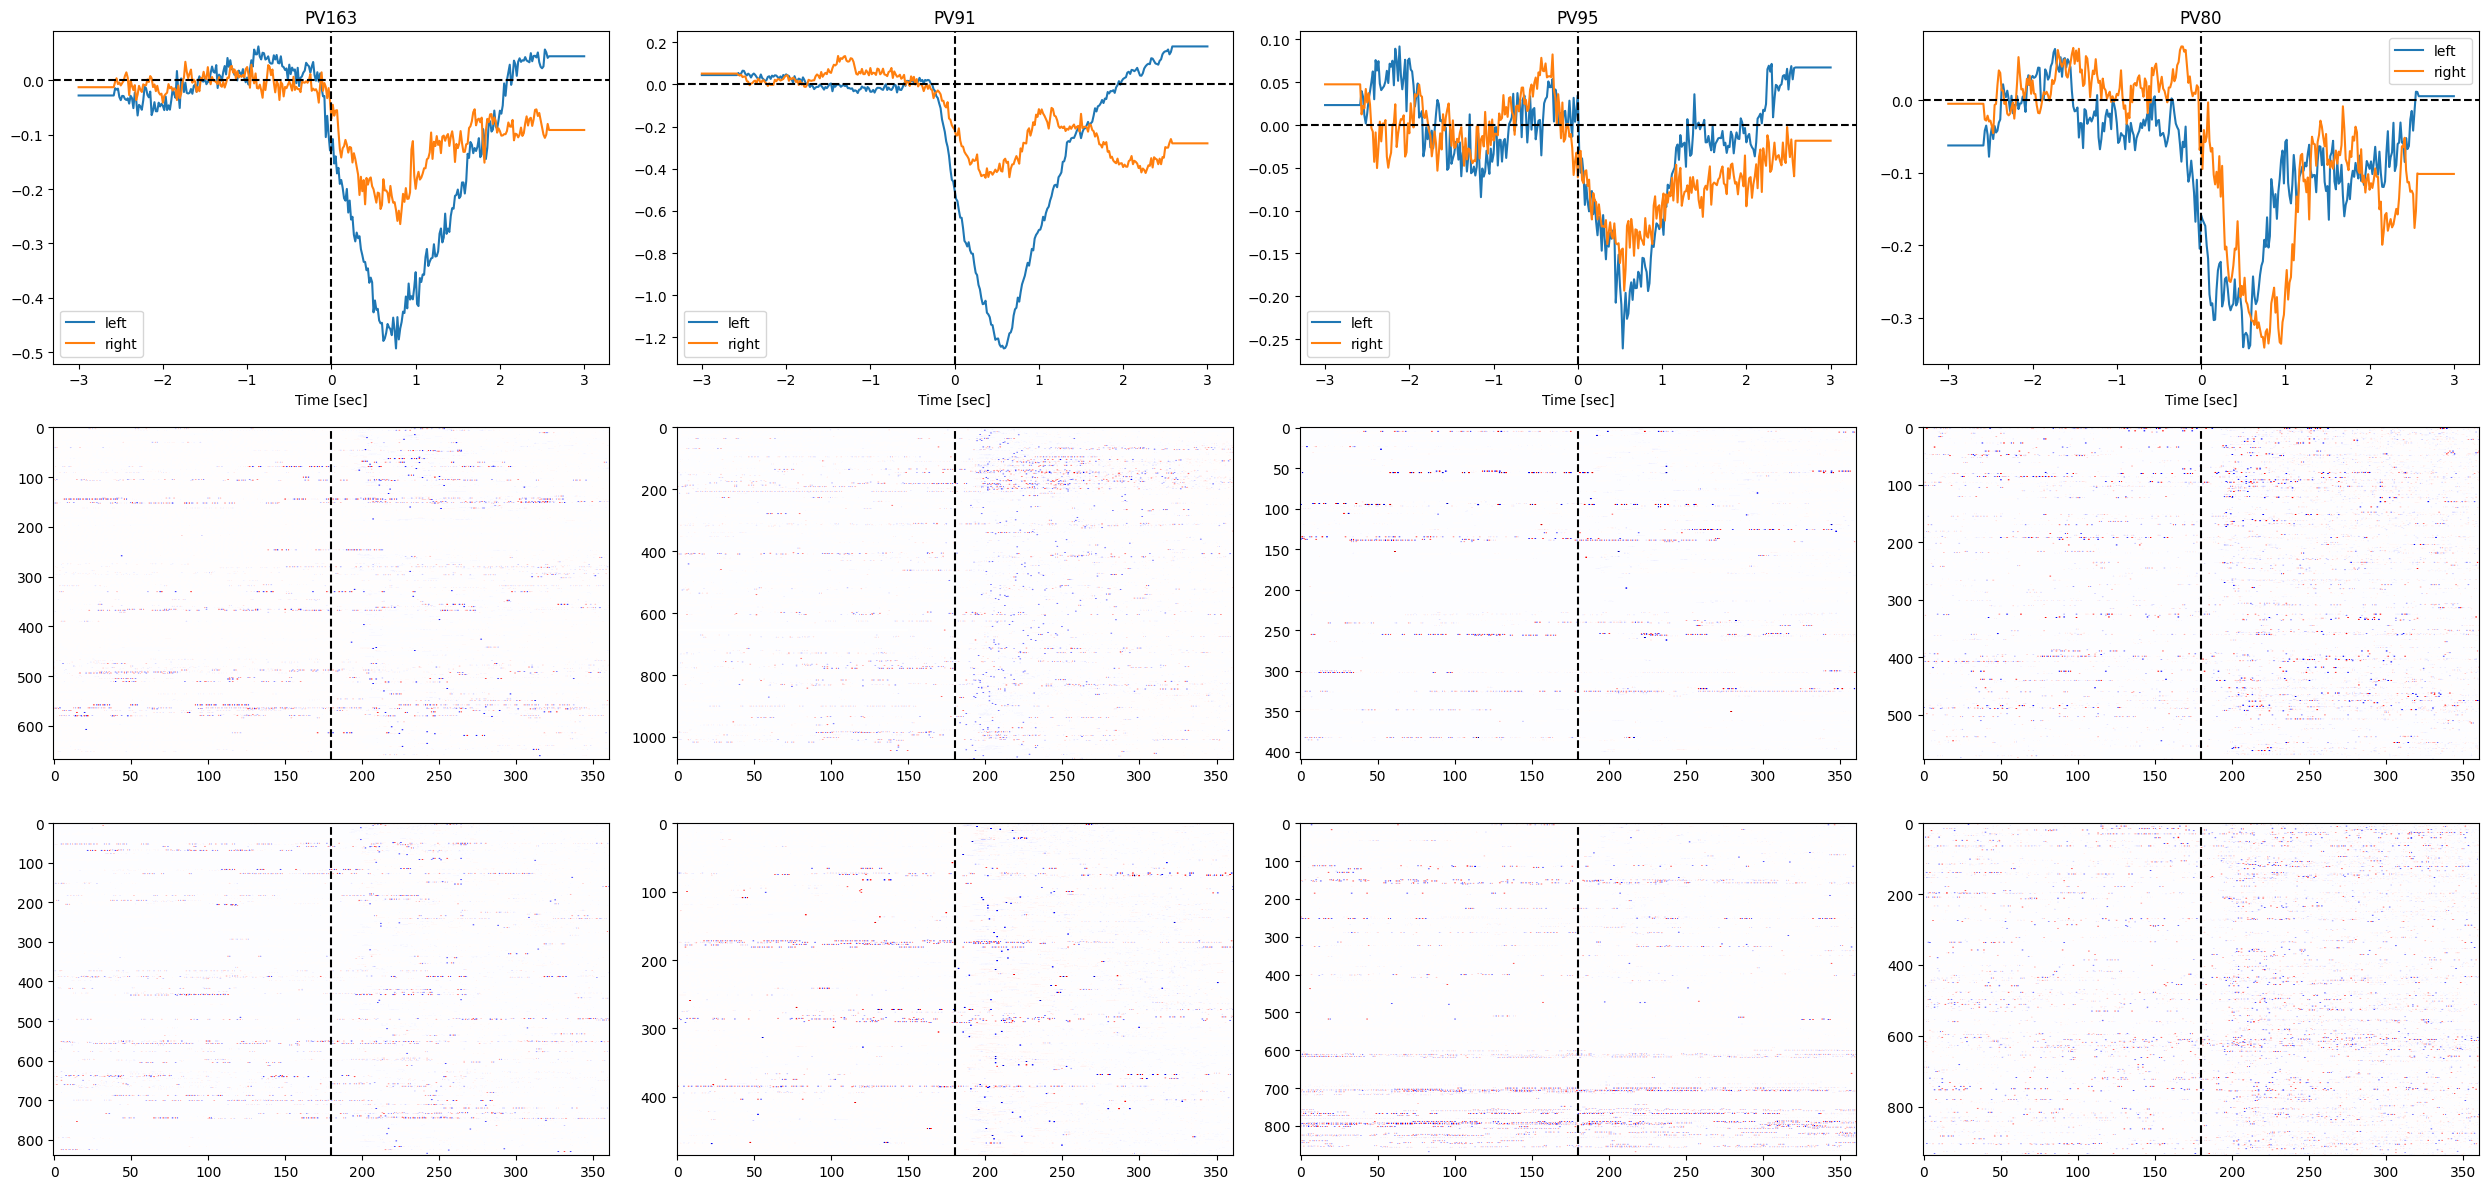

In [ ]:
offset = 180
rows = 3
chosen_animals = ['PV163', 'PV91', 'PV95', 'PV80']
fig, axes = plt.subplots(rows, len(chosen_animals), figsize=(25, 4*rows))
i = 0
for animal_id in chosen_animals:
    delta = {'right': [], 'left': []}
    angles = {'right': [], 'left': []}
    for ind, af in ocf[animal_id].items():
        if af.empty or af.bug_x.isna().all():
            continue
        af = af.copy()
        first_x_id = af.bug_x.dropna().index[0]
        exit_hole = 'right' if af.bug_x.loc[first_x_id] < 300 else 'left'
        v = af.angle.copy()
        v = v.diff().apply(lambda x: np.math.degrees(x))
        
        v = v.iloc[first_x_id-180:first_x_id+180+1].values
        if len(v) == 2*offset + 1:
            delta[exit_hole].append(v)
            angles[exit_hole].append(af.angle.iloc[first_x_id-180:first_x_id+180+1].values)

    j = 1
    dt = 1/60
    t = np.arange(-offset*dt, offset*dt+dt, dt)
    for side in ['left', 'right']:
        r = delta[side]
        r = np.nanmean(np.vstack(r), axis=0)
        r = savgol_filter(r, 51, 0)
        axes[0, i].plot(t, r, label=side)

        dev_ang = np.vstack(delta[side])
        axes[j, i].imshow(dev_ang, aspect='auto', cmap='seismic')
        axes[j, i].axvline(offset, color='k', linestyle='--')
        j += 1

    axes[0, i].set_title(f'{animal_id}')
    axes[0, i].set_xlabel('Time [sec]')
    axes[0, i].axhline(0, color='k', linestyle='--')
    axes[0, i].axvline(t[offset], color='k', linestyle='--')
    axes[0, i].legend()
    i += 1
fig.tight_layout()

  0%|          | 0/2061 [00:00<?, ?it/s]

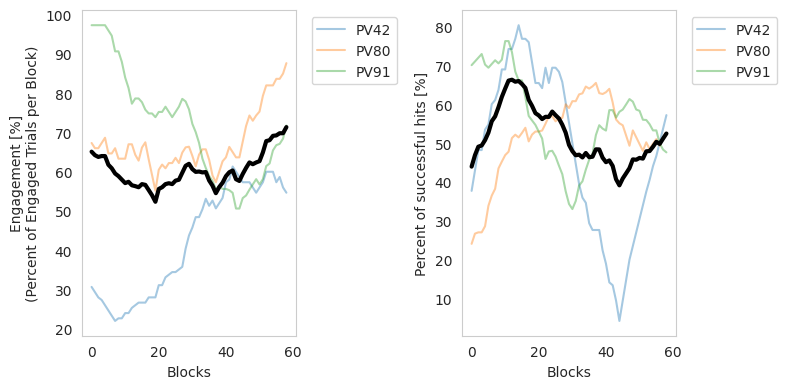

In [ ]:
def load_engagement():
    eng_ = []
    with orm.session() as s:
        exps = s.query(Experiment).filter(
            Experiment.arena.in_(['reptilearn4', 'msi-regev']),
            Experiment.animal_id.not_in(BAD_ANIMALS),
            Experiment.animal_id.startswith('PV'),
            # Experiment.start_time > '2023-04-18'
        ).all()
        for exp in tqdm(exps):
            for blk in exp.blocks:
                if blk.movement_type in ['jump_up']:
                    continue
                if len(blk.strikes) < 2:
                    continue
                for tr in blk.trials:
                    trial_dict = {'trial_id': tr.id, 'animal_id': exp.animal_id, 'time': tr.start_time, 
                                  'is_strike': len(tr.strikes) > 0,
                                  'block_id': blk.id, 'bug_speed': blk.bug_speed}
                    
                    trial_dict['avg_miss'] = np.nanmean([np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) 
                                                         for strk in tr.strikes]) if tr.strikes else None
                    trial_dict['n_hits'] = sum([strk.is_hit for strk in tr.strikes])
                    trial_dict['n_strikes'] = len(tr.strikes)
                    eng_.append(trial_dict)

    eng_ = pd.DataFrame(eng_)
    eng_['day'] = eng_.time.dt.floor('d').copy()
    for animal_id in eng_.animal_id.unique():
        af_ = eng_.query(f'animal_id=="{animal_id}"')
        first_day = af_.day.sort_values().iloc[0]
        eng_.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
    return eng_


def plot_engagement(eng, n_trials=50, start_block=10):
    animals2drop = ['PV85', 'PV97', 'PV148']
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    g = eng.groupby(['animal_id', 'block_id']).is_strike.agg(['sum', 'count']).reset_index()
    g['engagement'] = (g['sum'] / g['count']) * 100
    avg = []
    for animal_id in g.animal_id.unique():
        if animal_id in animals2drop:
            continue
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['engagement'] = savgol_filter(g_.engagement, window_length=15, polyorder=0, mode='nearest')
        y = g_['engagement'].iloc[start_block:].values
        blocks = np.arange(len(y))
        axes[0].plot(blocks, y, label=animal_id, alpha=0.4)
        avg.append(y)
    
    # random
    x = np.arange(len(y))
    # for m, q, n in [(1.6, 0.009, 25), (1.4, 0.03, 33)]:
    #     y = m*x + np.random.normal(0,1,len(x)) + n
    #     ch = np.random.choice(x[:-20])
    #     y[ch:ch+20] = y[ch:ch+20] - q*np.arange(20) ** 2 
    #     ax.plot(x, y, label=f'PV{m}'.replace('.', ''), alpha=0.4)
    #     avg.append(y)
    
    axes[0].plot(x, np.vstack(avg).mean(axis=0), color='k', linewidth=3)
    axes[0].grid(False)
    axes[0].set_xlabel('Blocks')
    axes[0].set_ylabel('Engagement [%]\n(Percent of Engaged Trials per Block)')
    axes[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    
    # g = eng.query('is_strike').groupby(['animal_id', 'block_id']).agg({'avg_miss_y': np.nanmean}).reset_index()
    g = eng.query('is_strike').groupby(['animal_id', 'block_id']).agg({'n_hits': np.nansum, 'n_strikes': np.nansum}).reset_index()
    g['accuracy'] = (g['n_hits'] / g['n_strikes']) * 100
    avg = []
    for animal_id in g.animal_id.unique():
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if animal_id in animals2drop:
            continue
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['accuracy'] = savgol_filter(g_.accuracy, window_length=19, polyorder=0, mode='nearest')
        y = g_['accuracy'].iloc[start_block:].values
        blocks = np.arange(len(y))
        axes[1].plot(blocks, y, label=animal_id, alpha=0.4)
        avg.append(y)
        
    x = np.arange(len(y))
    axes[1].plot(x, np.vstack(avg).mean(axis=0), color='k', linewidth=3)
    axes[1].grid(False)
    axes[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    axes[1].set_xlabel('Blocks')
    axes[1].set_ylabel('Percent of successful hits [%]')
    
    fig.tight_layout()
    fig.savefig('../notebooks/arena_figures/engagement.pdf', dpi=250)

eng0 = load_engagement()
plot_engagement(eng0, start_block=1, n_trials=60)

In [ ]:
cols = 10
rows = int(np.ceil(len(idx) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, 3*rows))
axes = axes.flatten()
for i, (ind, r) in enumerate(idx.items()):
    try:
        t = r[0] - r[0][0]
        traj = -r[2].copy()
        traj = (traj - traj.min()) / (traj.max() - traj.min())
        idx = np.where(np.diff(r[2]) < -10)[0]
        if len(idx) > 0:
            traj[np.arange(idx[-1])] = traj[idx[-1]]
        
        axes[i].plot(t, traj)
        axes[i].set_title(str(ind))
    except Exception as exc:
        print(exc)
fig.tight_layout()

In [ ]:
plt.plot(r[0], r[2])
idx = np.where(np.diff(r[2]) < -10)[0]
plt.scatter(r[0][idx], r[2][idx], c='red')

In [ ]:
matrices = {}
for strike_id, r in idx.items():
    fig = plt.figure()
    plt.axis('off')
    plt.plot(r[0], r[2], color='black', antialiased=False, linewidth=1)
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,)).copy()
    plt.close(fig)
    data[data==0] = 1
    data[data==255] = 0
    matrices[strike_id] = data

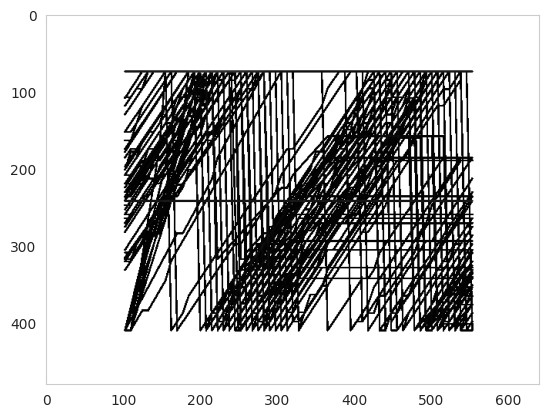

In [ ]:
m = np.sum(list(matrices.values()), 0)
m[m==0] = 255
plt.imshow(m)

In [ ]:
fig.canvas.

In [ ]:
n = 20
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for ind in list(idx.keys())[::-1]:
  res_ = idx[ind]
  if i >= n:
    continue
  axes[i, 0].set_ylabel(str(ind))
  for r in res_:
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
  i += 1

In [ ]:
with orm.session() as s:
    orm_res = s.query(Video, Block, Experiment).join(
      Block, Block.id == Video.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.animal_id == 'PV91',
        Video.cam_name == 'front'
    ).all()

In [ ]:
dlc = DLCArenaPose(cam_name='front', orm=orm)
idx = {}
days = set()
for vid, _, _ in tqdm(orm_res):
  try:
    pose_df = dlc.load(video_db_id=int(vid.id))
    idx[int(vid.id)] = [pose_df.nose.x.values, pose_df.nose.y.values,
                        len(pose_df) * [vid.start_time.strftime('%Y%m%d')]]
    
  except Exception:
    continue

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
af = {'x': [], 'y': [], 'video_id': [], 'day': []}
for vid_id, r in idx.items():
  x, res, day = r[0], r[1], r[2]
  af['x'].extend(x.tolist())
  af['y'].extend(res.tolist())
  af['day'].extend(day)
  af['video_id'].extend([vid_id for _ in range(len(x))])
  
af = pd.DataFrame(af)
af = af.query('0 <= x < 43 and y >= -2')
af

x         y  video_id       day
0        42.485432  0.383447       495  20230530
1        42.484500  0.386294       495  20230530
2        42.488717  0.389675       495  20230530
3        42.478963  0.392972       495  20230530
4        42.478083  0.393868       495  20230530
...            ...       ...       ...       ...
3533749  15.110024 -1.807199      1198  20230619
3533750  14.909484 -1.861303      1198  20230619
3533751  14.741387 -1.909137      1198  20230619
3533752  14.620501 -1.931702      1198  20230619
3533753  14.526955 -1.984118      1198  20230619

[2123959 rows x 4 columns]

In [ ]:
def get_out_of_experiment_pose(animal, day):
    tracking_dir = Path(config.EXPERIMENTS_DIR) / animal / day / 'tracking' / 'predictions'
    if not tracking_dir.exists():
        print(f'{tracking_dir} not exist')
        return []
    
    pose_ = []
    for p in tracking_dir.rglob('*.csv'):
        df = pd.read_csv(p, index_col=0)
        if df.empty:
            continue
        df = df[~df.x.isna()]
        pose_.append(df[['frame_id', 'x', 'y']])
    return pd.concat(pose_)

xf_ = get_out_of_experiment_pose('PV91', '20230619')

In [ ]:
caliber = CharucoEstimator('top', is_debug=False)
cap = cv2.VideoCapture('/data/Pogona_Pursuit/output/experiments/PV91/20230621/tracking/top_20230621T140038.mp4')
ret, frame = cap.read()
caliber.init(frame)
cap.release()

In [ ]:
x = xf_[['x', 'y']].apply(lambda pos: caliber.get_location(*pos), axis=1)

In [ ]:
xf_ = pd.DataFrame(x.tolist(), columns=('x', 'y'))
sns.scatterplot(data=xf_, x='x', y='y')

In [ ]:
days_res = {}
orig_days = {}
for day in tqdm(af.day.unique()):
    xf_ = get_out_of_experiment_pose('PV91', day)
    if isinstance(xf_, pd.DataFrame):
        orig_days[day] = xf_
        zf_ = xf_[['x', 'y']].apply(
                lambda pos: caliber.get_location(*pos), axis=1)
        zf_ = pd.DataFrame(zf_.tolist(), columns=('x', 'y'))
        days_res[day] = zf_

In [ ]:
day_df = pd.concat(list(days_res.values()))
sns.histplot(data=day_df, x='x', y='y')

In [ ]:
day_df = pd.concat(list(orig_days.values()))
sns.histplot(data=day_df, x='y', y='x')
xf_ = orig_days['20230611']
c = 0
for group_id, idx in xf_.groupby(xf_.frame_id.diff().ne(1).cumsum()).groups.items():
    if c >= 3:
        break
    if len(idx) > 50:
        sns.lineplot(data=xf_.loc[idx].sort_values(by='frame_id'), x='y', y='x')
        c += 1
plt.gca().invert_xaxis()

In [ ]:
cap = cv2.VideoCapture((p.parent.parent / p.with_suffix('.mp4').name).as_posix())
ret, frame = cap.read()
h, dev_angs_speed = frame.shape[:2]
cap.release

<function VideoCapture.release>

In [ ]:
for name, rf in idx.items():
    plt.figure()
    plt.plot(rf.cam_x*dev_angs_speed, rf.cam_y*h)
    plt.title(name)
    plt.xlim([0, 1400])
    plt.ylim([0, 1080])

In [ ]:
frames = {}
for name, video_path in {'light': '/data/Pogona_Pursuit/output/experiments/PV91/20230606/tracking/top_20230606T080107.mp4',
                         'good': '/data/Pogona_Pursuit/output/experiments/PV91/20230606/tracking/top_20230606T153805.mp4'}.items():
    cap = cv2.VideoCapture(video_path)
    ret, frames[name] = cap.read()
    cap.release()

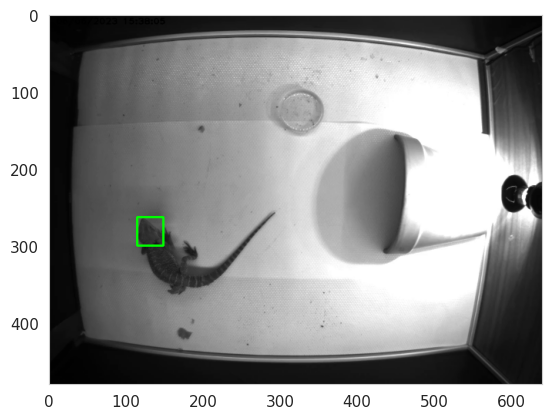

In [ ]:
%matplotlib inline
from analysis.predictors.pogona_head import PogonaHead

ph = PogonaHead('top')
ph.init(None)
det, image = ph.predict(frames['good'], is_draw_pred=True)
if image is not None:
    plt.imshow(image)
    plt.show()

In [ ]:
traj_ids = af.groupby('video_id').y.var().sort_values(ascending=False).iloc[160:190].index.tolist()

# days = set()
# for vid_id in traj_ids:
#   xf_ = xf.query(f'video_id=={vid_id}')
#   days.add(xf_.day.iloc[0])
#   plt.scatter(xf_.x, xf_.y, s=5, alpha=0.4, c='tab:green', marker='.')

for day in days:
    xf_ = get_out_of_experiment_pose('PV91', day)
    if isinstance(xf_, pd.DataFrame):
        zf_ = xf_[['x', 'y']].apply(
            lambda pos: caliber.get_location(*pos), axis=1)
        zf_ = pd.DataFrame(zf_.tolist(), columns=('x', 'y'))
        # xf_ = xf_.query('0 <= x < 43 and y >= -2')
        plt.scatter(zf_.x, zf_.y, s=5, alpha=0.4, c='tab:purple', marker='.')

plt.gca().invert_xaxis()

In [ ]:
for i in range(30):
    ld = Loader(int(orm_res[i][0].id), 'front', is_load_pose=True, is_use_db=False)
    # ld.play_strike(n_frames_back=100, n_frames_forward=100)
    sa = StrikeAnalyzer(ld)
    pf = sa.pose_df
    t = (pf.time - pf.time.iloc[0]).dt.total_seconds()
    plt.figure()
    plt.plot(t, pf['y'] - SCREEN_Y_POS['reptilearn4'])
    plt.title(i)
# z = [pf[m].values - (SCREEN_Y_POS['reptilearn4'] if m == 'y' else 0) for m in metrics.keys()]

In [ ]:
with orm.session() as s:
    orm_res = s.query(Trial, Block, Experiment).join(
      Block, Block.id == Trial.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena == 'reptilearn4',
        Experiment.start_time > '2023-06-01',
        Block.movement_type == 'jump_up'
    ).all()
    
    idx = {}
    for tr, _, _ in tqdm(orm_res):
      if len(tr.strikes) < 2:
        continue
      idx[tr.id] = []
      for strk in tr.strikes:
        try:
          ld = Loader(int(strk.id), 'front', sec_before=0.5, sec_after=0.5)
          traj_df = ld.get_bug_traj_around_strike()
          pose_df = ld.get_bodypart_pose('nose')
          df_ = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                             direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
          # df['time'] = (df.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds()
          idx[tr.id].append((df_.time.values, df_.y_pose.values, df_.y_traj.values))
        except Exception as exc:
          print(f'{strk.id} - {exc}')
                
idx = {k: v for k, v in idx.items() if v}

  0%|          | 0/1494 [00:00<?, ?it/s]

1234 - traj_df is empty
1235 - traj_df is empty
1231 - traj_df is empty
1233 - traj_df is empty
1230 - traj_df is empty
1232 - traj_df is empty
1005 - traj_df is empty
1007 - traj_df is empty
1006 - traj_df is empty
1042 - frames_df is empty after loading
1051 - traj_df is empty
1052 - traj_df is empty
1068 - traj_df is empty
1069 - traj_df is empty
1071 - traj_df is empty
1072 - traj_df is empty
1073 - traj_df is empty
1074 - traj_df is empty
1070 - traj_df is empty
2840 - Video prediction was not found for video db id: 3343
2838 - Video prediction was not found for video db id: 3343
2839 - Video prediction was not found for video db id: 3343
2836 - Video prediction was not found for video db id: 3343
2837 - Video prediction was not found for video db id: 3343
2846 - Video prediction was not found for video db id: 3347
2847 - Video prediction was not found for video db id: 3347
2848 - Video prediction was not found for video db id: 3347
2849 - Video prediction was not found for video 

In [ ]:
n = 20
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for ind in list(idx.keys())[::-1]:
  res_ = idx[ind]
  if i >= n:
    continue
  axes[i, 0].set_ylabel(str(ind))
  for r in res_:
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
  i += 1

In [ ]:
idx.keys()

dict_keys([1776, 1809, 1778, 1782, 1811, 1783, 1793, 1786, 1787, 1785, 2006, 2008, 2009, 2015, 2005, 1796, 1794, 2017, 2018, 2023, 2021, 2022, 1816, 1813, 1997, 1818, 2025, 2026, 2027, 2029, 2035, 2037, 1838, 1840, 1842, 1846, 1848, 1850, 1860, 1862, 1864, 1867, 1868, 1869, 1870, 1877, 1873, 1892, 1890, 1894, 1897, 1898, 1899, 1907, 1903, 1904, 1905, 1911, 1908, 1909, 1912, 1917, 1920, 1931, 1928, 1929, 1934, 1936, 1942, 1938, 1941, 1953, 1954, 1755, 1756, 1757, 2012, 2010, 1994, 2003, 1992, 2001, 2002, 1995, 3588, 3665, 3775, 5262, 5179, 5199, 5212, 5222, 5232, 5136, 5157, 5194, 5919, 5932, 5954, 5955, 5958, 5964, 5965, 5977, 6002, 6004, 6006, 6014, 6056, 6060, 6062, 6066, 6068])

In [ ]:
for ind, res_ in idx.items():
    fig, axes = plt.subplots(2, 1, figsize=(10, 3))
    t = np.concatenate([r[0] for r in res_])
    tidx = t.argsort()
    t = t[tidx]
    t = pd.Series(t - t[0]).dt.total_seconds().values
    axes[0].plot(t, np.concatenate([r[1] for r in res_])[tidx])
    axes[0].set_xticks([])
    axes[0].set_title(str(ind))
    axes[1].plot(t, np.concatenate([r[2] for r in res_])[tidx])
    axes[1].invert_yaxis()

In [ ]:
n = 50
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for r in idx:
  if i >= n:
    break
  if (r[2] < 700).any():
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
    i += 1

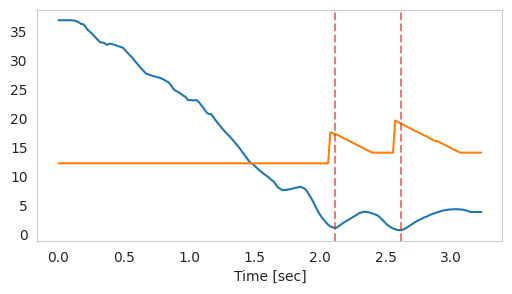

In [ ]:
orm_res

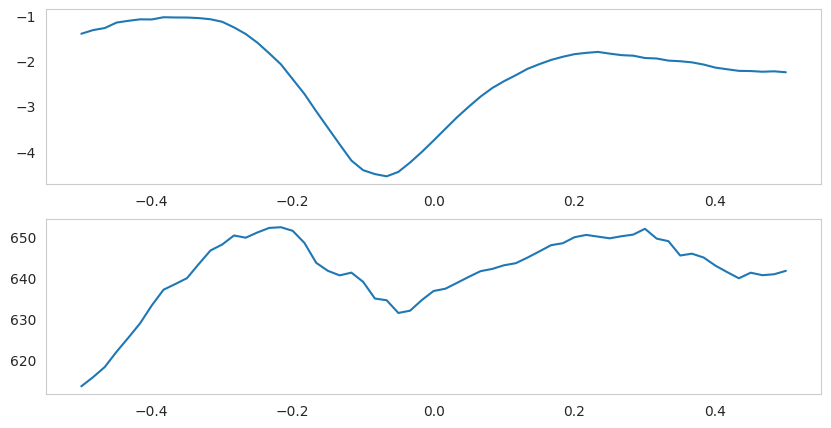

In [ ]:
idx = [i for i, r in enumerate(idx) if (r[2] < 700).any()]

pose_y = np.nanmean(np.vstack([x[1] for x in np.array(idx)[idx]]), axis=0)
traj_y = np.nanmean(np.vstack([x[2] for x in np.array(idx)[idx]]), axis=0)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(idx[0][0], pose_y)
axes[1].plot(idx[0][0], traj_y)

In [ ]:
df_ = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                   direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
df_

time       cam_x       cam_y      prob  \
0   2023-05-31 09:36:56.289805824  881.322327  713.982605  0.999980   
1   2023-05-31 09:36:56.306471936  881.275452  713.964050  0.999980   
2   2023-05-31 09:36:56.323139072  881.338379  713.873901  0.999980   
3   2023-05-31 09:36:56.339804928  881.237244  713.778809  0.999978   
4   2023-05-31 09:36:56.356472064  881.165100  713.767151  0.999977   
..                            ...         ...         ...       ...   
236 2023-05-31 09:37:00.223077888  504.704010  904.293640  0.999876   
237 2023-05-31 09:37:00.239744000  504.537811  903.236938  0.999925   
238 2023-05-31 09:37:00.256411136  504.421417  902.344360  0.999951   
239 2023-05-31 09:37:00.273076992  504.478088  901.922485  0.999956   
240 2023-05-31 09:37:00.289742848  504.692261  901.496155  0.999956   

        x_pose    y_pose  x_traj  y_traj  
0    12.891213  5.116192    1639     755  
1    12.893800  5.117261    1639     755  
2    12.890327  5.122453    1635     755  
3    12.895909  5.127930    1631     755  
4    12.899891  5.128601    1627     755  
..         ...       ...     ...     ...  
236  21.735356 -0.189697    1267     705  
237  21.745105 -0.128837    1267     705  
238  21.751933 -0.077429    1267     705  
239  21.748608 -0.053131    1267     705  
240  21.736046 -0.028576    1267     705  

[241 rows x 8 columns]

In [ ]:
df_['time2'] = (df_.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds()
df_

time       cam_x       cam_y      prob  \
0   2023-05-31 09:36:56.289805824  881.322327  713.982605  0.999980   
1   2023-05-31 09:36:56.306471936  881.275452  713.964050  0.999980   
2   2023-05-31 09:36:56.323139072  881.338379  713.873901  0.999980   
3   2023-05-31 09:36:56.339804928  881.237244  713.778809  0.999978   
4   2023-05-31 09:36:56.356472064  881.165100  713.767151  0.999977   
..                            ...         ...         ...       ...   
236 2023-05-31 09:37:00.223077888  504.704010  904.293640  0.999876   
237 2023-05-31 09:37:00.239744000  504.537811  903.236938  0.999925   
238 2023-05-31 09:37:00.256411136  504.421417  902.344360  0.999951   
239 2023-05-31 09:37:00.273076992  504.478088  901.922485  0.999956   
240 2023-05-31 09:37:00.289742848  504.692261  901.496155  0.999956   

        x_pose    y_pose  x_traj  y_traj     time2  
0    12.891213  5.116192    1639     755 -1.999968  
1    12.893800  5.117261    1639     755 -1.983302  
2    12.890327  5.122453    1635     755 -1.966635  
3    12.895909  5.127930    1631     755 -1.949969  
4    12.899891  5.128601    1627     755 -1.933302  
..         ...       ...     ...     ...       ...  
236  21.735356 -0.189697    1267     705  1.933304  
237  21.745105 -0.128837    1267     705  1.949970  
238  21.751933 -0.077429    1267     705  1.966637  
239  21.748608 -0.053131    1267     705  1.983303  
240  21.736046 -0.028576    1267     705  1.999969  

[241 rows x 9 columns]

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
sns.lineplot(data=df_, x='time', y='y_pose', ax=axes[0])
sns.lineplot(data=df_, x='time', y='y_traj', ax=axes[1])

In [ ]:
with orm.session() as s:
    orm_res = s.query(Strike, Block, Experiment).join(
        Block, Block.id == Strike.block_id).join(
        Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.animal_id == 'BP28'
    ).all()
    
for strk, _, _ in orm_res:
    ld = Loader(int(strk.id), 'front', is_load_pose=False, is_use_db=False)
    ld.play_strike(n_frames_back=100, n_frames_forward=100)
    
    
strk = orm_res[-2][0]
ld = Loader(int(strk.id), 'front', is_load_pose=False, is_use_db=False, sec_before=2, sec_after=2)
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
writer = None
for i, frame in ld.gen_frames_around_strike():
    if writer is None:
        h, dev_angs_speed = frame.shape[:2]
        writer = cv2.VideoWriter('/data/Pogona_Pursuit/output/experiments/BP28/frog_strike1.avi', fourcc, 60, (dev_angs_speed, h), 0)
    writer.write(frame)

writer.release()